In [79]:
# === IMPORTS ===
# Import libraries for numerical computations, file handling, and formatted output

import numpy as np                   # NumPy: for matrix, vector, eigenvalue, Cholesky operations
import os                             # OS: to manage folders, paths
import glob                           # Glob: to find all files matching a pattern (*.npy)
from pathlib import Path              # Pathlib: advanced file path handling (optional here)
from tabulate import tabulate         # Tabulate: for printing beautiful tables in the terminal


# === FUNCTION DEFINITIONS ===

# ---- 1. Process Displacement Vector ----
def process_displacement_vector(displacement_matrix):
    """Flatten and remove z-components from a 3D displacement matrix to make it 2D (X-Y only)."""
    flattened = displacement_matrix.flatten()  # Convert matrix into a long 1D array
    displacement_2d = flattened[np.where(np.arange(len(flattened)) % 3 != 2)]  # Remove every 3rd (z) entry
    return displacement_2d  # Return the cleaned 2D vector


# ---- 2. Analyze a Matrix ----
def analyze_matrix(matrix, name, magnitude):
    """Analyze properties of a matrix: shape, memory, symmetry, eigenvalues, SPD check."""
    nonzeros = np.count_nonzero(matrix)  # Number of non-zero entries
    density = nonzeros / matrix.size     # Density (fraction of non-zero elements)

    is_symmetric = np.allclose(matrix, matrix.T, rtol=1e-8, atol=1e-8)  # Symmetry check
    max_asymmetry = np.max(np.abs(matrix - matrix.T)) if is_symmetric else 0.0  # Max deviation if symmetric

    # Eigenvalue Analysis
    try:
        eigvals = np.linalg.eigvals(matrix)
        min_eigval = np.min(np.real(eigvals))
        max_eigval = np.max(np.real(eigvals))
        is_spd_eigen = True if min_eigval > 0 else False
    except np.linalg.LinAlgError:
        min_eigval = max_eigval = np.nan
        is_spd_eigen = False

    # Cholesky Decomposition: checks if matrix is symmetric positive definite
    try:
        np.linalg.cholesky(matrix)
        is_spd_cholesky = True
    except np.linalg.LinAlgError:
        is_spd_cholesky = False

    # Assemble all analysis results into a list
    return [
        magnitude,
        matrix.shape,
        matrix.dtype,
        f"{matrix.nbytes / 1024:.2f} KB",
        nonzeros,
        f"{density:.2%}",
        matrix.size - nonzeros,
        is_symmetric,
        f"{max_asymmetry:.2e}",
        f"{np.min(matrix):.2e}",
        f"{np.max(matrix):.2e}",
        f"{np.mean(matrix):.2e}",
        f"{np.std(matrix):.2e}",
        f"{min_eigval:.2e}",
        f"{max_eigval:.2e}",
        is_spd_eigen,
        is_spd_cholesky,
    ]


# ---- 3. Analyze a Vector ----
def analyze_vector(vector, name, magnitude):
    """Analyze properties of a vector: size, density, min/max/mean values."""
    nonzeros = np.count_nonzero(vector)
    density = nonzeros / vector.size

    return [
        magnitude,
        vector.shape,
        vector.dtype,
        f"{vector.nbytes / 1024:.2f} KB",
        nonzeros,
        f"{density:.2%}",
        vector.size - nonzeros,
        "-", "-",  # Symmetry/Asymmetry not applicable to vectors
        f"{np.min(vector):.2e}",
        f"{np.max(vector):.2e}",
        f"{np.mean(vector):.2e}",
        f"{np.std(vector):.2e}",
        "-", "-",  # Eigenvalue SPD checks not applicable to vectors
        "-", "-"
    ]


# ---- 4. Extract Magnitude from Filename ----
def extract_magnitude(filename):
    """Extract magnitude (load conditions, etc.) from the filename format."""
    start = filename.find('[')
    end = filename.find(']')
    if start == -1 or end == -1:
        return None
    magnitude_str = filename[start + 1:end]
    return tuple(map(float, magnitude_str.split(',')))  # Returns a tuple like (1.0, 2.0)


# ---- 5. Load and Analyze Components ----
def load_and_analyze_components(folder, component_name, analysis_function):
    """Load .npy files from a folder and analyze them with a specified function."""
    files = sorted(glob.glob(os.path.join(folder, "*.npy")))
    table_data = []
    magnitudes = []

    if not files:
        print(f"No files found in {component_name} folder.")
        return None, None

    for file in files:
        component = np.load(file)
        magnitude = extract_magnitude(os.path.basename(file))
        magnitudes.append(magnitude)
        table_data.append(analysis_function(component, component_name, magnitude))

    headers = [
        "Magnitude", "Shape", "Data Type", "Memory Size", "Non-Zero Elements", "Density",
        "Zero Elements", "Symmetry Check", "Max Asymmetry", "Min Value", "Max Value",
        "Mean Value", "Std Dev", "Min Eig Value", "Max Eig Value", "SPD (Eigen)", "Symmetric PD"
    ]

    print(f"\nDetailed Analysis of {component_name}:")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    return files, magnitudes


# ---- 6. Load and Analyze Displacement Vectors ----
def load_and_analyze_displacement_vectors(folder):
    """Load displacement vectors (.npy) and analyze both the original and processed (2D) forms."""
    files = sorted(glob.glob(os.path.join(folder, "*.npy")))
    original_table_data = []
    processed_table_data = []
    magnitudes = []

    if not files:
        print("No files found in Displacement Vector folder.")
        return None, None

    for file in files:
        original_vector = np.load(file)
        processed_vector = process_displacement_vector(original_vector)
        magnitude = extract_magnitude(os.path.basename(file))
        magnitudes.append(magnitude)

        original_table_data.append(analyze_vector(original_vector, "Original Displacement Vector", magnitude))
        processed_table_data.append(analyze_vector(processed_vector, "Processed Displacement Vector", magnitude))

    headers = [
        "Magnitude", "Shape", "Data Type", "Memory Size", "Non-Zero Elements", "Density",
        "Zero Elements", "Symmetry Check", "Max Asymmetry", "Min Value", "Max Value",
        "Mean Value", "Std Dev", "Min Eig Value", "Max Eig Value", "SPD (Eigen)", "Symmetric PD"
    ]

    print("\nDetailed Analysis of Original Displacement Vectors:")
    print(tabulate(original_table_data, headers=headers, tablefmt="grid"))

    print("\nDetailed Analysis of Processed Displacement Vectors:")
    print(tabulate(processed_table_data, headers=headers, tablefmt="grid"))

    return files, magnitudes


# ---- 7. Check Missing Files Across Components ----
def check_missing_files(mass_mags, stiffness_mags, disp_mags, force_mags):
    """Check if magnitudes are consistently available across all components."""
    all_magnitudes = set(mass_mags) & set(stiffness_mags) & set(disp_mags) & set(force_mags)

    missing = {
        "Mass Matrix": set(mass_mags) - all_magnitudes,
        "Stiffness Matrix": set(stiffness_mags) - all_magnitudes,
        "Displacement Vector": set(disp_mags) - all_magnitudes,
        "Force Vector": set(force_mags) - all_magnitudes,
    }

    print("\n=== Missing Files Report ===")
    for component, missing_mags in missing.items():
        if missing_mags:
            print(f" - Missing in {component}: {missing_mags}")
        else:
            print(f" - All magnitudes present in {component}.")


# ---- 8. Final Compatibility Check ----
def final_compatibility_check(M, K, x, f):
    """Verify compatibility of dimensions between Mass, Stiffness, Displacement and Force."""
    print("\n" + "=" * 50)
    print("FINAL COMPATIBILITY CHECK")
    print("=" * 50)

    print(f"Mass matrix shape: {M.shape}")
    print(f"Stiffness matrix shape: {K.shape}")
    print(f"2D Displacement vector shape: {x.shape}")
    print(f"Force vector shape: {f.shape}")

    incompatible = []

    if M.shape[0] != x.shape[0]:
        incompatible.append("Mass matrix row count and displacement vector row count don't match.")
    if M.shape[0] != f.shape[0]:
        incompatible.append("Mass matrix row count and force vector row count don't match.")
    if K.shape != M.shape:
        incompatible.append("Mass matrix and stiffness matrix dimensions don't match.")

    if incompatible:
        print("\nWARNING: Found incompatibilities:")
        for issue in incompatible:
            print(f" - {issue}")
    else:
        print("\nAll components have compatible dimensions!")

    print("\nAvailable components:")
    print(f"M: Shape {M.shape}")
    print(f"K: Shape {K.shape}")
    print(f"x_original: Shape {x.shape}")
    print(f"x: Shape {x.shape} (Processed)")
    print(f"f: Shape {f.shape}")
    print("is_compatible:", not incompatible)
    print("loaded_successfully: True")
    print("compatibility_checked: True")


# ---- 9. Load Structural Matrices (MAIN DRIVER FUNCTION) ----
def load_structural_matrices():
    """Main function to load, analyze, and check all structural matrices and vectors."""
    current_path = os.getcwd()
    kratos_results_path = os.path.join(current_path, "Kratos_Results")

    print("\n" + "=" * 50)
    print("LOADING MASS MATRIX")
    print("=" * 50)
    mass_folder = os.path.join(kratos_results_path, "mass_results")
    M_files, mass_magnitudes = load_and_analyze_components(mass_folder, "Mass Matrix", analyze_matrix)

    print("\n" + "=" * 50)
    print("LOADING STIFFNESS MATRIX")
    print("=" * 50)
    stiffness_folder = os.path.join(kratos_results_path, "stiffness_results")
    K_files, stiffness_magnitudes = load_and_analyze_components(stiffness_folder, "Stiffness Matrix", analyze_matrix)

    print("\n" + "=" * 50)
    print("LOADING DISPLACEMENT VECTOR")
    print("=" * 50)
    displacement_folder = os.path.join(kratos_results_path, "displacement_results")
    x_files, disp_magnitudes = load_and_analyze_displacement_vectors(displacement_folder)

    print("\n" + "=" * 50)
    print("LOADING FORCE VECTOR")
    print("=" * 50)
    force_folder = os.path.join(kratos_results_path, "loading_results")
    f_files, force_magnitudes = load_and_analyze_components(force_folder, "Force Vector", analyze_vector)

    if (mass_magnitudes == stiffness_magnitudes == disp_magnitudes == force_magnitudes):
        magnitudes = mass_magnitudes
        print("\nAll magnitudes are identical and saved under 'magnitudes'.")
    else:
        print("\nWarning: Magnitudes are not identical across components.")
        magnitudes = None

    if M_files and K_files and x_files and f_files:
        M = np.load(M_files[0])
        K = np.load(K_files[0])

        x_original = np.column_stack([np.load(file) for file in x_files])
        x = np.column_stack([process_displacement_vector(np.load(file)) for file in x_files])
        f = np.column_stack([np.load(file) for file in f_files])

        final_compatibility_check(M, K, x, f)

        print("\nMatrices successfully loaded and compatibility checked!")

        return M, K, x_original, x, f, magnitudes
    else:
        print("Error: One or more required components are missing.")
        return None, None, None, None, None, None


# === MAIN RUNNING POINT ===
M, K, x_original, x, f, magnitudes = load_structural_matrices()



LOADING MASS MATRIX

Detailed Analysis of Mass Matrix:
+---------------------------+------------+-------------+---------------+---------------------+-----------+-----------------+------------------+-----------------+-------------+-------------+--------------+-----------+-----------------+-----------------+---------------+----------------+
| Magnitude                 | Shape      | Data Type   | Memory Size   |   Non-Zero Elements | Density   |   Zero Elements | Symmetry Check   |   Max Asymmetry |   Min Value |   Max Value |   Mean Value |   Std Dev |   Min Eig Value |   Max Eig Value | SPD (Eigen)   | Symmetric PD   |
+===========================+============+=============+===============+=====================+===========+=================+==================+=================+=============+=============+==============+===========+=================+=================+===============+================+
| (-137.59, -63.13, 362.93) | (612, 612) | float64     | 2926.12 KB    |              

KeyboardInterrupt: 

In [ ]:
# Check if the required matrices and vectors have already been loaded into the current notebook session
if 'M' in globals() and 'K' in globals() and 'x' in globals() and 'f' in globals():
    # If all required components (Mass, Stiffness, Displacement, Force) exist:
    print("Matrices are already loaded and ready for boundary condition application.")
else:
    # If any of these components are missing, inform the user clearly:
    print("Error: Matrices are not loaded. Please run `load_structural_matrices()` first.")


Matrices are already loaded and ready for boundary condition application.


In [ ]:
def apply_boundary_conditions_multiple_components_with_nodes(M, K, f, magnitudes):
    """
    Apply boundary conditions (using the penalty method) to the Mass matrix (M),
    Stiffness matrix (K), and Force vectors (f) for multiple simulation cases.
    It also provides a summary table of constrained degrees of freedom (DOFs)
    and the corresponding nodes for each case.
    """
    try:
        # Locate the .mdpa file in the current directory, which defines the geometry and boundary conditions
        base_path = Path.cwd()
        mdpa_file = next(base_path.glob('*.mdpa'), None)
        if not mdpa_file:
            raise FileNotFoundError("No .mdpa file found in the current directory.")
        print(f"Using .mdpa file: {mdpa_file.name}")

        # Initialize containers for nodes and fixed boundary nodes
        nodes = {}               # Stores all nodes with their coordinates
        fixed_nodes = set()      # Stores IDs of nodes where displacement is fixed (boundary conditions)

        # Read the .mdpa file to identify node definitions and boundary conditions
        with open(mdpa_file, 'r') as file:
            lines = file.readlines()

        reading_nodes = False    # Flag indicating we are reading the node section
        reading_fixed = False    # Flag indicating we are reading the fixed nodes section

        # Parse .mdpa file line-by-line to populate 'nodes' and 'fixed_nodes'
        for line in lines:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif "Begin SubModelPart DISPLACEMENT_fixed" in line or "Begin SubModelPart DISPLACEMENT_Fixed" in line:
                reading_fixed = True
                continue
            elif "End SubModelPart" in line:
                reading_fixed = False
                continue

            if reading_nodes:
                parts = line.split()
                if len(parts) >= 4:
                    node_id = int(parts[0])
                    x_coord, y_coord, z_coord = map(float, parts[1:4])
                    nodes[node_id] = (x_coord, y_coord, z_coord)  # Store node coordinates by ID

            if reading_fixed:
                try:
                    node_id = int(line)
                    print(f"Found fixed node: {node_id}")
                    fixed_nodes.add(node_id)  # Add node ID to fixed nodes set
                except ValueError:
                    # Skip lines that don't represent node IDs
                    pass

        # Penalty method parameters for strongly enforcing boundary conditions
        penalty_factor = 1e12
        max_stiffness = np.max(np.abs(K))
        penalty = penalty_factor * max_stiffness  # Penalty ensures constrained DOFs effectively remain fixed

        print("\nApplying boundary conditions to Mass, Stiffness, and Force for multiple cases...")
        
        # Prepare summary data table structure
        summary_data = []
        headers = ["File Index", "Magnitude", "Node Numbers", "Constrained DOFs (Applied Nodes)"]

        # Copy original matrices to avoid modifying them directly
        M_constrained = np.copy(M)
        K_constrained = np.copy(K)
        f_constrained = np.copy(f)

        # Loop through each case (each column in the force vector represents a different load case)
        for file_index in range(f.shape[1]):
            applied_dofs = []    # List to record constrained DOFs per case
            applied_nodes = []   # List to record nodes where constraints are applied
            
            # Apply boundary conditions for each fixed node identified earlier
            for node_id in fixed_nodes:
                # DOF indexing: each node has two DOFs in 2D (X, Y)
                x_dof = (node_id - 1) * 2
                y_dof = x_dof + 1

                # Apply high-value penalty to constrain displacement DOFs in both X and Y directions
                M_constrained[x_dof, x_dof] = penalty
                M_constrained[y_dof, y_dof] = penalty
                K_constrained[x_dof, x_dof] = penalty
                K_constrained[y_dof, y_dof] = penalty

                # Force vectors are zeroed out at constrained DOFs
                f_constrained[x_dof, file_index] = 0.0
                f_constrained[y_dof, file_index] = 0.0

                # Record applied DOFs and nodes for summary
                applied_dofs.append(f"{x_dof} (X), {y_dof} (Y)")
                applied_nodes.append(node_id)

            # Append details of applied boundary conditions to the summary data
            summary_data.append([
                file_index + 1,
                magnitudes[file_index],
                ", ".join(map(str, applied_nodes)),
                ", ".join(applied_dofs)
            ])

        # Display a comprehensive summary table of applied boundary conditions
        print("\nBoundary Condition Application Summary for Mass, Stiffness, and Force:")
        print(tabulate(summary_data, headers=headers, tablefmt="grid"))

        print("\nBoundary conditions applied successfully!")
        print(f"Number of constrained DOFs: {len(fixed_nodes) * 2}")

        # Return modified (constrained) matrices/vectors along with fixed node IDs
        return M_constrained, K_constrained, f_constrained, fixed_nodes

    except Exception as e:
        print(f"Error applying boundary conditions: {e}")
        return None, None, None, None


# ===== Main Execution =====
try:
    # Verify required matrices/vectors are loaded into the current workspace
    if 'M' in globals() and 'K' in globals() and 'f' in globals() and 'magnitudes' in globals():
        print("Matrices are already loaded and ready for boundary condition application.")
    else:
        print("Error: Matrices are not loaded. Please load them using the proper function.")

    # Execute boundary condition application function defined above
    print("\nApplying boundary conditions for Mass, Stiffness, and Force across multiple cases...")
    M_constrained, K_constrained, f_constrained, fixed_nodes = apply_boundary_conditions_multiple_components_with_nodes(M, K, f, magnitudes)

    # Verify and confirm results
    if M_constrained is not None:
        print("\nVerification of constrained system:")
        print(f"Original Mass Matrix Shape: {M.shape}")
        print(f"Constrained Mass Matrix Shape: {M_constrained.shape}")
        print(f"Original Stiffness Matrix Shape: {K.shape}")
        print(f"Constrained Stiffness Matrix Shape: {K_constrained.shape}")
        print(f"Original Force Vector Shape: {f.shape}")
        print(f"Constrained Force Vector Shape: {f_constrained.shape}")
        print(f"Number of constrained DOFs: {len(fixed_nodes) * 2}")
    else:
        print("Boundary conditions could not be applied due to errors.")

except Exception as e:
    print(f"Error during boundary condition application: {str(e)}")


Matrices are already loaded and ready for boundary condition application.

Applying boundary conditions for Mass, Stiffness, and Force across multiple cases...
Using .mdpa file: 2D_beam_udl_loading.mdpa
Found fixed node: 1
Found fixed node: 2
Found fixed node: 6
Found fixed node: 10
Found fixed node: 17
Found fixed node: 25

Applying boundary conditions to Mass, Stiffness, and Force for multiple cases...

Boundary Condition Application Summary for Mass, Stiffness, and Force:
+--------------+---------------------------+---------------------+--------------------------------------------------------------------------------------------+
|   File Index | Magnitude                 | Node Numbers        | Constrained DOFs (Applied Nodes)                                                           |
+==============+===========================+=====================+============================================================================================+
|            1 | (-137.59, -63.13, 362.9

In [ ]:
def compare_force_vectors_multiple(f_list, f_constrained_list, magnitudes):
    """
    Compare multiple sets of original and constrained force vectors to identify differences.
    Generates a summary table and detailed reports for each magnitude.
    """

    # Verify that inputs are NumPy arrays for consistency in calculations
    if not isinstance(f_list, np.ndarray) or not isinstance(f_constrained_list, np.ndarray):
        raise ValueError("f_list and f_constrained_list must be NumPy arrays.")

    # Ensure original and constrained force vectors have identical dimensions
    if f_list.shape != f_constrained_list.shape:
        raise ValueError("f_list and f_constrained_list must have the same shape.")

    # Check that the number of magnitudes matches the number of columns in the force vectors
    if f_list.shape[1] != len(magnitudes):
        raise ValueError("The number of magnitudes does not match the number of force vector files.")

    # Initialize data structure for the summary comparison table
    summary_data = []
    headers = [
        "File Index", "Magnitude", "Total DOFs",
        "Non-Zero DOFs (Original)", "Non-Zero DOFs (Constrained)", "Differences Found"
    ]

    # Iterate over each load case (column) to perform detailed comparisons
    for i, magnitude in enumerate(magnitudes):
        # Extract original and constrained vectors for current case
        f = f_list[:, i]
        f_constrained = f_constrained_list[:, i]

        # Check if original and constrained force vectors match within a specified tolerance
        are_equal = np.allclose(f, f_constrained, rtol=1e-10)

        # Calculate absolute differences between vectors to identify significant deviations
        diff = np.abs(f - f_constrained)
        different_dofs = np.where(diff > 1e-10)[0]  # DOFs with notable differences
        num_diff_dofs = len(different_dofs)  # Total count of differing DOFs

        # Count the number of non-zero entries in original and constrained vectors
        non_zero_original = np.count_nonzero(f)
        non_zero_constrained = np.count_nonzero(f_constrained)

        # Record summarized comparison data for this case
        summary_data.append([
            i + 1,
            magnitude,
            f.shape[0],
            non_zero_original,
            non_zero_constrained,
            num_diff_dofs,
        ])

    # Display a summary table clearly indicating force vector differences for each case
    print("\nForce Vector Comparison Summary:")
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))

    # Provide detailed information for each case where differences were found
    for i, magnitude in enumerate(magnitudes):
        # Extract vectors again for detailed difference analysis
        f = f_list[:, i]
        f_constrained = f_constrained_list[:, i]

        # Recalculate differences
        diff = np.abs(f - f_constrained)
        different_dofs = np.where(diff > 1e-10)[0]

        # If differences exist, report them clearly
        if len(different_dofs) > 0:
            print(f"\nDetailed Differences for File {i + 1} (Magnitude: {magnitude}):")

            # Setup detailed table with specific DOFs and corresponding nodes
            headers = ["DOF", "Node", "Original Value", "Constrained Value", "Difference"]
            table_data = []

            for dof in different_dofs:
                # Calculate corresponding node and determine if DOF is in X or Y direction
                node = dof // 2 + 1  # Node numbering starts from 1
                dof_label = "X" if dof % 2 == 0 else "Y"

                # Append the difference details for the current DOF
                table_data.append([
                    dof_label,
                    node,
                    f[dof],
                    f_constrained[dof],
                    diff[dof]
                ])

            # Print detailed differences for current magnitude/case
            print(tabulate(table_data, headers=headers, tablefmt="grid"))
        else:
            # Clearly state if no significant differences are detected
            print(f"\nNo significant differences found for File {i + 1} (Magnitude: {magnitude}).")


# ==== Example Usage ====
try:
    print("\nComparing force vectors for multiple files...")

    # Note: Ensure these variables (`f`, `f_constrained`, and `magnitudes`) are correctly loaded beforehand.
    compare_force_vectors_multiple(f, f_constrained, magnitudes)

except Exception as e:
    # Handle and report errors clearly if encountered during comparison
    print(f"Error during force vector comparison: {str(e)}")



Comparing force vectors for multiple files...

Force Vector Comparison Summary:
+--------------+---------------------------+--------------+----------------------------+-------------------------------+---------------------+
|   File Index | Magnitude                 |   Total DOFs |   Non-Zero DOFs (Original) |   Non-Zero DOFs (Constrained) |   Differences Found |
+==============+===========================+==============+============================+===============================+=====================+
|            1 | (-137.59, -63.13, 362.93) |          612 |                        611 |                           599 |                  12 |
+--------------+---------------------------+--------------+----------------------------+-------------------------------+---------------------+
|            2 | (-198.79, 228.5, -134.8)  |          612 |                        612 |                           600 |                  12 |
+--------------+---------------------------+--------------+--

In [ ]:
def check_bc_applied_to_force(f_constrained, magnitudes, threshold=1e-7):
    """
    Verify whether boundary conditions (BC) have been correctly applied to constrained force vectors.
    Identifies and clearly reports non-zero entries in a detailed, tabulated format.
    """

    # If `f_constrained` is a single NumPy 2D array, convert it into a list of vectors (columns)
    if isinstance(f_constrained, np.ndarray) and len(f_constrained.shape) == 2:
        print("Converting 2D array `f_constrained` to a list of vectors for analysis.")
        f_constrained = [f_constrained[:, i] for i in range(f_constrained.shape[1])]

    # Verify that the number of force vectors matches the number of magnitudes provided
    if len(f_constrained) != len(magnitudes):
        print(f"Error: Number of force vectors ({len(f_constrained)}) doesn't match "
              f"the number of magnitudes provided ({len(magnitudes)}).")
        return  # Exit function if mismatch occurs

    # Prepare headers for the detailed summary table
    headers = ["File Index", "Magnitude", "DOF", "Node", "Direction", "Value"]
    summary_data = []  # List to hold detailed results

    # Iterate over each constrained force vector along with its magnitude
    for file_idx, (f_cons, magnitude) in enumerate(zip(f_constrained, magnitudes)):
        # Find DOFs where constrained force vector entries are significantly non-zero (beyond threshold)
        non_zero_indices = np.where(abs(f_cons) > threshold)[0]

        # If no significant non-zero entries found, clearly inform the user and move to the next case
        if len(non_zero_indices) == 0:
            print(f"All DOFs are effectively zero (below threshold) for Magnitude {magnitude}.")
            continue

        # Record detailed information about each non-zero DOF found
        for dof in non_zero_indices:
            node = dof // 2 + 1            # Calculate node number (assuming 2 DOFs per node: X, Y)
            direction = "X" if dof % 2 == 0 else "Y"  # Determine direction of the DOF
            value = f_cons[dof]            # Record the actual value present in constrained force vector

            # Append details to the summary data for reporting
            summary_data.append([
                file_idx + 1,              # Index of file/case (1-based indexing for user-friendliness)
                magnitude,                 # Corresponding magnitude/load condition
                dof,                       # Global Degree of Freedom index
                node,                      # Node ID calculated above
                direction,                 # Direction (X/Y)
                value                      # Value at the specific DOF
            ])

    # If summary data is not empty, print a detailed table clearly showing applied boundary conditions
    if summary_data:
        print("\nBoundary Conditions Applied - Detailed Report:")
        print(tabulate(summary_data, headers=headers, tablefmt="grid"))
    else:
        # Clearly inform the user if no non-zero boundary conditions were detected
        print("No non-zero entries found in the constrained force vectors. All DOFs are within the defined threshold.")


# ==== Example Usage ====
try:
    print("\nChecking if boundary conditions are applied to constrained force vectors...")
    # Make sure variables `f_constrained` and `magnitudes` are loaded/defined beforehand
    check_bc_applied_to_force(f_constrained, magnitudes)

except Exception as e:
    # Handle any unexpected errors gracefully and clearly report them
    print(f"Error during boundary condition check: {str(e)}")



Checking if boundary conditions are applied to constrained force vectors...
Converting 2D array `f_constrained` to a list of vectors for analysis.
All DOFs are effectively zero (below threshold) for Magnitude (-137.59, -63.13, 362.93).
All DOFs are effectively zero (below threshold) for Magnitude (-198.79, 228.5, -134.8).
All DOFs are effectively zero (below threshold) for Magnitude (104.64, -25.63, 160.89).
All DOFs are effectively zero (below threshold) for Magnitude (17.45, -13.32, 69.69).
All DOFs are effectively zero (below threshold) for Magnitude (186.02, 35.84, -213.65).
All DOFs are effectively zero (below threshold) for Magnitude (229.73, -34.4, -232.19).
All DOFs are effectively zero (below threshold) for Magnitude (34.88, -235.52, 250.55).
All DOFs are effectively zero (below threshold) for Magnitude (379.97, -275.91, -44.58).
All DOFs are effectively zero (below threshold) for Magnitude (391.22, -286.75, 386.86).
All DOFs are effectively zero (below threshold) for Magnitu

In [ ]:
def check_bc_applied_to_force(f_constrained, magnitudes, threshold=1e-7):
    """
    Verify if boundary conditions (BC) have been correctly applied to the constrained force vectors.
    Produces both summary and detailed tables highlighting non-zero force entries.
    """

    # If f_constrained is a 2D numpy array, convert it into a list of individual column vectors
    if isinstance(f_constrained, np.ndarray) and len(f_constrained.shape) == 2:
        print("Converting 2D array 'f_constrained' into a list of vectors (one per load case).")
        f_constrained = [f_constrained[:, i] for i in range(f_constrained.shape[1])]

    # Validate that the number of force vectors matches the number of magnitudes provided
    if len(f_constrained) != len(magnitudes):
        print(f"Error: Mismatch between the number of force vectors ({len(f_constrained)}) "
              f"and provided magnitudes ({len(magnitudes)}).")
        return  # Exit the function early if there's a mismatch

    # Prepare headers for summary and detailed tables
    summary_headers = ["File Index", "Magnitude", "Non-Zero DOFs"]
    details_headers = ["File Index", "Magnitude", "DOF", "Node", "Direction", "Value"]

    # Initialize empty lists to store summary and detailed data
    summary_data = []
    details_data = []

    # Iterate through each constrained force vector along with its corresponding magnitude
    for file_idx, (f_cons, magnitude) in enumerate(zip(f_constrained, magnitudes)):
        
        # Identify DOFs with significant non-zero force entries beyond the threshold
        non_zero_indices = np.where(abs(f_cons) > threshold)[0]

        # Add summary information (file index, magnitude, count of non-zero DOFs)
        summary_data.append([
            file_idx + 1,              # User-friendly indexing starting from 1
            magnitude,                 # Load magnitude
            len(non_zero_indices),     # Count of non-zero DOFs
        ])

        # For each non-zero DOF, collect detailed information for a deeper analysis
        for dof in non_zero_indices:
            node = dof // 2 + 1                       # Determine node ID (2 DOFs per node assumption)
            direction = "X" if dof % 2 == 0 else "Y"  # Determine if the DOF corresponds to X or Y direction

            # Append detailed information for this DOF
            details_data.append([
                file_idx + 1,                         # File index for reference
                magnitude,                            # Corresponding magnitude
                dof,                                  # Global DOF index
                node,                                 # Calculated node ID
                direction,                            # Direction (X or Y)
                f_cons[dof],                          # Actual force value at the DOF
            ])

    # Display a concise summary table of boundary conditions application status across all cases
    print("\nBoundary Conditions Summary:")
    print(tabulate(summary_data, headers=summary_headers, tablefmt="grid"))

    # If any non-zero entries exist, provide a detailed breakdown for further inspection
    if details_data:
        print("\nNon-Zero DOFs Details:")
        print(tabulate(details_data, headers=details_headers, tablefmt="grid"))
    else:
        # Inform the user explicitly if no significant boundary conditions were detected
        print("\nAll DOFs are zero across all cases. Boundary conditions seem correctly applied.")


# ==== Example Usage ====
try:
    print("\nChecking if boundary conditions are applied to constrained force vectors...")

    # Ensure `f_constrained` and `magnitudes` are defined and loaded correctly beforehand
    check_bc_applied_to_force(f_constrained, magnitudes)

except Exception as e:
    # Clearly handle and report any unexpected issues during execution
    print(f"Error during boundary condition check: {str(e)}")



Checking if boundary conditions are applied to constrained force vectors...
Converting 2D array 'f_constrained' into a list of vectors (one per load case).

Boundary Conditions Summary:
+--------------+---------------------------+-----------------+
|   File Index | Magnitude                 |   Non-Zero DOFs |
+==============+===========================+=================+
|            1 | (-137.59, -63.13, 362.93) |               0 |
+--------------+---------------------------+-----------------+
|            2 | (-198.79, 228.5, -134.8)  |               0 |
+--------------+---------------------------+-----------------+
|            3 | (104.64, -25.63, 160.89)  |               0 |
+--------------+---------------------------+-----------------+
|            4 | (17.45, -13.32, 69.69)    |               0 |
+--------------+---------------------------+-----------------+
|            5 | (186.02, 35.84, -213.65)  |               0 |
+--------------+---------------------------+-------------

In [ ]:
def apply_loads_to_force_vector_multiple_cases(f, f_constrained, fixed_dofs, magnitudes, mdpa_file):
    """
    Apply specified loads to constrained force vectors for multiple load cases.
    Reads node IDs for loads from a given .mdpa file and applies corresponding magnitudes.
    Results are displayed in a structured summary table.
    """

    # Dictionary to store nodes corresponding to different load types from the .mdpa file
    load_nodes = {
        'LinePressure2D_Load_1': [],
        'LinePressure2D_Load_2': [],
        'LinePressure2D_Load_3': []
    }
    current_load = None
    reading_nodes = False

    # Read the .mdpa file to extract nodes associated with each load type
    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()

            # Identify which load submodel is currently being read
            if "Begin SubModelPart LinePressure2D_Load_1" in line or "Begin SubModelPart PointLoad2D_Load_1" in line:
                current_load = 'LinePressure2D_Load_1'
            elif "Begin SubModelPart LinePressure2D_Load_2" in line or "Begin SubModelPart PointLoad2D_Load_2" in line:
                current_load = 'LinePressure2D_Load_2'
            elif "Begin SubModelPart LinePressure2D_Load_3" in line or "Begin SubModelPart PointLoad2D_Load_3" in line:
                current_load = 'LinePressure2D_Load_3'
            elif "End SubModelPart" in line:
                current_load = None
                reading_nodes = False
            elif current_load and "Begin SubModelPartNodes" in line:
                reading_nodes = True
            elif current_load and "End SubModelPartNodes" in line:
                reading_nodes = False
            elif reading_nodes and current_load and line:
                try:
                    node = int(line)
                    load_nodes[current_load].append(node)  # Store node ID for current load type
                except ValueError:
                    continue  # Ignore non-integer lines

    # Prepare table headers for structured output
    headers = [
        "File Index", "Magnitude",
        "Load 1 (Value, Direction)", "Nodes (DOF)",
        "Load 2 (Value, Direction)", "Nodes (DOF)",
        "Load 3 (Value, Direction)", "Nodes (DOF)"
    ]
    table_data = []

    print("\nApplying loads to constrained force vectors for multiple cases...")

    # Iterate through each load case and apply corresponding magnitudes to nodes
    for i, magnitude in enumerate(magnitudes):
        load_1_details = []
        load_2_details = []
        load_3_details = []

        # Loop through each load type and apply the relevant magnitudes to the nodes' DOFs
        for load_name, nodes in load_nodes.items():

            # Apply vertical load from first magnitude value (Y-direction)
            if load_name == 'LinePressure2D_Load_1':
                value = magnitude[0]
                for node in nodes:
                    dof_y = (node - 1) * 2 + 1  # Calculate global DOF index for Y-direction
                    f_constrained[dof_y, i] = value  # Set load value in constrained force vector
                    load_1_details.append(f"{node} (Y-DOF {dof_y})")

            # Apply horizontal load from second magnitude value (X-direction)
            elif load_name == 'LinePressure2D_Load_2':
                value = magnitude[1]
                for node in nodes:
                    dof_x = (node - 1) * 2  # Calculate global DOF index for X-direction
                    f_constrained[dof_x, i] = value
                    load_2_details.append(f"{node} (X-DOF {dof_x})")

            # Apply horizontal load from third magnitude value (X-direction)
            elif load_name == 'LinePressure2D_Load_3':
                value = magnitude[2]
                for node in nodes:
                    dof_x = (node - 1) * 2  # Calculate global DOF index for X-direction
                    f_constrained[dof_x, i] = value
                    load_3_details.append(f"{node} (X-DOF {dof_x})")

        # Set constrained DOFs (boundary conditions) explicitly to zero to enforce constraints
        for dof in fixed_dofs:
            f_constrained[dof, i] = 0.0

        # Add the applied load details to the summary table
        table_data.append([
            i + 1,                        # Load case index (for user-friendly numbering)
            magnitude,                    # Load magnitudes used for this case
            f"{magnitude[0]} (Y)",        # Load 1 details
            ", ".join(load_1_details),    # Nodes affected by Load 1
            f"{magnitude[1]} (X)",        # Load 2 details
            ", ".join(load_2_details),    # Nodes affected by Load 2
            f"{magnitude[2]} (X)",        # Load 3 details
            ", ".join(load_3_details)     # Nodes affected by Load 3
        ])

    # Display summary table clearly indicating all loads applied per case
    print("\nLoad Application Summary:")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    print("\nLoads successfully applied to all cases.")

    # Return the modified constrained force vectors
    return f_constrained


# ==== Example Usage ====
try:
    print("\nApplying loads to constrained force vectors for multiple cases...")

    # Automatically locate the .mdpa file in the current working directory
    folder_path = Path.cwd()
    mdpa_file = next(folder_path.glob("*.mdpa"), None)

    if mdpa_file:
        print(f"Using MDPA file: {mdpa_file.name}")

        # Ensure variables `f`, `f_constrained`, `fixed_nodes`, and `magnitudes` are correctly loaded before this step
        f_constrained = apply_loads_to_force_vector_multiple_cases(
            f=f,
            f_constrained=f_constrained,
            fixed_dofs=list(fixed_nodes),
            magnitudes=magnitudes,  # Magnitudes are tuples like [(Fy1, Fx2, Fx3), (...), ...]
            mdpa_file=mdpa_file
        )
    else:
        # Provide clear error if .mdpa file isn't found
        print("Error: MDPA file not found in the current directory.")

except Exception as e:
    # Gracefully handle and clearly report any unexpected errors during execution
    print(f"Error: {e}")



Applying loads to constrained force vectors for multiple cases...
Using MDPA file: 2D_beam_udl_loading.mdpa

Applying loads to constrained force vectors for multiple cases...

Load Application Summary:
+--------------+---------------------------+-----------------------------+------------------------------------------------------------------------------------------------------+-----------------------------+------------------------------------------------------------------------------------------------------+-----------------------------+------------------------------------------------------------------------------------------------------+
|   File Index | Magnitude                 | Load 1 (Value, Direction)   | Nodes (DOF)                                                                                          | Load 2 (Value, Direction)   | Nodes (DOF)                                                                                          | Load 3 (Value, Direction)   | Nodes (DOF) 

In [80]:
# ===================================================
# Newmark-β Time Integration Implementation
# ===================================================
# The code below implements numerical time integration using the Newmark-β method 
# to solve the dynamic structural system. This includes:
# - State space formulation for dynamic equations
# - Setup of Newmark integration parameters
# - ODE solver configuration and execution
# - Results processing and storage
# ===================================================

In [ ]:
import numpy as np
from scipy import linalg
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import time
from tabulate import tabulate

def solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt, 
                                     beta, gamma, tol, max_iter):
    """
    Solves dynamic system for a single case using Newmark-β time integration method.
    
    Args:
        structural_components (dict): Contains mass matrix (M), stiffness matrix (K), and force vector (F)
        initial_displacement (np.array): Initial displacement vector
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter (controls numerical stability)
        gamma (float): Newmark-γ parameter (controls numerical damping)
        tol (float): Convergence tolerance for Newton-Raphson iterations
        max_iter (int): Maximum iterations allowed per time step
        
    Returns:
        dict: Contains time history results and convergence information
    """
    
    # Extract system matrices from input dictionary
    M = structural_components['M_constrained']  # Mass matrix
    K = structural_components['K_constrained']  # Stiffness matrix
    F = structural_components['f_constrained']  # Force vector
    n = M.shape[0]  # Number of degrees of freedom

    # Time discretization setup
    n_steps = int(total_time / dt) + 1  # Total number of time steps
    t = np.linspace(0, total_time, n_steps)  # Time array

    # Initialize state variables (displacement, velocity, acceleration)
    x = np.zeros((n_steps, n))  # Displacement history
    xdot = np.zeros((n_steps, n))  # Velocity history
    xddot = np.zeros((n_steps, n))  # Acceleration history
    x[0, :] = initial_displacement  # Set initial displacement

    # Pre-compute Newmark integration constants
    c1 = 1 / (beta * dt**2)
    c2 = gamma / (beta * dt)
    c3 = 1 / (beta * dt)
    c5 = (1 - 2 * beta) / (2 * beta)
    K_eff = K + c1 * M  # Effective stiffness matrix

    # Initialize convergence tracking variables
    iterations_per_step = []
    residuals_per_step = []
    convergence_status = []
    converged_steps = 0
    non_converged_steps = []

    # Main time integration loop
    for i in range(1, n_steps):
        F_ext = F  # External force (constant in this implementation)
        
        # Predictor step: Use values from previous time step
        x_pred = x[i - 1, :]
        xdot_pred = xdot[i - 1, :]
        xddot_pred = xddot[i - 1, :]
        x_new = x_pred.copy()  # Initial guess for Newton-Raphson

        converged = False
        # Newton-Raphson iteration loop
        for iteration in range(max_iter):
            # Compute acceleration terms for effective force calculation
            acc_term = x_pred * c1 + xdot_pred * c3 + xddot_pred * c5
            F_eff = F_ext + M @ acc_term  # Effective force vector
            
            # Compute residual and solve for displacement increment
            R = F_eff - K_eff @ x_new  # Residual force
            delta_x = np.linalg.solve(K_eff, R)  # Displacement correction
            x_new += delta_x  # Update displacement

            # Check convergence
            residual_norm = np.linalg.norm(R)
            residuals_per_step.append(residual_norm)

            if np.linalg.norm(delta_x) < tol:
                converged = True
                converged_steps += 1
                break

        # Store iteration and convergence data
        iterations_per_step.append(iteration + 1)
        convergence_status.append(converged)

        # Handle non-convergence warnings
        if not converged:
            non_converged_steps.append((i, iteration + 1))
            print(f"[Warning] Time step {i} did not converge within {max_iter} iterations. Final residual norm: {residual_norm:.2e}")

        # Update velocity and acceleration using Newmark formulas
        xddot[i, :] = (x_new - x_pred) / (beta * dt**2) - xdot_pred / (beta * dt) - ((1 / (2 * beta)) - 1) * xddot_pred
        xdot[i, :] = xdot_pred + dt * ((1 - gamma) * xddot_pred + gamma * xddot[i, :])
        x[i, :] = x_new  # Store converged displacement

    # Compute internal forces (M*a + K*u) for each time step
    force = np.zeros_like(x)
    for i in range(n_steps):
        force[i, :] = M @ xddot[i, :] + K @ x[i, :]

    # Print convergence summary
    if non_converged_steps:
        print("\n⚠️ Non-Converged Time Steps Summary:")
        for step_id, iters in non_converged_steps:
            print(f"  - Time step {step_id} failed to converge in {iters} iterations.")
    else:
        print("✅ All time steps converged successfully.")

    # Package all results into a dictionary
    return {
        'time': t,
        'displacement': x,
        'velocity': xdot,
        'acceleration': xddot,
        'force': force,
        'iterations_per_step': np.array(iterations_per_step),
        'residuals_per_step': residuals_per_step,
        'converged_steps': converged_steps,
        'convergence_status': np.array(convergence_status),
        'non_converged_steps': non_converged_steps,
        'scales': {'M_scale': 1, 'K_scale': 1, 'F_scale': 1}
    }


def analyze_and_print_results(case_results, case_times, magnitudes):
    """
    Analyzes and prints comprehensive results from multiple simulation cases in tabular format.
    
    Args:
        case_results (list): List of result dictionaries from each case
        case_times (list): List of computation times for each case
        magnitudes (list): List of magnitude values for each case
    """
    n_cases = len(case_results)
    
    # Initialize data containers for tables
    summary_data = []  # For overall results summary
    convergence_data = []  # For convergence statistics
    performance_data = []  # For performance metrics
    
    # Process each case's results
    for idx, (results, solve_time, magnitude) in enumerate(zip(case_results, case_times, magnitudes)):
        # Extract relevant data from results
        iterations = results['iterations_per_step']
        residuals = results['residuals_per_step']
        conv_status = results['convergence_status']
        n_steps = len(results['time'])
        
        # Calculate summary statistics
        converged_steps = np.sum(conv_status)
        non_converged = n_steps - converged_steps
        max_disp = np.max(np.abs(results['displacement']))
        max_vel = np.max(np.abs(results['velocity']))
        max_acc = np.max(np.abs(results['acceleration']))
        
        # Calculate iteration statistics
        converged_iters = iterations[conv_status]
        avg_iters = np.mean(converged_iters) if len(converged_iters) > 0 else 0
        max_iters = np.max(iterations)
        min_iters = np.min(converged_iters) if len(converged_iters) > 0 else 0
        
        # Populate summary table data
        summary_data.append([
            idx + 1,
            str(magnitude),
            f"{max_disp:.2e}",
            f"{max_vel:.2e}",
            f"{max_acc:.2e}",
            f"{solve_time:.2f}"
        ])
        
        # Populate convergence table data
        convergence_data.append([
            idx + 1,
            str(magnitude),
            converged_steps,
            non_converged,
            f"{(converged_steps/n_steps)*100:.1f}%",
            f"{min_iters:.1f}",
            f"{avg_iters:.1f}",
            max_iters
        ])
        
        # Calculate iteration distribution
        iter_dist = {}
        for i in range(1, max_iters + 1):
            count = np.sum(iterations == i)
            if count > 0:
                iter_dist[i] = count
        
        # Populate performance table data
        performance_data.append([
            idx + 1,
            str(magnitude),
            f"{np.min(residuals):.2e}",
            f"{np.mean(residuals):.2e}",
            f"{np.max(residuals):.2e}",
            f"{solve_time/n_steps:.4f}",
            str(iter_dist)
        ])
    
    # Print Summary Table
    print("\nResults Summary:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))
    
    # Print Convergence Table
    print("\nConvergence Analysis:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Converged Steps", "Non-converged", "Success Rate", 
              "Min Iters", "Avg Iters", "Max Iters"]
    print(tabulate(convergence_data, headers=headers, tablefmt="grid"))
    
    # Print Performance Table
    print("\nPerformance Analysis:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Min Residual", "Avg Residual", "Max Residual", 
              "Time per Step (s)", "Iteration Distribution"]
    print(tabulate(performance_data, headers=headers, tablefmt="grid"))
    
    # Print Overall Statistics
    print("\nOverall Statistics:")
    print("=" * 80)
    total_time = np.sum(case_times)
    print(f"Total computation time: {total_time:.2f} seconds")
    print(f"Average time per case: {total_time/n_cases:.2f} seconds")
    print(f"Number of cases: {n_cases}")
    print(f"Fastest case: {np.min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
    print(f"Slowest case: {np.max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

def save_case_results(results, case_dir):
    """
    Saves simulation results to files in organized directory structure.
    
    Args:
        results (dict): Dictionary containing all simulation results
        case_dir (Path): Directory path where results should be saved
    """
    # Create solution subdirectory
    solution_dir = case_dir / 'solution'
    solution_dir.mkdir(exist_ok=True)

    # Save numpy arrays for each quantity
    np.save(solution_dir / 'time.npy', results['time'])
    np.save(solution_dir / 'displacement.npy', results['displacement'])
    np.save(solution_dir / 'velocity.npy', results['velocity'])
    np.save(solution_dir / 'acceleration.npy', results['acceleration'])
    np.save(solution_dir / 'force.npy', results['force'])

    # Save compressed time history data
    np.savez(case_dir / 'time_history.npz',
             time=results['time'],
             displacement=results['displacement'],
             velocity=results['velocity'],
             acceleration=results['acceleration'])

    # Save convergence data
    np.savez(case_dir / 'convergence_data.npz',
             iterations=results['iterations_per_step'],
             residuals=results['residuals_per_step'],
             convergence_status=results['convergence_status'])

    # Save scaling factors
    np.savez(case_dir / 'scaling_factors.npz', **results['scales'])

    # Create human-readable summary file
    with open(case_dir / 'summary.txt', 'w') as f:
        f.write("Results Summary:\n")
        f.write("=" * 50 + "\n")
        f.write(f"Time steps completed: {len(results['time'])}\n")
        f.write(f"Maximum displacement: {np.max(np.abs(results['displacement'])):.2e}\n")
        f.write(f"Maximum velocity: {np.max(np.abs(results['velocity'])):.2e}\n")
        f.write(f"Maximum acceleration: {np.max(np.abs(results['acceleration'])):.2e}\n")
        f.write(f"Converged steps: {np.sum(results['convergence_status'])}\n")
        f.write(f"Non-converged steps: {np.sum(~results['convergence_status'])}\n")
        f.write("\nFile Locations:\n")
        f.write("-" * 30 + "\n")
        f.write(f"Solution arrays (.npy files): {solution_dir}\n")
        f.write(f"Time history: {case_dir/'time_history.npz'}\n")
        f.write(f"Convergence data: {case_dir/'convergence_data.npz'}\n")
        f.write(f"Scaling factors: {case_dir/'scaling_factors.npz'}\n")
        f.write(f"Force data: {solution_dir/'force.npy'}\n")


def solve_newmark_dynamic_multi_case(M, K, f, magnitudes, x, total_time=1.0, dt=0.01, beta=0.25, gamma=0.5, tol=1e-6, max_iter=50, subfolder_name="Numerical_Solution"):
    """
    Solves dynamic system for multiple loading cases using Newmark-β method.
    
    Args:
        M (np.array): Mass matrix
        K (np.array): Stiffness matrix
        f (np.array): Force matrix (each column is a different case)
        magnitudes (list): List of magnitude values for each case
        x (np.array): Initial displacement matrix (each column is a different case)
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter
        gamma (float): Newmark-γ parameter
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations per time step
        subfolder_name (str): Name for solution subfolder
        
    Returns:
        tuple: (output directory path, list of results, list of computation times)
    """
    print("Function called with:")
    print(f"M: {M.shape}, K: {K.shape}, f: {f.shape}, magnitudes: {magnitudes}, x: {x.shape}")
    
    output_dir = Path("Dynamic_solution")  # Main output directory
    n_dof = M.shape[0]  # Number of degrees of freedom
    n_cases = f.shape[1]  # Number of cases to solve

    # Directory management logic
    if not output_dir.exists():
        output_dir.mkdir()
    elif M.shape[0] >= n_dof / 2:
        # Case: Large DOFs (equal to or greater than half of full system)
        if subfolder_name == "ROM_solution":
            print(f"\n[Error] Detected full-order system (DOFs = {M.shape[0]}) while expecting a reduced-order system.")
            print(f"The model is not properly reduced (DOFs should be < {n_dof/2}).")
            print("Please check your model reduction parameters.")
            raise SystemExit("Execution terminated due to invalid system type.")
        elif subfolder_name == "FOM_Solution" and M.shape[0] == n_dof:
            print(f"\nDetected full-order system (DOFs = {M.shape[0]}). Resetting folder for fresh start.")
            import shutil
            shutil.rmtree(output_dir)
            output_dir.mkdir()
        else:
            print(f"\nWarning: System DOFs ({M.shape[0]}) are large but not equal to full order ({n_dof}).")
            print("Continuing without resetting the folder.")
    else:
        # Case: Small DOFs (properly reduced model)
        if subfolder_name == "ROM_solution":
            print(f"\nROM detected (DOFs = {M.shape[0]} < {n_dof/2}). Keeping existing results.")
        else:
            print(f"\nSmall system detected (DOFs = {M.shape[0]}) in non-ROM folder ({subfolder_name}).")
            print("Keeping existing results.")
    
    print(f"\nStarting multi-case dynamic analysis...")
    print(f"Number of DOFs: {n_dof}")
    print(f"Number of cases: {n_cases}")
    
    # Initialize result storage
    case_results = []
    case_times = []
    
    # Process each case with progress bar
    for case_idx in tqdm(range(n_cases), desc="Processing cases"):
        # Create case-specific directory
        case_dir = output_dir / f"case_{case_idx+1}_magnitude_{magnitudes[case_idx]}" / subfolder_name
        case_dir.mkdir(parents=True, exist_ok=True)
        
        # Package system matrices for this case
        structural_components = {
            'M_constrained': M,
            'K_constrained': K,
            'f_constrained': f[:, case_idx]
        }
        
        print(f"\nSolving case {case_idx+1}/{n_cases}")
        print(f"Magnitude: {magnitudes[case_idx]}")
        
        try:
            # Time the solution process
            start_time = time.time()
            results = solve_newmark_dynamic_single_case(
                structural_components,
                initial_displacement=x[:, case_idx],  # Case-specific initial displacement
                total_time=total_time,
                dt=dt,
                beta=beta,
                gamma=gamma,
                tol=tol,
                max_iter=max_iter
            )
            solve_time = time.time() - start_time
            
            # Store results
            case_results.append(results)
            case_times.append(solve_time)
            
            # Save case results to files
            save_case_results(results, case_dir)
            
        except Exception as e:
            print(f"Error in case {case_idx+1}: {str(e)}")
            continue
    
    # Generate and print comprehensive analysis of all cases
    analyze_and_print_results(case_results, case_times, magnitudes)
    
    return output_dir, case_results, case_times

if __name__ == "__main__":
    """
    Main execution block when script is run directly.
    Demonstrates usage with example system matrices.
    """
    try:
        print("Starting multi-case dynamic analysis...")
        
        # Example usage (requires M_constrained, K_constrained, etc. to be defined)
        output_dir, case_results, case_times = solve_newmark_dynamic_multi_case(
            M=M_constrained,
            K=K_constrained,
            f=f_constrained,
            magnitudes=magnitudes,
            x=x,  
            total_time=1.0,
            dt=1e-3,
            beta=0.25,
            gamma=0.5,
            tol=1e-8,
            max_iter=50,
            subfolder_name="FOM_Solution"
        )
        
        print(f"\nAnalysis complete. Results saved in: {output_dir}")
        
    except Exception as e:
        print(f"Error in dynamic analysis: {str(e)}")
        import traceback
        traceback.print_exc()

Starting multi-case dynamic analysis...
Function called with:
M: (612, 612), K: (612, 612), f: (612, 10), magnitudes: [(-137.59, -63.13, 362.93), (-198.79, 228.5, -134.8), (104.64, -25.63, 160.89), (17.45, -13.32, 69.69), (186.02, 35.84, -213.65), (229.73, -34.4, -232.19), (34.88, -235.52, 250.55), (379.97, -275.91, -44.58), (391.22, -286.75, 386.86), (75.24, 90.42, 11.42)], x: (612, 10)

Detected full-order system (DOFs = 612). Resetting folder for fresh start.

Starting multi-case dynamic analysis...
Number of DOFs: 612
Number of cases: 10


Processing cases:   0%|          | 0/10 [00:00<?, ?it/s]


Solving case 1/10
Magnitude: (-137.59, -63.13, 362.93)


Processing cases:  10%|█         | 1/10 [00:11<01:41, 11.32s/it]

✅ All time steps converged successfully.

Solving case 2/10
Magnitude: (-198.79, 228.5, -134.8)


Processing cases:  20%|██        | 2/10 [00:22<01:29, 11.22s/it]

✅ All time steps converged successfully.

Solving case 3/10
Magnitude: (104.64, -25.63, 160.89)


Processing cases:  30%|███       | 3/10 [00:33<01:17, 11.00s/it]

✅ All time steps converged successfully.

Solving case 4/10
Magnitude: (17.45, -13.32, 69.69)


Processing cases:  40%|████      | 4/10 [00:43<01:03, 10.61s/it]

✅ All time steps converged successfully.

Solving case 5/10
Magnitude: (186.02, 35.84, -213.65)


Processing cases:  50%|█████     | 5/10 [00:52<00:50, 10.16s/it]

✅ All time steps converged successfully.

Solving case 6/10
Magnitude: (229.73, -34.4, -232.19)


Processing cases:  60%|██████    | 6/10 [01:01<00:39,  9.90s/it]

✅ All time steps converged successfully.

Solving case 7/10
Magnitude: (34.88, -235.52, 250.55)


Processing cases:  70%|███████   | 7/10 [01:11<00:29,  9.92s/it]

✅ All time steps converged successfully.

Solving case 8/10
Magnitude: (379.97, -275.91, -44.58)


Processing cases:  80%|████████  | 8/10 [01:21<00:19,  9.83s/it]

✅ All time steps converged successfully.

Solving case 9/10
Magnitude: (391.22, -286.75, 386.86)


Processing cases:  90%|█████████ | 9/10 [01:30<00:09,  9.67s/it]

✅ All time steps converged successfully.

Solving case 10/10
Magnitude: (75.24, 90.42, 11.42)


Processing cases: 100%|██████████| 10/10 [01:40<00:00, 10.06s/it]

✅ All time steps converged successfully.

Results Summary:
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude                 |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+===========================+====================+================+====================+==================+
|      1 | (-137.59, -63.13, 362.93) |           8.92e-06 |       0.000595 |             0.264  |            11.29 |
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|      2 | (-198.79, 228.5, -134.8)  |           3.55e-05 |       0.00134  |             0.233  |            11.11 |
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|      3 | (104.64, -25.63, 160.89)  |           4.39e-06 |       0.000275 |             0.103  |            10.71 |
+----

<Figure size 1000x600 with 0 Axes>

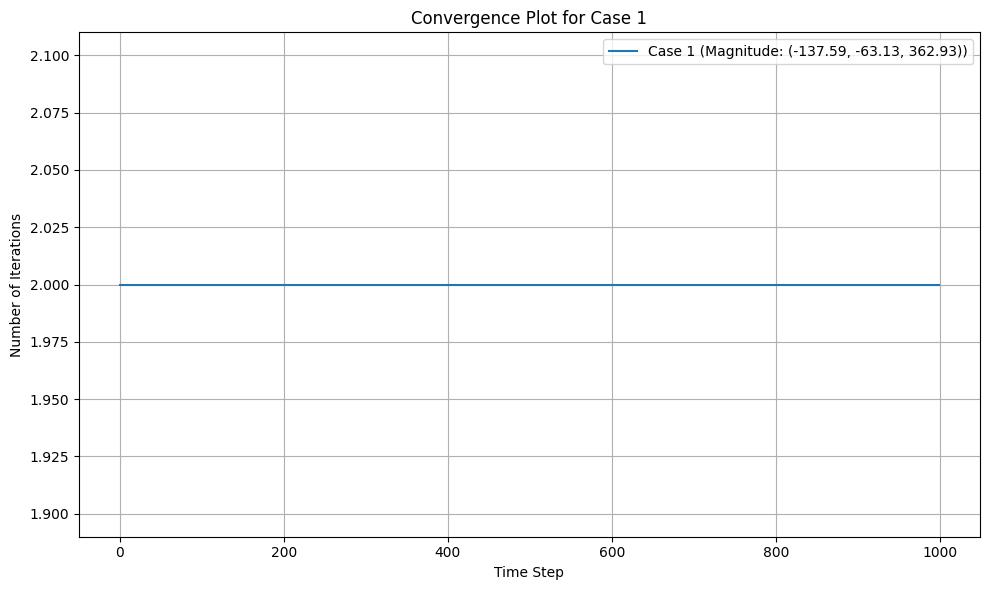

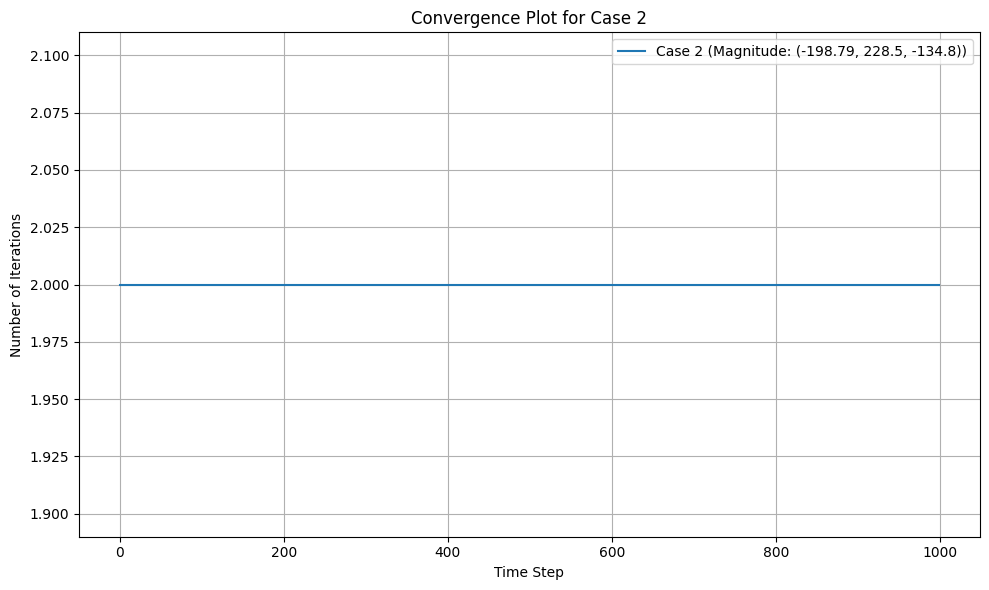

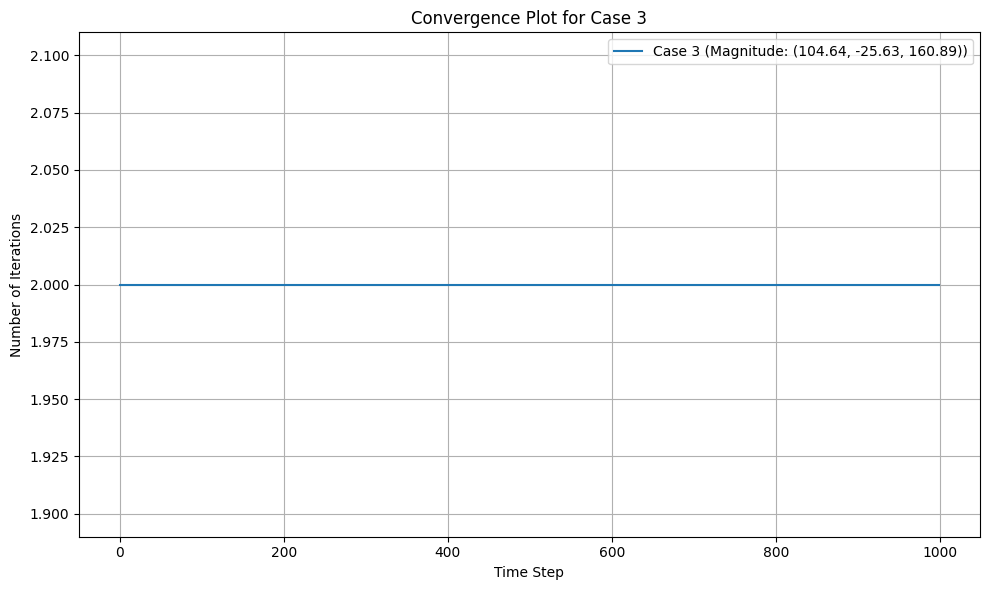

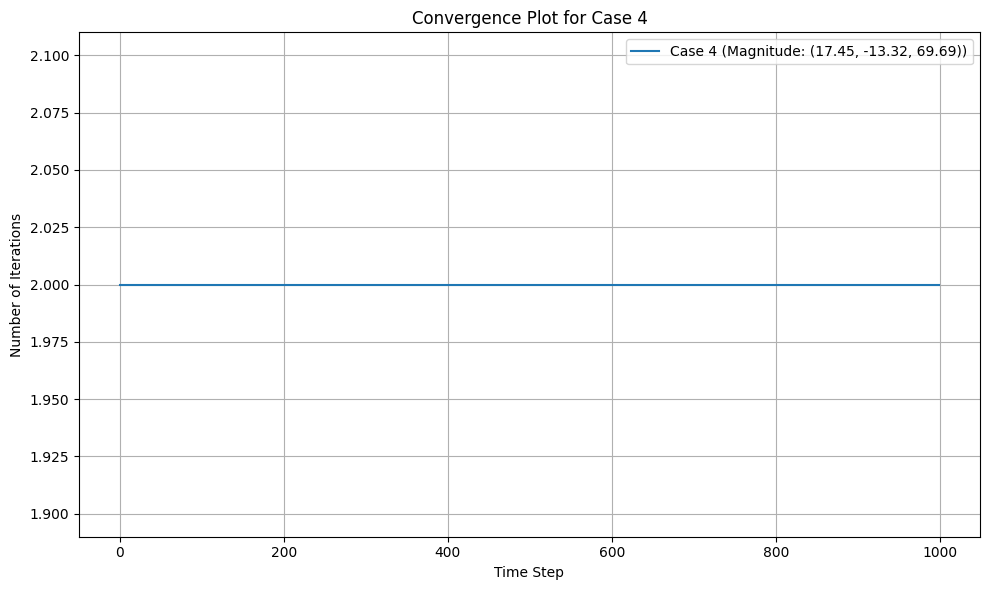

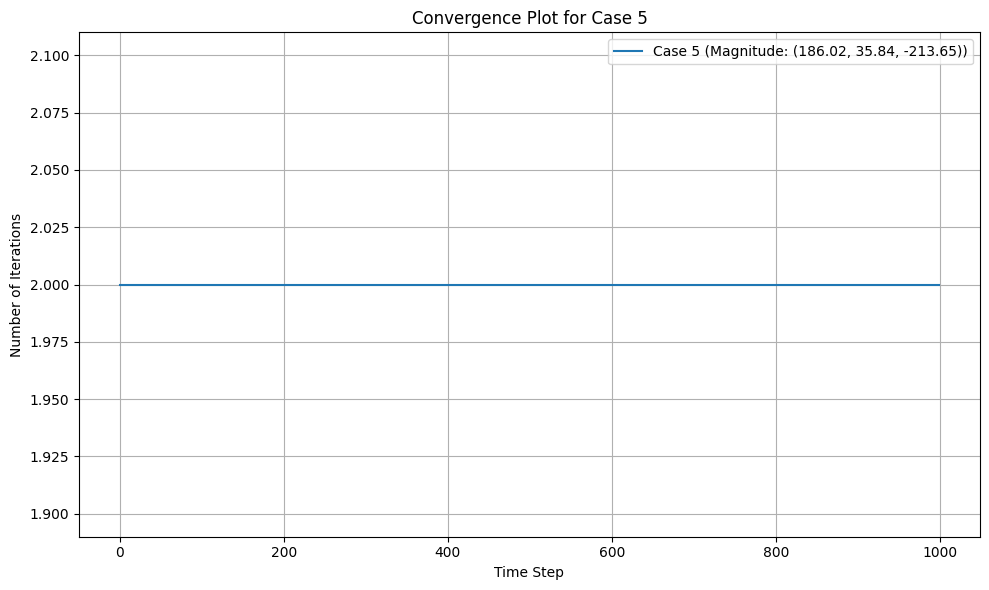

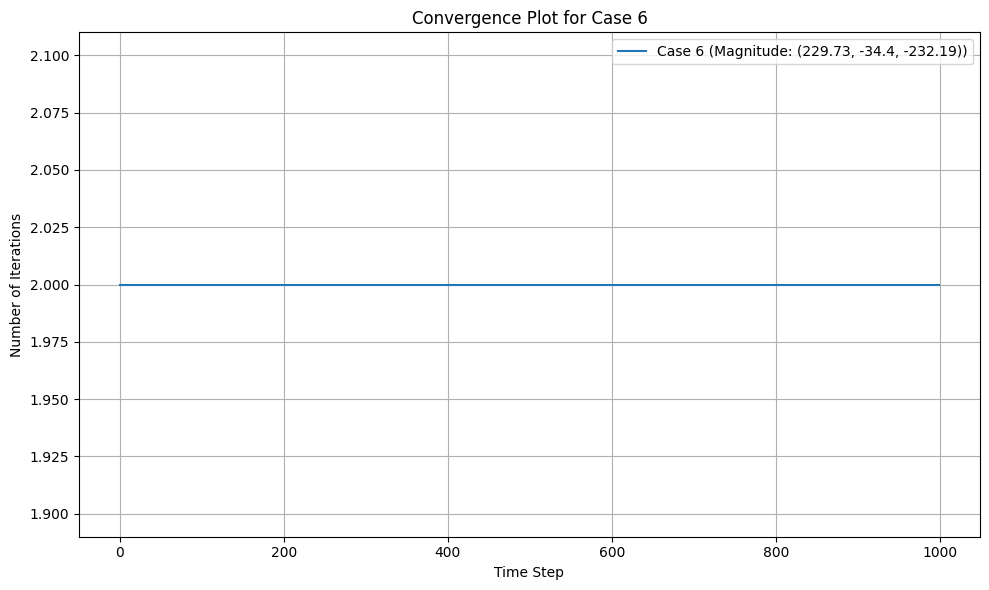

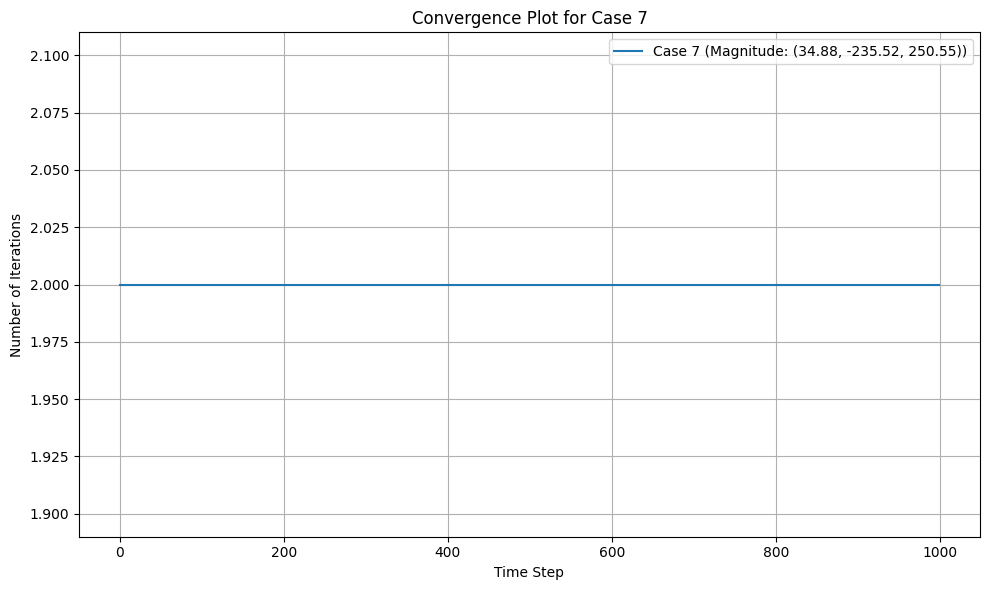

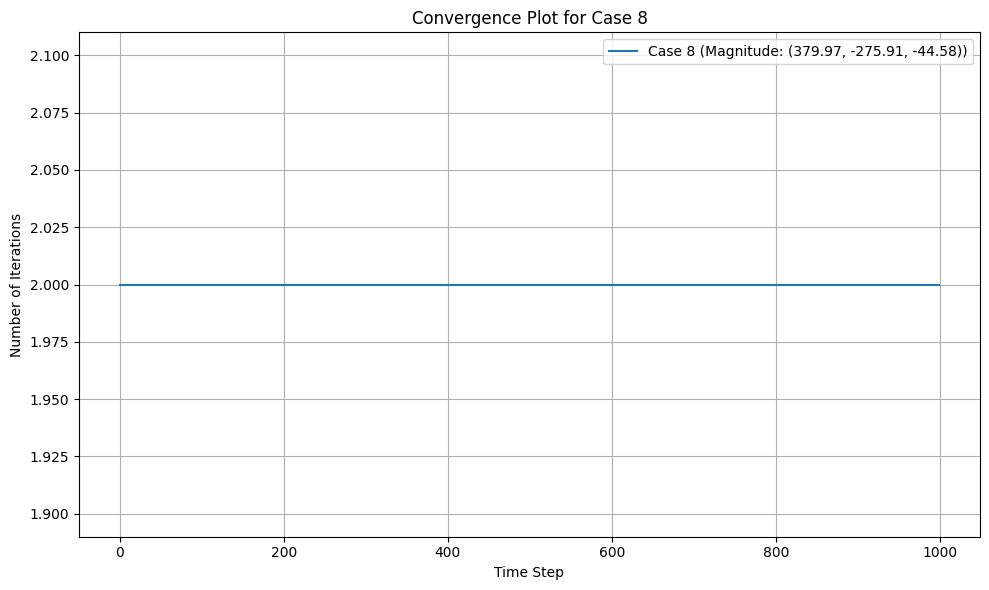

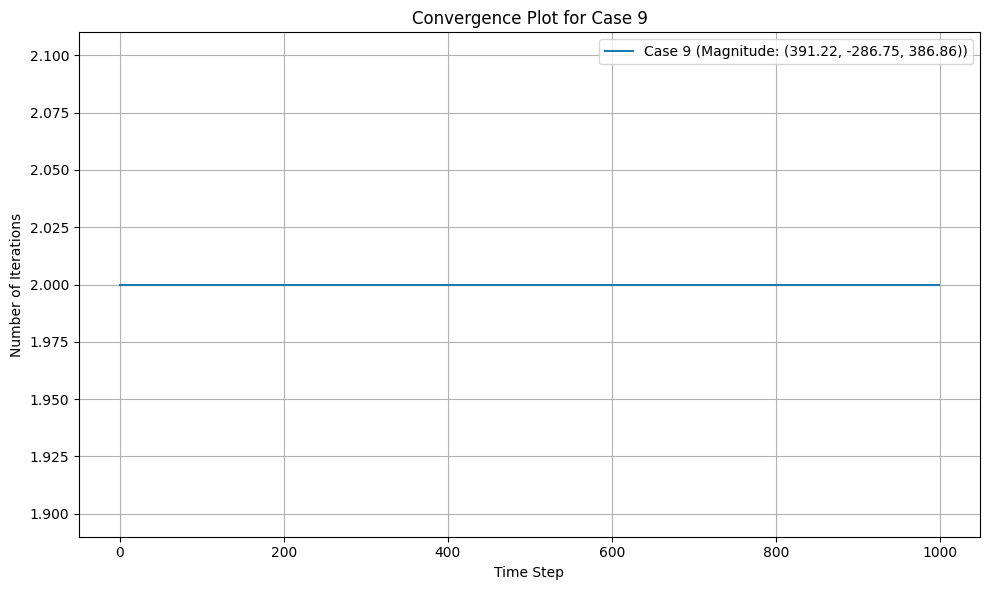

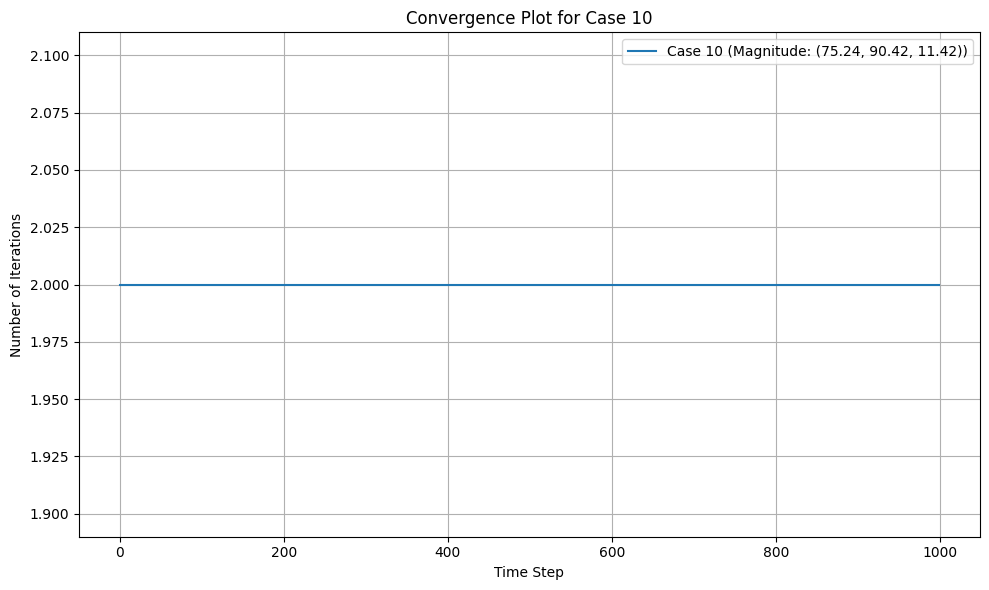

In [ ]:
import matplotlib.pyplot as plt

# Plot convergence for each case
plt.figure(figsize=(10, 6))  # Set default figure size for all plots

for idx, case in enumerate(case_results):
    # Extract iteration data for this case
    iterations = case['iterations_per_step']
    
    # Create a new figure for each case
    plt.figure(figsize=(10, 6))  # 10x6 inch figure
    
    # Plot iterations vs time steps with case-specific label
    plt.plot(range(len(iterations)),  # X-axis: time step indices
             iterations,              # Y-axis: iterations required
             label=f'Case {idx + 1} (Magnitude: {magnitudes[idx]})')  # Legend label
    
    # Add plot labels and title
    plt.xlabel('Time Step')  # X-axis label
    plt.ylabel('Number of Iterations')  # Y-axis label
    plt.title(f'Convergence Plot for Case {idx + 1}')  # Plot title
    
    # Add legend and grid
    plt.legend()  # Show legend with case labels
    plt.grid(True)  # Enable grid for better readability
    
    # Adjust layout to prevent label clipping
    plt.tight_layout()
    
    # Display the plot
    plt.show()

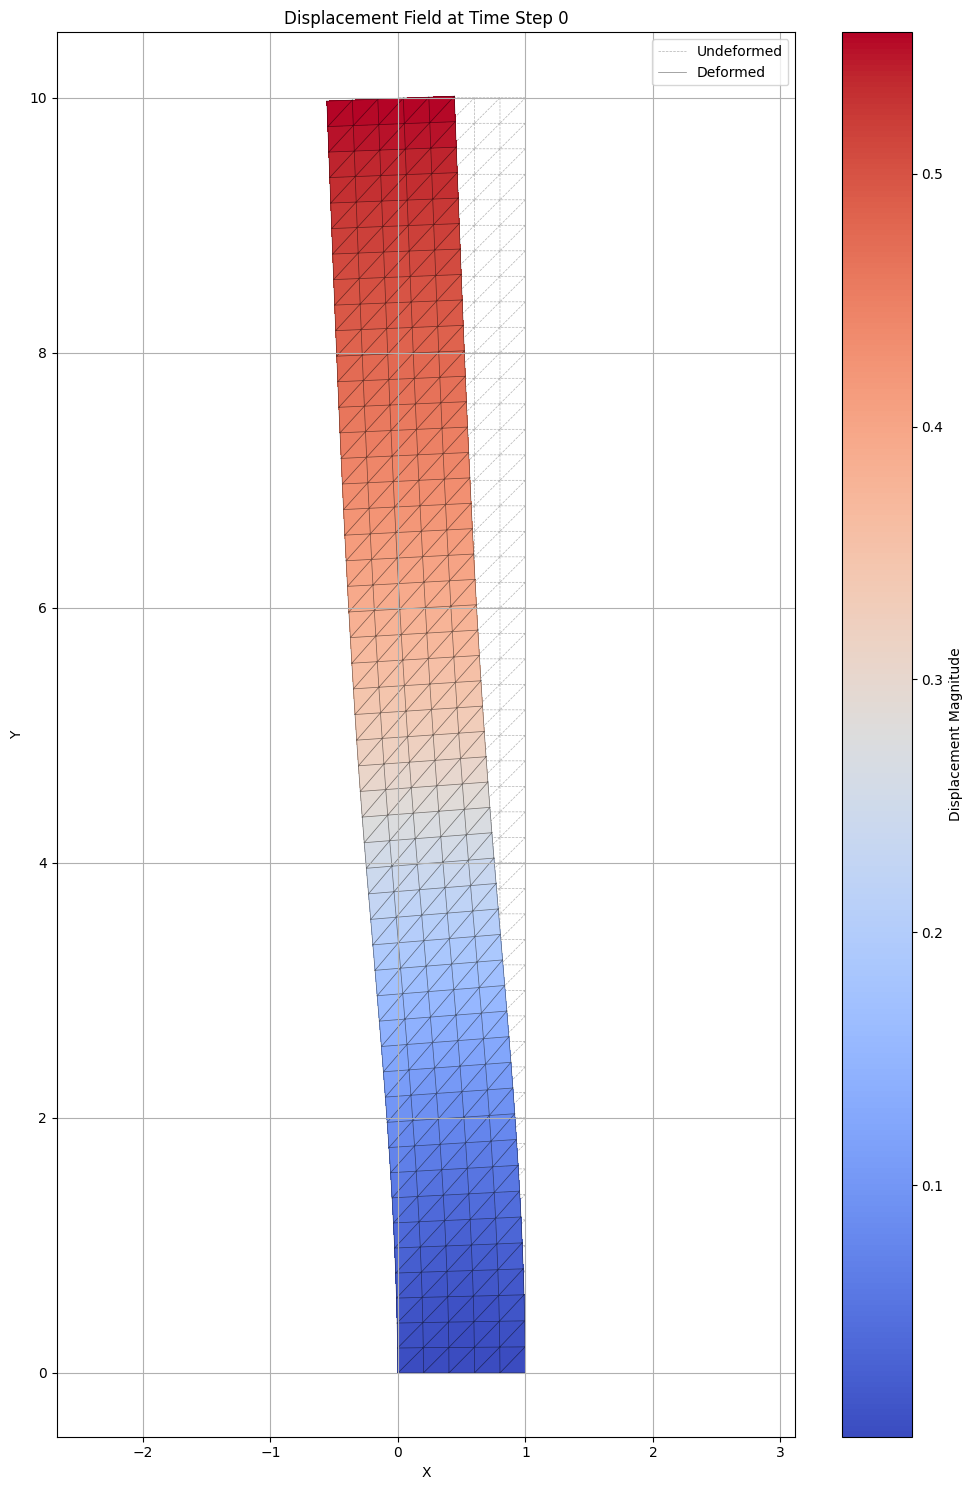


Displacement Statistics:
Maximum displacement magnitude: 5.59e-01
Minimum displacement magnitude: 0.00e+00
Mean displacement magnitude: 2.95e-01


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_displacement_timestep(x_data, time_step, mdpa_file, scale_factor=1e7):
    """
    Plot displacement field for a single time step from FEM simulation results.
    
    Parameters:
    -----------
    x_data: ndarray of shape (612, 5) 
        Displacement data array where each row represents a node 
        and columns represent time steps
    time_step: int 
        Which time step to visualize (column index in x_data)
    mdpa_file: str 
        Path to mdpa file containing mesh information
    scale_factor: float 
        Scaling factor for displacements (to make deformations visible)
    """
    
    # =====================================================================
    # Section 1: Read mesh data from mdpa file
    # =====================================================================
    node_coords = []  # Store node coordinates [x, y]
    elements = []     # Store element connectivity [node1, node2, node3]
    reading_nodes = False
    reading_elements = False
    
    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            
            # Node reading logic
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:  # Ensure we have coordinates
                    # Store x,y coordinates (ignore z if present)
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])
                    
            # Element reading logic
            if "Begin Elements SmallDisplacementElement2D3N" in line:
                reading_elements = True
                continue
            elif reading_elements and "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:  # Ensure we have element nodes
                    # Convert to 0-based indexing and store triangle elements
                    n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                    elements.append([n1, n2, n3])
    
    # Convert to numpy arrays for efficient computation
    node_coords = np.array(node_coords)
    elements = np.array(elements)
    
    # =====================================================================
    # Section 2: Process displacement data
    # =====================================================================
    # Get displacements for specified time step and reshape to (n_nodes, 2)
    displacements = x_data[:, time_step].reshape(-1, 2) * scale_factor
    
    # Calculate displacement magnitude for each node
    disp_mag = np.sqrt(displacements[:, 0]**2 + displacements[:, 1]**2)
    
    # Calculate deformed coordinates (original + scaled displacement)
    deformed_coords = node_coords + displacements
    
    # =====================================================================
    # Section 3: Create visualization
    # =====================================================================
    fig, ax = plt.subplots(figsize=(10, 15))  # Create figure with specified size
    
    # Create triangulation objects for plotting
    triangulation_orig = tri.Triangulation(
        node_coords[:, 0], node_coords[:, 1], elements)
    triangulation_def = tri.Triangulation(
        deformed_coords[:, 0], deformed_coords[:, 1], elements)
    
    # Plot undeformed mesh (dashed lines, semi-transparent)
    ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
    
    # Plot deformed mesh:
    # - tripcolor shows displacement magnitude with colormap
    # - triplot shows element edges
    tcf = ax.tripcolor(triangulation_def, disp_mag, 
                      shading='flat', cmap='coolwarm')
    ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
    
    # Add colorbar for displacement magnitude
    plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
    
    # Configure plot appearance
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Displacement Field at Time Step {time_step}')
    ax.grid(True)
    ax.axis('equal')  # Ensure equal aspect ratio
    ax.legend()
    
    plt.tight_layout()  # Prevent label overlap
    plt.show()
    
    # =====================================================================
    # Section 4: Print displacement statistics
    # =====================================================================
    print("\nDisplacement Statistics:")
    print(f"Maximum displacement magnitude: {np.max(disp_mag):.2e}")
    print(f"Minimum displacement magnitude: {np.min(disp_mag):.2e}")
    print(f"Mean displacement magnitude: {np.mean(disp_mag):.2e}")

# =====================================================================
# Example usage with error handling
# =====================================================================
try:
    # Plot displacement for time step 0 (or change to any desired time step)
    plot_displacement_timestep(
        x_data=x,  # Your displacement data array
        time_step=0,  # Time step index to visualize
        mdpa_file=[file for file in os.listdir() if file.endswith('.mdpa')][0],  # Find first mdpa file
        scale_factor=1e6  # Adjust to make deformations clearly visible
    )
except Exception as e:
    print(f"Error plotting displacement: {str(e)}")
    import traceback
    traceback.print_exc()  # Show full error traceback for debugging

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import os
from pathlib import Path
import sys

def plot_displacement_at_timesteps(case_folder, mdpa_file, output_folder_name="displacement_plots", scale_factor=1e7):
    """
    Plot displacement fields at each timestep and save as image files.
    
    Args:
        case_folder (Path): Path object to the case folder containing solution data
        mdpa_file (str): Path to the .mdpa file containing mesh information
        output_folder_name (str): Name for output directory to store plots
        scale_factor (float): Scaling factor for displacement visualization
        
    Returns:
        bool: True if successful, False if failed
    """
    try:
        # =====================================================================
        # Section 1: Setup output directory and load solution data
        # =====================================================================
        output_folder = case_folder / output_folder_name
        output_folder.mkdir(parents=True, exist_ok=True)  # Create output directory
        
        print(f"\nProcessing: {case_folder.name}")

        # Load time and displacement data from saved numpy files
        time = np.load(case_folder / "FOM_Solution" / "solution" / "time.npy")
        displacement = np.load(case_folder / "FOM_Solution" / "solution" / "displacement.npy")

        print(f"Loaded displacement data shape: {displacement.shape}")
        print(f"Time steps available: {len(time)}")

        # =====================================================================
        # Section 2: Read mesh data from .mdpa file
        # =====================================================================
        node_coords = []  # Store node coordinates [x, y]
        elements = []     # Store element connectivity [node1, node2, node3]
        reading_nodes = False
        reading_elements = False

        with open(mdpa_file, 'r') as file:
            for line in file:
                line = line.strip()

                # Node reading logic
                if "Begin Nodes" in line:
                    reading_nodes = True
                    continue
                elif "End Nodes" in line:
                    reading_nodes = False
                    continue
                elif reading_nodes and line:
                    parts = line.split()
                    if len(parts) >= 4:  # Ensure we have coordinates
                        x, y = float(parts[1]), float(parts[2])
                        node_coords.append([x, y])

                # Element reading logic (specific to 2D triangular elements)
                if "Begin Elements SmallDisplacementElement2D3N" in line:
                    reading_elements = True
                    continue
                elif reading_elements and "End Elements" in line:
                    reading_elements = False
                    continue
                elif reading_elements and line:
                    parts = line.split()
                    if len(parts) >= 5:  # Ensure we have element nodes
                        # Convert to 0-based indexing
                        n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                        elements.append([n1, n2, n3])

        # Convert to numpy arrays for vectorized operations
        node_coords = np.array(node_coords)
        elements = np.array(elements)

        # =====================================================================
        # Section 3: Prepare visualization parameters
        # =====================================================================
        # Create triangulation for undeformed mesh
        triangulation_orig = tri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)

        # Calculate global displacement limits for consistent color scaling across all frames
        disp_magnitudes = []
        for step in range(len(time)):
            disp = displacement[step].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            disp_magnitudes.append(disp_mag)

        global_min = min(np.min(mag) for mag in disp_magnitudes)
        global_max = max(np.max(mag) for mag in disp_magnitudes)

        print(f"\nPlotting Information:")
        print(f"Total plots: {len(time)}")
        print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
        print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")

        # =====================================================================
        # Section 4: Generate and save plots for each timestep
        # =====================================================================
        for frame in range(len(time)):
            # Get and scale displacements for current frame
            disp = displacement[frame].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            
            # Calculate deformed coordinates
            deformed_coords = node_coords + disp

            # Create figure
            fig, ax = plt.subplots(figsize=(10, 15))

            # Plot undeformed mesh (reference configuration)
            ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')

            # Create and plot deformed mesh with displacement coloring
            triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
            tcf = ax.tripcolor(triangulation_def, disp_mag, 
                              shading='flat', cmap='coolwarm',
                              vmin=global_min, vmax=global_max)
            ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

            # Configure plot appearance
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            ax.grid(True)
            ax.axis('equal')  # Maintain aspect ratio
            ax.legend()

            # Add colorbar (only for first frame to save space)
            if frame == 0:
                plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')

            plt.tight_layout()

            # Save plot with zero-padded frame number
            output_file = output_folder / f"displacement_frame_{frame:04d}.png"
            plt.savefig(output_file, dpi=150)
            plt.close(fig)  # Close figure to free memory

            # Print progress every 10 frames
            if frame % 10 == 0:
                print(f"Processed and saved plot for frame {frame}/{len(time)-1}")

        print("\nAll plots completed and saved!")
        return True

    except Exception as e:
        print(f"\nError processing {case_folder.name}: {str(e)}")
        return False

def process_all_cases(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e7, num_files=None):
    """
    Process all case folders in the specified directory.
    
    Args:
        base_dir (str): Root directory containing case folders
        mdpa_file (str): Path to mesh definition file
        scale_factor (float): Scaling factor for displacement visualization
        num_files (int/None): Number of cases to process (None for all)
    """
    base_path = Path(base_dir)

    # Find all case folders matching pattern "case_*_magnitude_*"
    case_folders = list(base_path.glob("case_*_magnitude_*"))

    # Sort cases numerically by their case number
    def extract_case_number(folder_name):
        """Helper to extract case number from folder name (e.g., 'case_1_magnitude_0.1' -> 1)"""
        return int(folder_name.name.split("_")[1])

    case_folders.sort(key=extract_case_number)
    
    total_cases = len(case_folders)
    
    # Handle user input for number of cases to process
    if num_files is None:
        try:
            user_input = input(f"\nFound {total_cases} case folders. How many would you like to process? (Enter 'all' for all folders): ")
            if user_input.lower() == 'all':
                num_files = total_cases
            else:
                num_files = int(user_input)
                if num_files <= 0 or num_files > total_cases:
                    print(f"Invalid number. Using all {total_cases} files.")
                    num_files = total_cases
        except ValueError:
            print(f"Invalid input. Processing all {total_cases} files.")
            num_files = total_cases
    else:
        # Validate num_files parameter
        num_files = min(max(1, num_files), total_cases)
    
    # Limit to requested number of cases
    case_folders = case_folders[:num_files]
    
    print(f"\nWill process {len(case_folders)} of {total_cases} cases")
    print("\nProcessing order:")
    for folder in case_folders:
        print(f"  {folder.name}")

    # Process each case and track success/failure
    successful = 0
    failed = 0

    for folder in case_folders:
        print("\n" + "=" * 50)
        print(f"Processing {folder.name}")
        print("=" * 50)

        if plot_displacement_at_timesteps(folder, mdpa_file, scale_factor=scale_factor):
            successful += 1
        else:
            failed += 1

    # Print final summary
    print("\n" + "=" * 50)
    print("Processing Complete!")
    print(f"Successfully processed: {successful} cases")
    print(f"Failed to process: {failed} cases")
    print(f"Skipped: {total_cases - num_files} cases")
    print("=" * 50)

def run_processing(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e6, num_files=None):
    """
    Wrapper function for Jupyter notebook compatibility.
    
    Args:
        base_dir (str): Root directory containing case folders  
        mdpa_file (str): Path to mesh definition file
        scale_factor (float): Scaling factor for displacements
        num_files (int/None): Number of cases to process
    """
    try:
        process_all_cases(
            base_dir=base_dir,
            mdpa_file=mdpa_file,
            scale_factor=scale_factor,
            num_files=num_files
        )
    except Exception as e:
        print(f"\nError in execution: {str(e)}")
        import traceback
        traceback.print_exc()

# Entry point for script execution
if __name__ == "__main__":
    # Run with default parameters when executed directly
    run_processing()


Will process 1 of 10 cases

Processing order:
  case_1_magnitude_(-137.59, -63.13, 362.93)

Processing case_1_magnitude_(-137.59, -63.13, 362.93)

Processing: case_1_magnitude_(-137.59, -63.13, 362.93)
Loaded displacement data shape: (1001, 612)
Time steps available: 1001

Plotting Information:
Total plots: 1001
Time range: [0.000, 1.000] seconds
Global displacement range: [0.00e+00, 8.95e+00]
Processed and saved plot for frame 0/1000
Processed and saved plot for frame 10/1000
Processed and saved plot for frame 20/1000
Processed and saved plot for frame 30/1000
Processed and saved plot for frame 40/1000
Processed and saved plot for frame 50/1000
Processed and saved plot for frame 60/1000
Processed and saved plot for frame 70/1000
Processed and saved plot for frame 80/1000
Processed and saved plot for frame 90/1000
Processed and saved plot for frame 100/1000
Processed and saved plot for frame 110/1000
Processed and saved plot for frame 120/1000
Processed and saved plot for frame 130/10

C:\Users\shrey\AppData\Local\Temp\ipykernel_25784\2868411761.py:141: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(output_file, dpi=150)


Processed and saved plot for frame 770/1000
Processed and saved plot for frame 780/1000
Processed and saved plot for frame 790/1000
Processed and saved plot for frame 800/1000
Processed and saved plot for frame 810/1000
Processed and saved plot for frame 820/1000
Processed and saved plot for frame 830/1000
Processed and saved plot for frame 840/1000
Processed and saved plot for frame 850/1000
Processed and saved plot for frame 860/1000
Processed and saved plot for frame 870/1000
Processed and saved plot for frame 880/1000
Processed and saved plot for frame 890/1000
Processed and saved plot for frame 900/1000
Processed and saved plot for frame 910/1000
Processed and saved plot for frame 920/1000
Processed and saved plot for frame 930/1000
Processed and saved plot for frame 940/1000
Processed and saved plot for frame 950/1000
Processed and saved plot for frame 960/1000
Processed and saved plot for frame 970/1000
Processed and saved plot for frame 980/1000
Processed and saved plot for fra

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from pathlib import Path

def create_displacement_animation(case_folder, mdpa_file, scale_factor=1e7, step_interval=100):
    """
    Create an animated GIF showing the displacement field evolution over time.
    
    Parameters:
    -----------
    case_folder: Path 
        Path object pointing to the case folder containing solution data
    mdpa_file: str 
        Path to the .mdpa file containing mesh definition
    scale_factor: float 
        Scaling factor to amplify displacements for better visualization
    step_interval: int 
        Time in milliseconds between animation frames
    
    Returns:
    --------
    bool: True if successful, False if failed
    """
    try:
        # =====================================================================
        # Section 1: Initialization and Data Loading
        # =====================================================================
        # Set output filename based on case folder name
        output_file = case_folder / 'displacement_animation_scaled.gif'
        
        print(f"\nProcessing: {case_folder.name}")
        
        # Load time history and displacement data from saved numpy files
        time = np.load(case_folder / "solution" / "time.npy")
        displacement = np.load(case_folder / "solution" / "displacement.npy")
        
        print(f"Loaded displacement data shape: {displacement.shape}")
        print(f"Time steps available: {len(time)}")
        
        # =====================================================================
        # Section 2: Mesh Data Processing
        # =====================================================================
        node_coords = []  # Store node coordinates [x, y]
        elements = []     # Store element connectivity [node1, node2, node3]
        reading_nodes = False
        reading_elements = False
        
        # Parse the .mdpa file to extract mesh information
        with open(mdpa_file, 'r') as file:
            for line in file:
                line = line.strip()
                
                # Node data section
                if "Begin Nodes" in line:
                    reading_nodes = True
                    continue
                elif "End Nodes" in line:
                    reading_nodes = False
                    continue
                elif reading_nodes and line:
                    parts = line.split()
                    if len(parts) >= 4:  # Ensure we have coordinates
                        x, y = float(parts[1]), float(parts[2])
                        node_coords.append([x, y])
                        
                # Element data section (specific to 2D triangular elements)
                if "Begin Elements SmallDisplacementElement2D3N" in line:
                    reading_elements = True
                    continue
                elif reading_elements and "End Elements" in line:
                    reading_elements = False
                    continue
                elif reading_elements and line:
                    parts = line.split()
                    if len(parts) >= 5:  # Ensure we have element nodes
                        # Convert to 0-based indexing
                        n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                        elements.append([n1, n2, n3])
        
        # Convert to numpy arrays for efficient computation
        node_coords = np.array(node_coords)
        elements = np.array(elements)
        
        # =====================================================================
        # Section 3: Animation Setup
        # =====================================================================
        # Create figure with specified size
        fig, ax = plt.subplots(figsize=(10, 15))
        
        # Create base triangulation for undeformed mesh
        triangulation_orig = tri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)
        
        # Calculate global displacement limits for consistent color scaling
        disp_magnitudes = []
        for step in range(len(time)):
            disp = displacement[step].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            disp_magnitudes.append(disp_mag)
        
        global_min = min(np.min(mag) for mag in disp_magnitudes)
        global_max = max(np.max(mag) for mag in disp_magnitudes)
        
        print(f"\nAnimation Information:")
        print(f"Total frames: {len(time)}")
        print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
        print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")
        
        # =====================================================================
        # Section 4: Animation Frame Update Function
        # =====================================================================
        def update(frame):
            """Update function called for each animation frame."""
            ax.clear()  # Clear previous frame
            
            # Get and scale displacements for current frame
            disp = displacement[frame].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            
            # Calculate deformed coordinates
            deformed_coords = node_coords + disp
            
            # Plot undeformed mesh (reference configuration)
            ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
            
            # Create and plot deformed mesh with displacement coloring
            triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
            tcf = ax.tripcolor(triangulation_def, disp_mag, 
                             shading='flat', cmap='coolwarm',
                             vmin=global_min, vmax=global_max)
            ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
            
            # Configure plot appearance
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            ax.grid(True)
            ax.axis('equal')  # Maintain aspect ratio
            ax.legend()
            
            # Add colorbar only for first frame (to save space)
            if frame == 0:
                plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
            
            plt.tight_layout()
            
            # Print progress every 10 frames
            if frame % 10 == 0:
                print(f"Processing frame {frame}/{len(time)-1}")
        
        # =====================================================================
        # Section 5: Animation Creation and Saving
        # =====================================================================
        print("\nCreating animation...")
        # Create animation using FuncAnimation
        anim = FuncAnimation(
            fig, 
            update, 
            frames=len(time), 
            interval=step_interval  # Time between frames in ms
        )
        
        # Configure GIF writer
        print(f"\nSaving animation to {output_file}")
        writer = PillowWriter(fps=1000/step_interval)  # Convert interval to FPS
        
        # Save animation as GIF
        anim.save(output_file, writer=writer)
        
        plt.close()  # Close figure to free memory
        print("\nAnimation completed!")
        
        return True
        
    except Exception as e:
        print(f"\nError processing {case_folder.name}: {str(e)}")
        return False

def get_case_folders(base_dir="Dynamic_solution"):
    """
    Scan the base directory and return sorted list of case folders.
    
    Args:
        base_dir: Path to directory containing case folders
    
    Returns:
        List of Path objects sorted by case number
    """
    base_path = Path(base_dir)
    
    # Find all folders matching pattern "case_*_magnitude_*"
    case_folders = list(base_path.glob("case_*_magnitude_*"))
    
    # Sort folders numerically by case number
    def extract_case_number(folder_name):
        """Helper to extract case number from folder name."""
        return int(folder_name.name.split("_")[1])
    
    case_folders.sort(key=extract_case_number)
    return case_folders

def user_select_cases(case_folders):
    """
    Interactive prompt for user to select which cases to process.
    
    Args:
        case_folders: List of available case folders
    
    Returns:
        List of selected case folders
    """
    print("\nAvailable case folders:")
    for i, folder in enumerate(case_folders, 1):
        print(f"{i}. {folder.name}")
    
    while True:
        try:
            user_input = input("\nEnter case numbers to process (comma-separated, e.g., '1,3,5' or 'all' for all cases): ")
            
            if user_input.lower() == 'all':
                print("Processing all cases.")
                return case_folders
            
            # Parse user input
            selected_indices = [int(x.strip()) for x in user_input.split(',')]
            
            # Validate indices
            if any(idx < 1 or idx > len(case_folders) for idx in selected_indices):
                print(f"Error: Please enter valid case numbers between 1 and {len(case_folders)}")
                continue
            
            # Return selected folders
            selected_folders = [case_folders[idx-1] for idx in selected_indices]
            
            print(f"\nSelected {len(selected_folders)} cases to process:")
            for folder in selected_folders:
                print(f"  {folder.name}")
            
            return selected_folders
            
        except ValueError:
            print("Error: Please enter valid numbers separated by commas.")
        except Exception as e:
            print(f"Error: {str(e)}")

def process_selected_cases(selected_folders, mdpa_file, scale_factor=1e6):
    """
    Process user-selected cases and generate animations.
    
    Args:
        selected_folders: List of case folders to process
        mdpa_file: Path to mesh definition file
        scale_factor: Scaling factor for displacements
    """
    successful = 0
    failed = 0
    
    for folder in selected_folders:
        print("\n" + "="*50)
        print(f"Processing {folder.name}")
        print("="*50)
        
        # Check for FOM_Solution subfolder
        solution_folder = folder / "FOM_Solution"
        
        if solution_folder.exists():
            if create_displacement_animation(solution_folder, mdpa_file, scale_factor):
                successful += 1
            else:
                failed += 1
        else:
            print(f"Error: FOM_Solution folder not found in {folder.name}")
            failed += 1
    
    # Print final summary
    print("\n" + "="*50)
    print("Processing Complete!")
    print(f"Successfully processed: {successful} cases")
    print(f"Failed to process: {failed} cases")
    print("="*50)

# Main execution block
if __name__ == "__main__":
    try:
        base_dir = "Dynamic_solution"
        
        # Locate .mdpa file in current directory
        mdpa_files = [file for file in os.listdir() if file.endswith('.mdpa')]
        if not mdpa_files:
            print("Error: No .mdpa files found in the current directory.")
            exit(1)
        mdpa_file = mdpa_files[0]  # Use first found .mdpa file
        
        # Get available case folders
        case_folders = get_case_folders(base_dir)
        
        if not case_folders:
            print(f"Error: No case folders found in {base_dir}.")
            exit(1)
        
        print(f"\nFound {len(case_folders)} total cases")
        
        # Get user selection
        selected_folders = user_select_cases(case_folders)
        
        # Set visualization scale factor (same as original code)
        scale_factor = 1e6
        
        # Process selected cases
        process_selected_cases(selected_folders, mdpa_file, scale_factor)
        
    except Exception as e:
        print(f"\nError in main execution: {str(e)}")
        import traceback
        traceback.print_exc()


Found 10 total cases

Available case folders:
1. case_1_magnitude_(-137.59, -63.13, 362.93)
2. case_2_magnitude_(-198.79, 228.5, -134.8)
3. case_3_magnitude_(104.64, -25.63, 160.89)
4. case_4_magnitude_(17.45, -13.32, 69.69)
5. case_5_magnitude_(186.02, 35.84, -213.65)
6. case_6_magnitude_(229.73, -34.4, -232.19)
7. case_7_magnitude_(34.88, -235.52, 250.55)
8. case_8_magnitude_(379.97, -275.91, -44.58)
9. case_9_magnitude_(391.22, -286.75, 386.86)
10. case_10_magnitude_(75.24, 90.42, 11.42)

Selected 1 cases to process:
  case_1_magnitude_(-137.59, -63.13, 362.93)

Processing case_1_magnitude_(-137.59, -63.13, 362.93)

Processing: FOM_Solution
Loaded displacement data shape: (1001, 612)
Time steps available: 1001

Animation Information:
Total frames: 1001
Time range: [0.000, 1.000] seconds
Global displacement range: [0.00e+00, 8.95e+00]

Creating animation...

Saving animation to Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\FOM_Solution\displacement_animation_scaled.gif

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from pathlib import Path

def create_displacement_animation(case_folder, mdpa_file, scale_factor=1e7, step_interval=100):
    """
    Create an animated GIF showing the displacement field evolution over time.
    
    Parameters:
    -----------
    case_folder: Path 
        Path object pointing to the case folder containing solution data
    mdpa_file: str 
        Path to the .mdpa file containing mesh definition
    scale_factor: float 
        Scaling factor to amplify displacements for better visualization
    step_interval: int 
        Time in milliseconds between animation frames
    
    Returns:
    --------
    bool: True if successful, False if failed
    """
    try:
        # =====================================================================
        # Section 1: Initialization and Data Loading
        # =====================================================================
        # Set output filename based on case folder name
        output_file = case_folder / 'displacement_animation.gif'
        
        print(f"\nProcessing: {case_folder.name}")
        
        # Load time history and displacement data from saved numpy files
        time = np.load(case_folder / "solution" / "time.npy")
        displacement = np.load(case_folder / "solution" / "displacement.npy")
        
        print(f"Loaded displacement data shape: {displacement.shape}")
        print(f"Time steps available: {len(time)}")
        
        # =====================================================================
        # Section 2: Mesh Data Processing
        # =====================================================================
        node_coords = []  # Store node coordinates [x, y]
        elements = []     # Store element connectivity [node1, node2, node3]
        reading_nodes = False
        reading_elements = False
        
        # Parse the .mdpa file to extract mesh information
        with open(mdpa_file, 'r') as file:
            for line in file:
                line = line.strip()
                
                # Node data section
                if "Begin Nodes" in line:
                    reading_nodes = True
                    continue
                elif "End Nodes" in line:
                    reading_nodes = False
                    continue
                elif reading_nodes and line:
                    parts = line.split()
                    if len(parts) >= 4:  # Ensure we have coordinates
                        x, y = float(parts[1]), float(parts[2])
                        node_coords.append([x, y])
                        
                # Element data section (specific to 2D triangular elements)
                if "Begin Elements SmallDisplacementElement2D3N" in line:
                    reading_elements = True
                    continue
                elif reading_elements and "End Elements" in line:
                    reading_elements = False
                    continue
                elif reading_elements and line:
                    parts = line.split()
                    if len(parts) >= 5:  # Ensure we have element nodes
                        # Convert to 0-based indexing
                        n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                        elements.append([n1, n2, n3])
        
        # Convert to numpy arrays for efficient computation
        node_coords = np.array(node_coords)
        elements = np.array(elements)
        
        # =====================================================================
        # Section 3: Animation Setup
        # =====================================================================
        # Create figure with specified size
        fig, ax = plt.subplots(figsize=(10, 15))
        
        # Create base triangulation for undeformed mesh
        triangulation_orig = tri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)
        
        # Calculate global displacement limits for consistent color scaling
        disp_magnitudes = []
        for step in range(len(time)):
            disp = displacement[step].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            disp_magnitudes.append(disp_mag)
        
        global_min = min(np.min(mag) for mag in disp_magnitudes)
        global_max = max(np.max(mag) for mag in disp_magnitudes)
        
        print(f"\nAnimation Information:")
        print(f"Total frames: {len(time)}")
        print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
        print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")
        
        # =====================================================================
        # Section 4: Animation Frame Update Function
        # =====================================================================
        def update(frame):
            """Update function called for each animation frame."""
            ax.clear()  # Clear previous frame
            
            # Get and scale displacements for current frame
            disp = displacement[frame].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            
            # Calculate deformed coordinates
            deformed_coords = node_coords + disp
            
            # Plot undeformed mesh (reference configuration)
            ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
            
            # Create and plot deformed mesh with displacement coloring
            triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
            tcf = ax.tripcolor(triangulation_def, disp_mag, 
                             shading='flat', cmap='coolwarm',
                             vmin=global_min, vmax=global_max)
            ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
            
            # Configure plot appearance
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            ax.grid(True)
            ax.axis('equal')  # Maintain aspect ratio
            ax.legend()
            
            # Add colorbar only for first frame (to save space)
            if frame == 0:
                plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
            
            plt.tight_layout()
            
            # Print progress every 10 frames
            if frame % 10 == 0:
                print(f"Processing frame {frame}/{len(time)-1}")
        
        # =====================================================================
        # Section 5: Animation Creation and Saving
        # =====================================================================
        print("\nCreating animation...")
        # Create animation using FuncAnimation
        anim = FuncAnimation(
            fig, 
            update, 
            frames=len(time), 
            interval=step_interval  # Time between frames in ms
        )
        
        # Configure GIF writer
        print(f"\nSaving animation to {output_file}")
        writer = PillowWriter(fps=1000/step_interval)  # Convert interval to FPS
        
        # Save animation as GIF
        anim.save(output_file, writer=writer)
        
        plt.close()  # Close figure to free memory
        print("\nAnimation completed!")
        
        return True
        
    except Exception as e:
        print(f"\nError processing {case_folder.name}: {str(e)}")
        return False

def get_case_folders(base_dir="Dynamic_solution"):
    """
    Scan the base directory and return sorted list of case folders.
    
    Args:
        base_dir: Path to directory containing case folders
    
    Returns:
        List of Path objects sorted by case number
    """
    base_path = Path(base_dir)
    
    # Find all folders matching pattern "case_*_magnitude_*"
    case_folders = list(base_path.glob("case_*_magnitude_*"))
    
    # Sort folders numerically by case number
    def extract_case_number(folder_name):
        """Helper to extract case number from folder name."""
        return int(folder_name.name.split("_")[1])
    
    case_folders.sort(key=extract_case_number)
    return case_folders

def user_select_cases(case_folders):
    """
    Interactive prompt for user to select which cases to process.
    
    Args:
        case_folders: List of available case folders
    
    Returns:
        List of selected case folders
    """
    print("\nAvailable case folders:")
    for i, folder in enumerate(case_folders, 1):
        print(f"{i}. {folder.name}")
    
    while True:
        try:
            user_input = input("\nEnter case numbers to process (comma-separated, e.g., '1,3,5' or 'all' for all cases): ")
            
            if user_input.lower() == 'all':
                print("Processing all cases.")
                return case_folders
            
            # Parse user input
            selected_indices = [int(x.strip()) for x in user_input.split(',')]
            
            # Validate indices
            if any(idx < 1 or idx > len(case_folders) for idx in selected_indices):
                print(f"Error: Please enter valid case numbers between 1 and {len(case_folders)}")
                continue
            
            # Return selected folders
            selected_folders = [case_folders[idx-1] for idx in selected_indices]
            
            print(f"\nSelected {len(selected_folders)} cases to process:")
            for folder in selected_folders:
                print(f"  {folder.name}")
            
            return selected_folders
            
        except ValueError:
            print("Error: Please enter valid numbers separated by commas.")
        except Exception as e:
            print(f"Error: {str(e)}")

def process_selected_cases(selected_folders, mdpa_file, scale_factor=1e6):
    """
    Process user-selected cases and generate animations.
    
    Args:
        selected_folders: List of case folders to process
        mdpa_file: Path to mesh definition file
        scale_factor: Scaling factor for displacements
    """
    successful = 0
    failed = 0
    
    for folder in selected_folders:
        print("\n" + "="*50)
        print(f"Processing {folder.name}")
        print("="*50)
        
        # Check for FOM_Solution subfolder
        solution_folder = folder / "FOM_Solution"
        
        if solution_folder.exists():
            if create_displacement_animation(solution_folder, mdpa_file, scale_factor):
                successful += 1
            else:
                failed += 1
        else:
            print(f"Error: FOM_Solution folder not found in {folder.name}")
            failed += 1
    
    # Print final summary
    print("\n" + "="*50)
    print("Processing Complete!")
    print(f"Successfully processed: {successful} cases")
    print(f"Failed to process: {failed} cases")
    print("="*50)

# Main execution block
if __name__ == "__main__":
    try:
        base_dir = "Dynamic_solution"
        
        # Locate .mdpa file in current directory
        mdpa_files = [file for file in os.listdir() if file.endswith('.mdpa')]
        if not mdpa_files:
            print("Error: No .mdpa files found in the current directory.")
            exit(1)
        mdpa_file = mdpa_files[0]  # Use first found .mdpa file
        
        # Get available case folders
        case_folders = get_case_folders(base_dir)
        
        if not case_folders:
            print(f"Error: No case folders found in {base_dir}.")
            exit(1)
        
        print(f"\nFound {len(case_folders)} total cases")
        
        # Get user selection
        selected_folders = user_select_cases(case_folders)
        
        # Set visualization scale factor (same as original code)
        scale_factor = 1
        
        # Process selected cases
        process_selected_cases(selected_folders, mdpa_file, scale_factor)
        
    except Exception as e:
        print(f"\nError in main execution: {str(e)}")
        import traceback
        traceback.print_exc()


Found 10 total cases

Available case folders:
1. case_1_magnitude_(-137.59, -63.13, 362.93)
2. case_2_magnitude_(-198.79, 228.5, -134.8)
3. case_3_magnitude_(104.64, -25.63, 160.89)
4. case_4_magnitude_(17.45, -13.32, 69.69)
5. case_5_magnitude_(186.02, 35.84, -213.65)
6. case_6_magnitude_(229.73, -34.4, -232.19)
7. case_7_magnitude_(34.88, -235.52, 250.55)
8. case_8_magnitude_(379.97, -275.91, -44.58)
9. case_9_magnitude_(391.22, -286.75, 386.86)
10. case_10_magnitude_(75.24, 90.42, 11.42)

Selected 1 cases to process:
  case_1_magnitude_(-137.59, -63.13, 362.93)

Processing case_1_magnitude_(-137.59, -63.13, 362.93)

Processing: FOM_Solution
Loaded displacement data shape: (1001, 612)
Time steps available: 1001

Animation Information:
Total frames: 1001
Time range: [0.000, 1.000] seconds
Global displacement range: [0.00e+00, 8.95e-06]

Creating animation...

Saving animation to Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\FOM_Solution\displacement_animation.gif
Proces

# ============================================================
# Time Integration Using solve_ivp
# ============================================================
#
# This section explains the use of SciPy's solve_ivp function 
# to perform time integration of the reduced-order system.
#
# The main objectives of using solve_ivp are:
# - Integrate the system of Ordinary Differential Equations (ODEs)
# - Track the evolution of the reduced variables over time
# - Reconstruct the full-order approximation at each time step
#
# The procedure includes:
# - Define the ODE system representing the ROM dynamics
# - Configure the solver parameters (method, tolerances, time span)
# - Call solve_ivp to integrate the system from initial conditions
# - Extract and post-process the time history of the reduced solution
#
# Key solver options typically include:
# - Method: 'Radau'
# - Tolerances: rtol (relative) and atol (absolute) error controls
# - Dense output option for continuous-time solution interpolation
#
# ============================================================
# The following code cells will implement time integration using solve_ivp.
# ============================================================


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
from tqdm import tqdm
from pathlib import Path
from tabulate import tabulate


s = f_constrained.shape[0]
num_cases = f_constrained.shape[1]

def constant_force_factory(F):
    return lambda t: F

# Initial velocity and identity/zero matrices
v0 = np.zeros((s, num_cases))
I = np.eye(s)
Z = np.zeros((s, s))

# Combined matrices for state-space formulation
M_star = np.block([[M_constrained, Z], [Z, I]])
K_star = np.block([[Z, K_constrained], [-I, Z]])
M_star_inv = np.linalg.inv(M_star)

# Time settings
total_time = 1.0
dt = 1e-3
t_span = (0, total_time)
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

# Define the ODE system

def dUdt(t, U, M_star_inv, K_star, F_star):
    return M_star_inv @ (F_star - (K_star @ U))

# Create results directory
base_dir = Path("Dynamic_solution")
base_dir.mkdir(exist_ok=True)

print("Starting multi-case dynamic analysis (solve_ivp)...")
print(f"M: {M_constrained.shape}, K: {K_constrained.shape}, f: {f_constrained.shape}, cases: {num_cases}\n")

results = []
case_times = []

# Solve each case
for case in tqdm(range(num_cases), desc="Solving cases"):
    case_start = time.time()
    magnitude = magnitudes[case]
    magnitude_str = ", ".join(str(val) for val in magnitude)

    case_folder = base_dir / f"case_{case+1}_magnitude_({magnitude_str})"
    analytical_folder = case_folder / "Analytical_Solution"
    if analytical_folder.exists() and analytical_folder.is_dir():
        shutil.rmtree(analytical_folder)
    analytical_folder.mkdir(parents=True, exist_ok=True)


    # Prepare initial state and force vector
    U0 = np.concatenate((v0[:, case], x[:, case]))
    F_star = np.concatenate((f_constrained[:, case], np.zeros(s)))

    # Solve
    sol = solve_ivp(dUdt, t_span, U0, args=(M_star_inv, K_star, F_star),
                    t_eval=t_eval, method='Radau', rtol=1e-8) # Radau

    t = sol.t
    U = sol.y
    v = U[:s].T
    u = U[s:].T
    a = np.zeros_like(v)
    a[1:] = (v[1:] - v[:-1]) / dt
    a[0] = a[1]  # or zero
    # Compute internal force F = M * a + K * u
    f_internal = np.zeros_like(u)
    for i in range(len(t)):
        f_internal[i, :] = M_constrained @ a[i, :] + K_constrained @ u[i, :]

    # Save solution
    np.save(analytical_folder / 'time_analytical.npy', t)
    np.save(analytical_folder / 'displacement_analytical.npy', u)
    np.save(analytical_folder / 'velocity_analytical.npy', v)
    np.save(analytical_folder / 'acceleration_analytical.npy', a)
    np.save(analytical_folder / 'force_analytical.npy', f_internal)

    case_time = time.time() - case_start
    case_times.append(case_time)

    results.append({
        "case": case + 1,
        "magnitude": magnitude,
        "max_displacement": np.max(np.abs(u)),
        "max_velocity": np.max(np.abs(v)),
        "max_acceleration": np.max(np.abs(a)),
        "solve_time": case_time
    })

# Results summary
print("\nResults Summary:")
print("=" * 80)
summary_data = [[r["case"], str(r["magnitude"]),
                 f"{r['max_displacement']:.2e}",
                 f"{r['max_velocity']:.2e}",
                 f"{r['max_acceleration']:.2e}",
                 f"{r['solve_time']:.2f}"] for r in results]
headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
print(tabulate(summary_data, headers=headers, tablefmt="grid"))

# Overall statistics
total_runtime = sum(case_times)
print("\nOverall Statistics:")
print("=" * 80)
print(f"Total computation time: {total_runtime:.2f} seconds")
print(f"Average time per case: {total_runtime / num_cases:.2f} seconds")
print(f"Fastest case: {min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
print(f"Slowest case: {max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

print(f"\nAnalysis complete. Results saved in: {base_dir.resolve()}")


Starting multi-case dynamic analysis (solve_ivp)...
M: (612, 612), K: (612, 612), f: (612, 10), cases: 10



Solving cases: 100%|██████████| 10/10 [06:32<00:00, 39.25s/it]


Results Summary:
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude                 |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+===========================+====================+================+====================+==================+
|      1 | (-137.59, -63.13, 362.93) |           8.95e-06 |       0.000577 |             0.182  |            50.07 |
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|      2 | (-198.79, 228.5, -134.8)  |           3.52e-05 |       0.00133  |             0.192  |            44.29 |
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|      3 | (104.64, -25.63, 160.89)  |           4.39e-06 |       0.000268 |             0.0794 |            42.34 |
+--------+---------------------------+--------

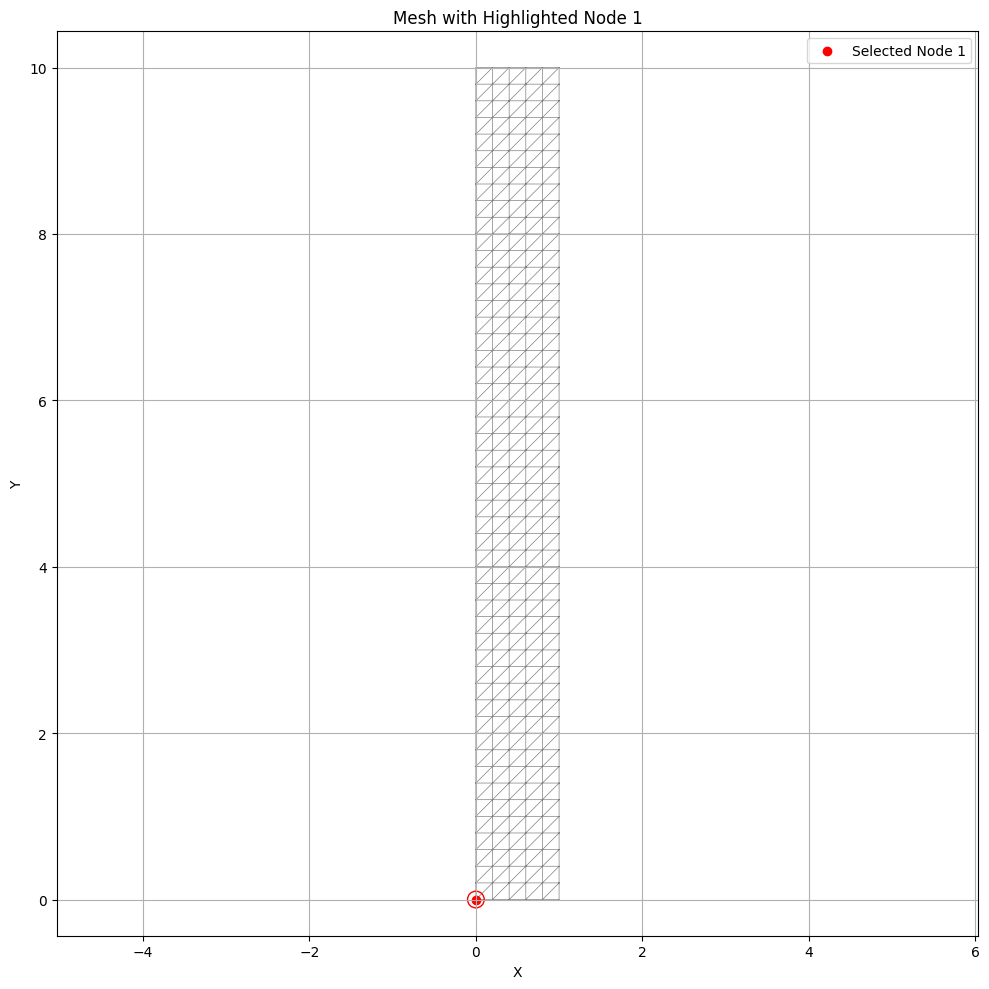

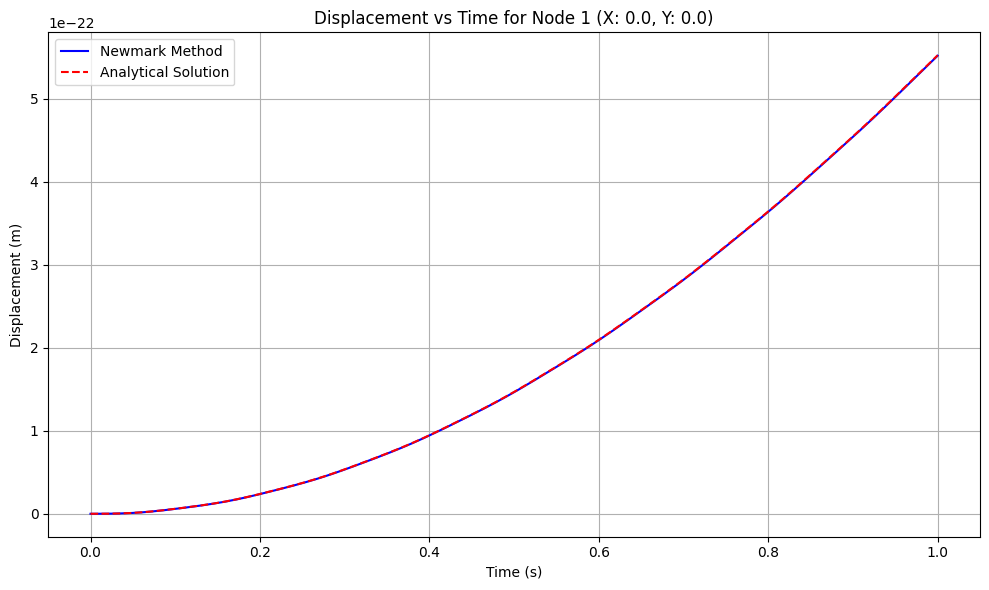

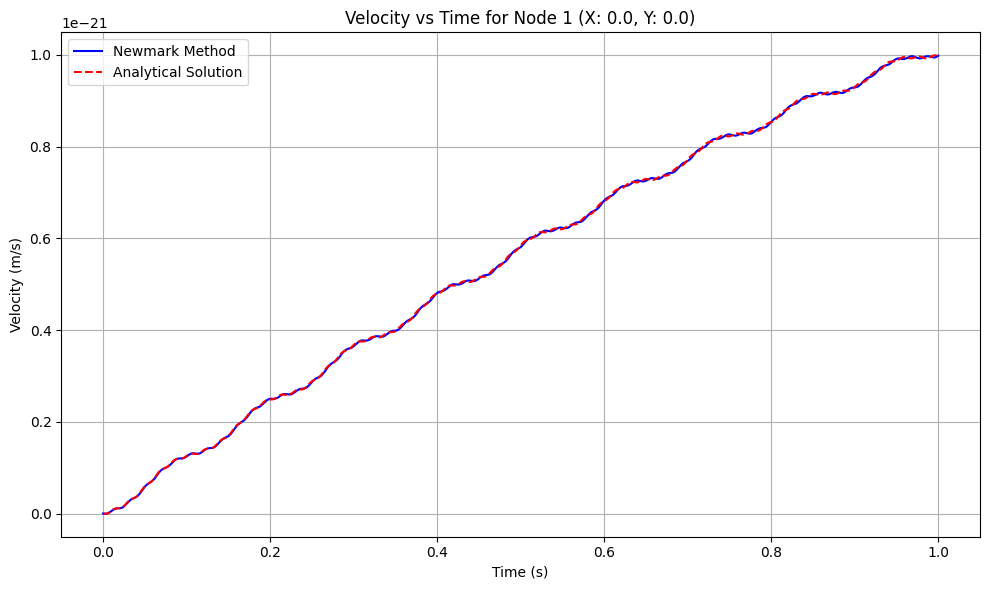

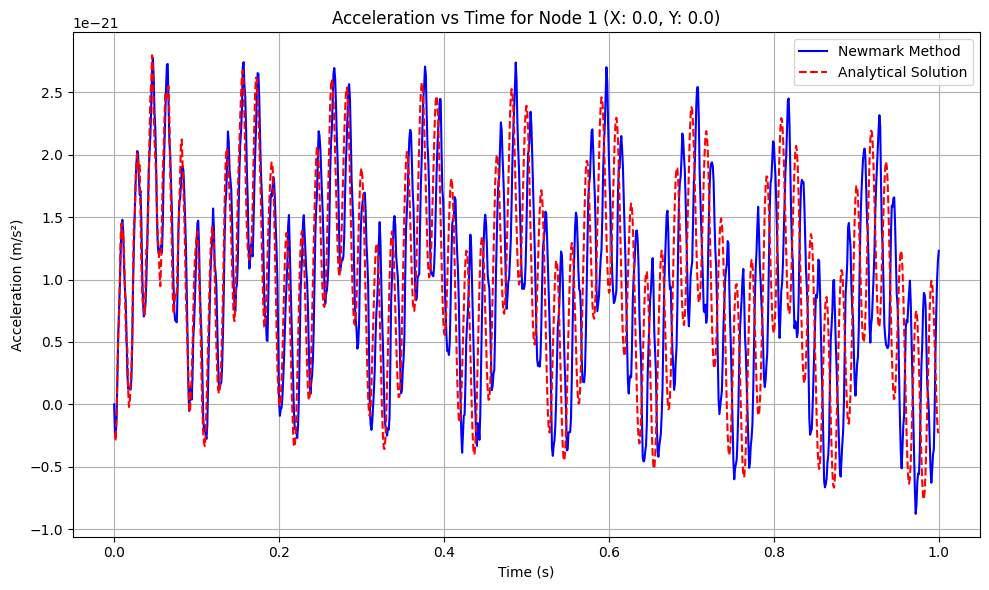

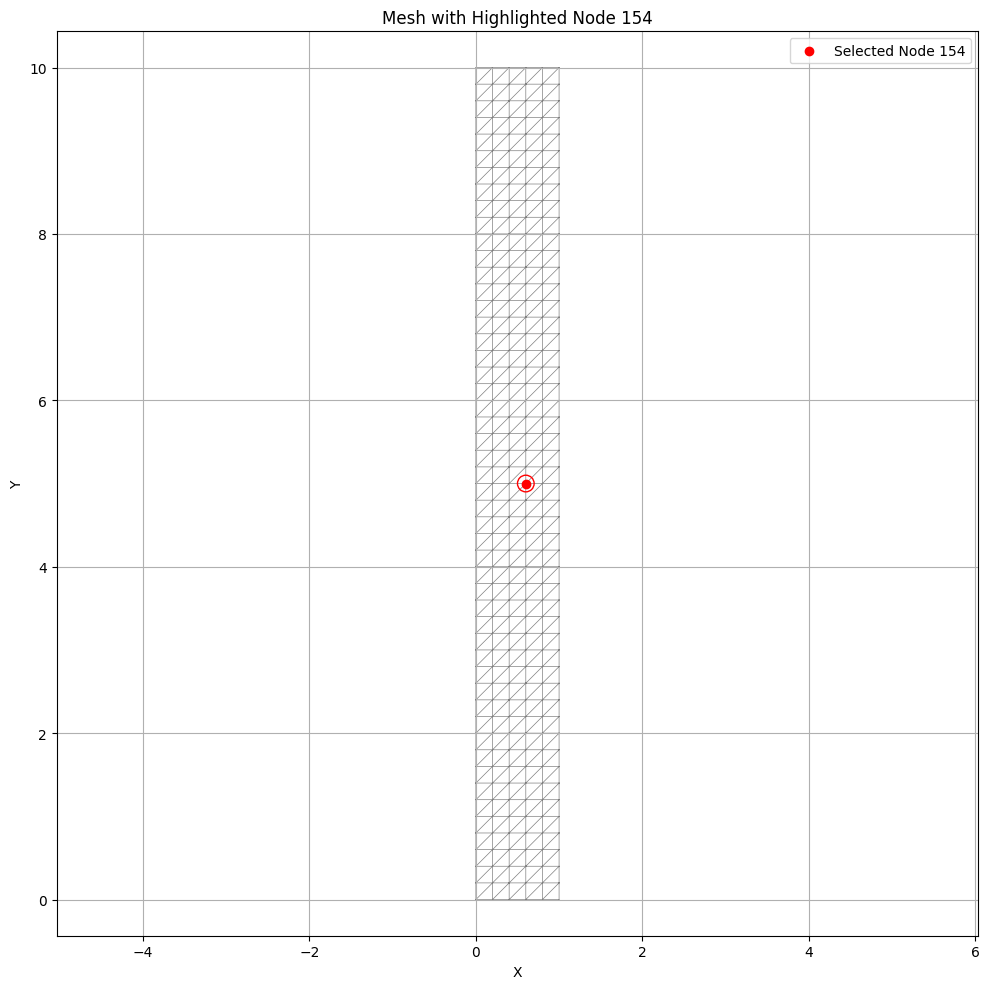

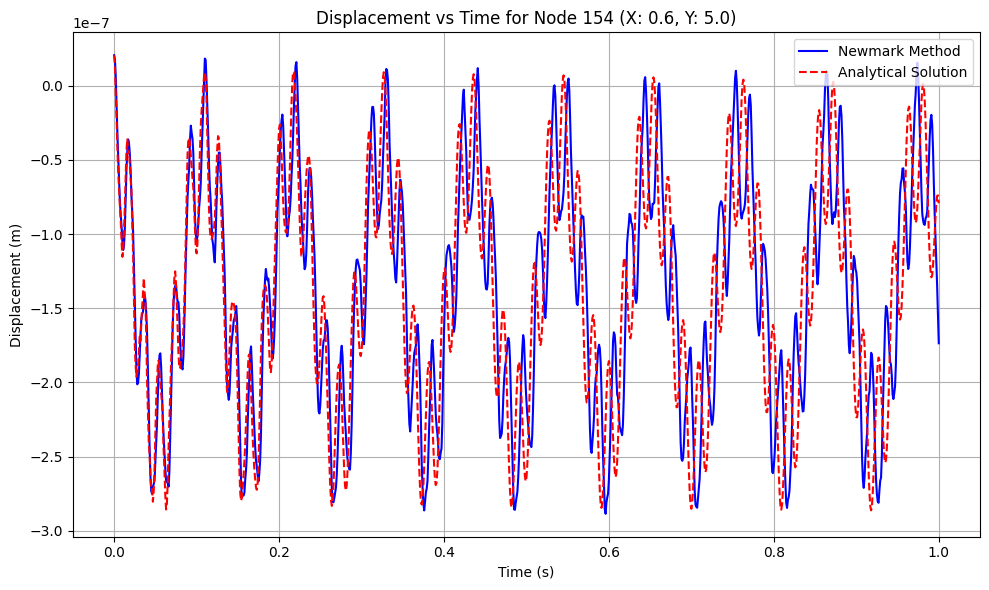

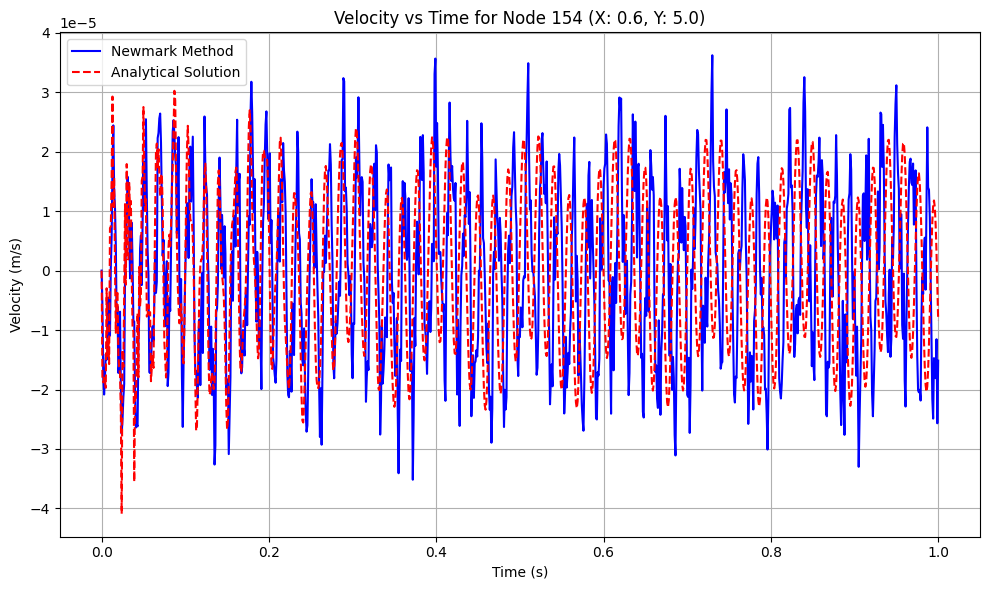

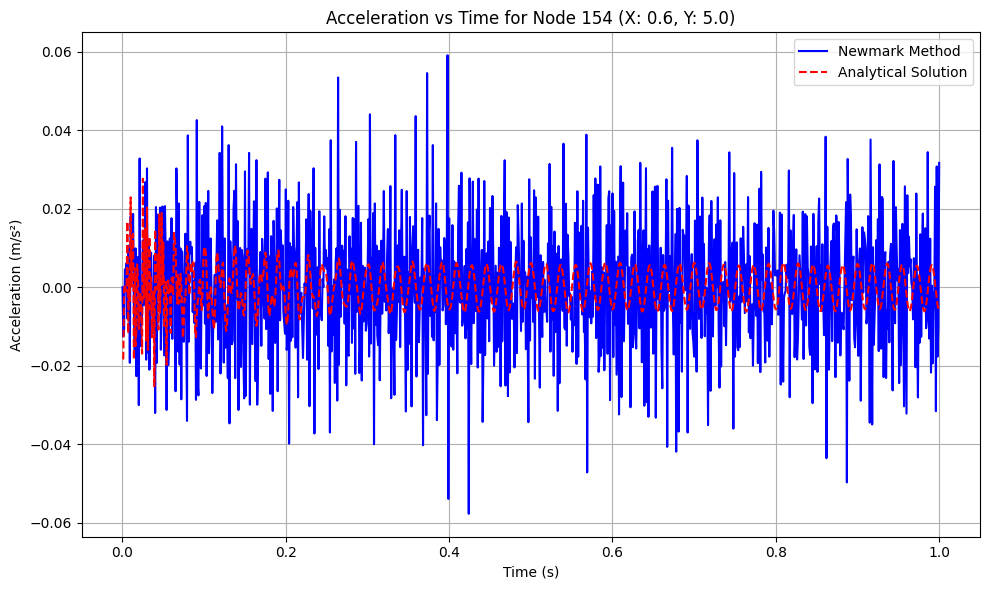

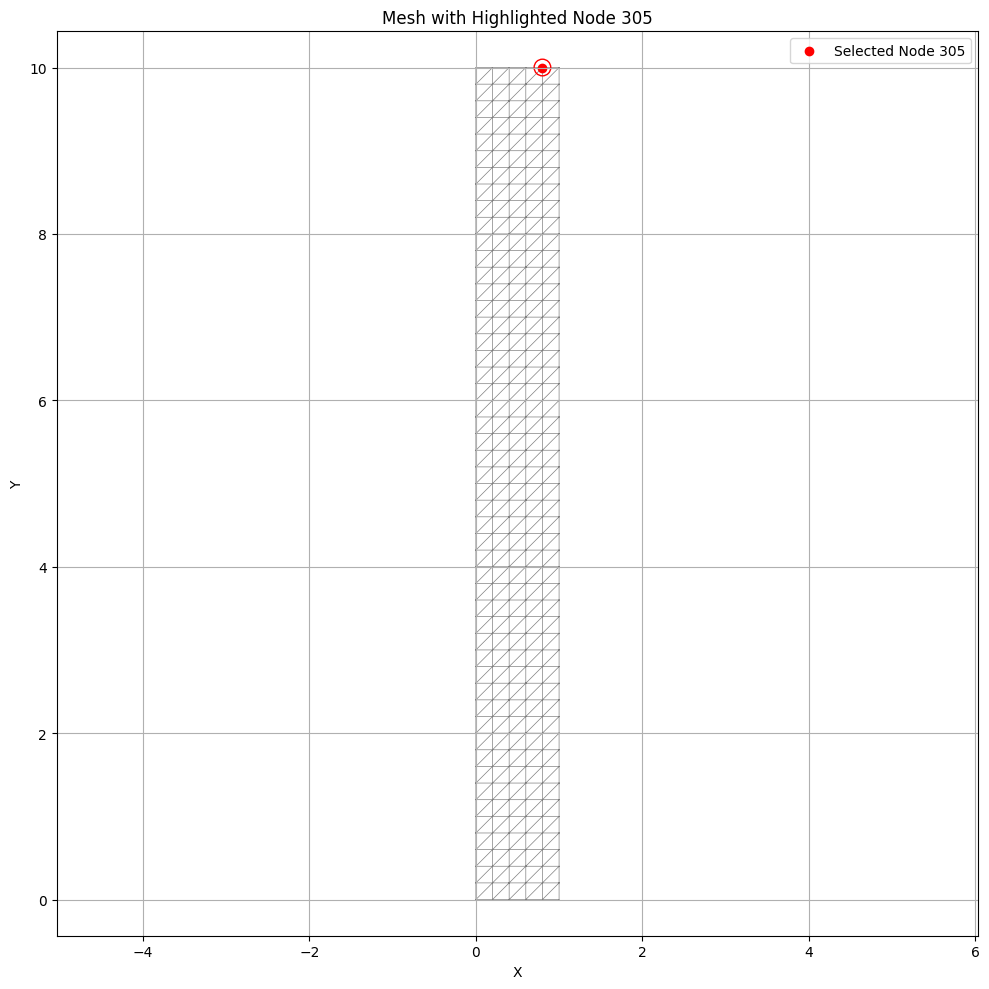

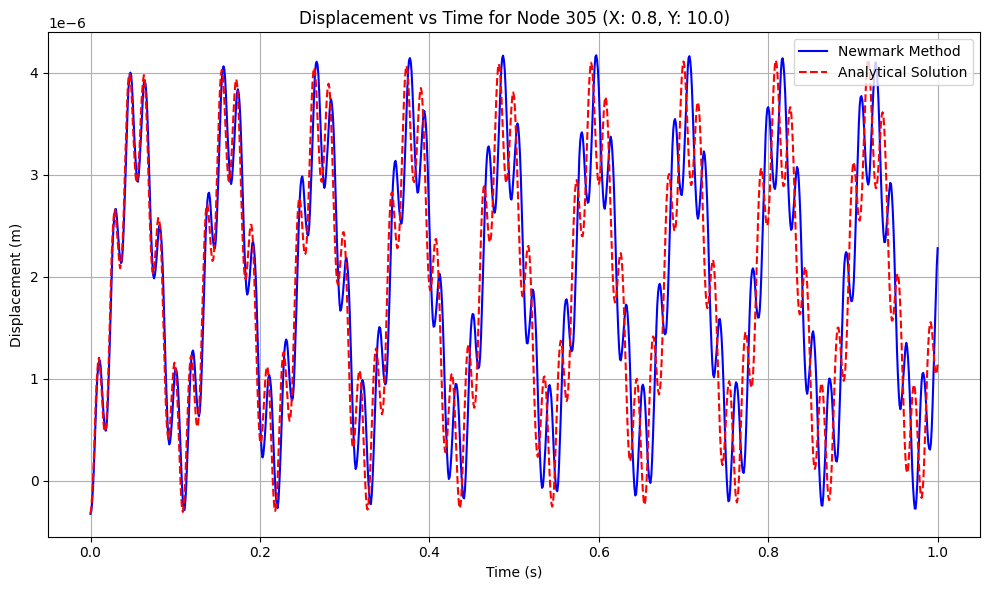

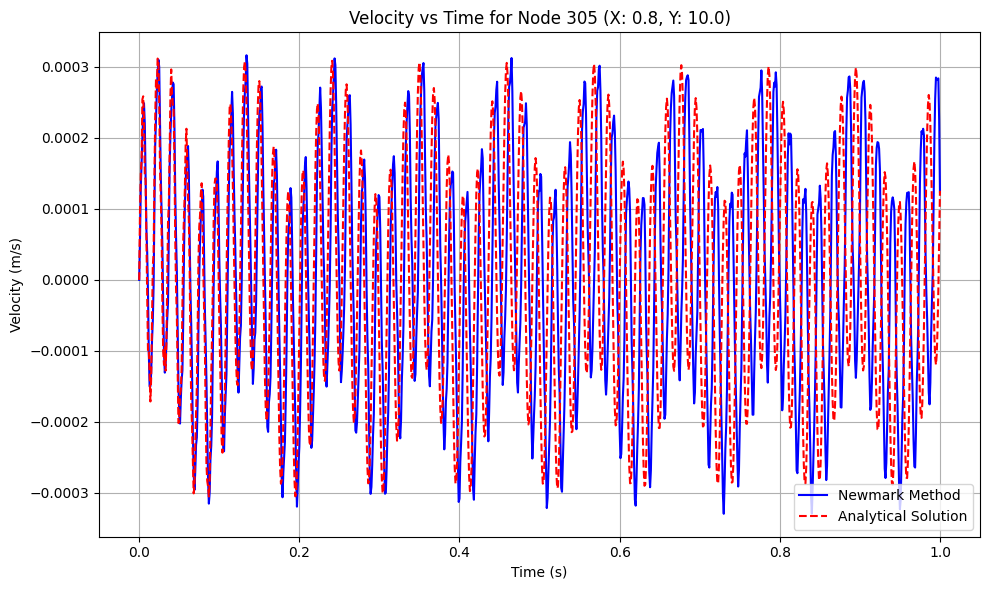

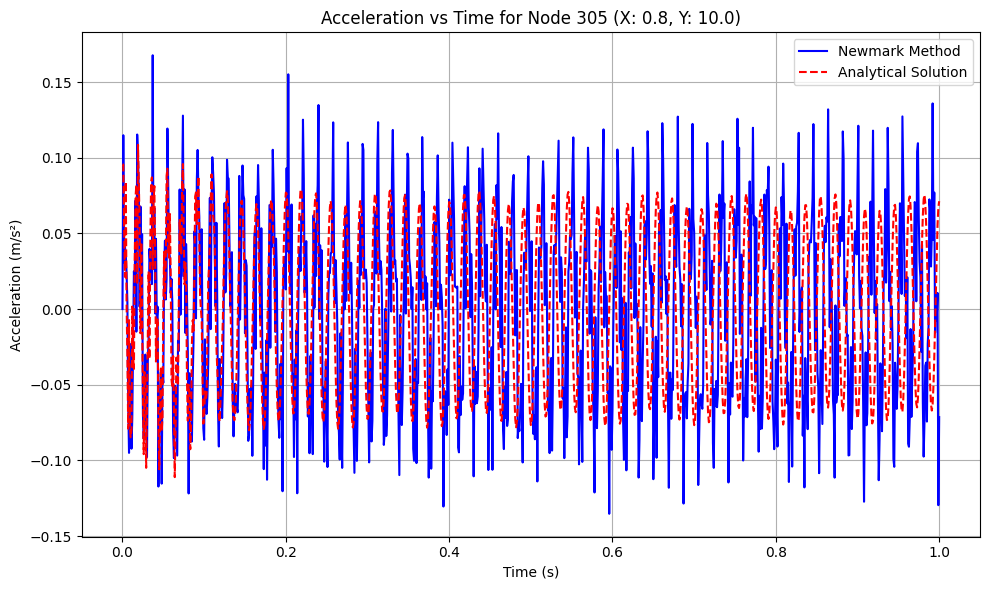

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_node_comparison(mdpa_file, node_ids, case_results, analytical_folder, scale_factor=1e6):
    """
    Plot displacement, velocity, and acceleration vs. time for specified nodes.
    Compare Newmark and analytical solutions.

    Parameters:
    -----------
    mdpa_file: str, path to the .mdpa file containing mesh information.
    node_ids: list of int, node IDs to analyze.
    case_results: dict, results from Newmark method.
    analytical_folder: Path, folder containing analytical solution data.
    scale_factor: float, scaling factor for displacements.
    """
    # Read mesh information from the .mdpa file
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    node_coords.append([int(parts[0]), float(parts[1]), float(parts[2])])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Load analytical solution data
    time_analytical = np.load(analytical_folder / 'time_analytical.npy')
    displacement_analytical = np.load(analytical_folder / 'displacement_analytical.npy')
    velocity_analytical = np.load(analytical_folder / 'velocity_analytical.npy')
    acceleration_analytical = np.load(analytical_folder / 'acceleration_analytical.npy')

    # Extract Newmark solution data
    time_newmark = case_results['time']
    displacement_newmark = case_results['displacement']
    velocity_newmark = case_results['velocity']
    acceleration_newmark = case_results['acceleration']

    # Highlight nodes and plot graphs
    for node_id in node_ids:
        # Find the node in the mesh
        selected_node = node_coords[node_coords[:, 0] == node_id][0]
        node_x, node_y = selected_node[1], selected_node[2]
        idx = np.where(node_coords[:, 0] == node_id)[0][0]

        # Highlight the node on the mesh
        triangulation = tri.Triangulation(node_coords[:, 1], node_coords[:, 2], elements)
        plt.figure(figsize=(10, 10))
        plt.triplot(triangulation, 'k-', lw=0.5, alpha=0.5)
        plt.scatter(node_x, node_y, color='red', label=f'Selected Node {node_id}')
        plt.gca().add_artist(plt.Circle((node_x, node_y), radius=0.1, color='red', fill=False))
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Mesh with Highlighted Node {node_id}')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

        # Plot displacement vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_newmark, displacement_newmark[:, idx], label='Newmark Method', color='blue')
        plt.plot(time_analytical, displacement_analytical[:, idx], label='Analytical Solution', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Displacement (m)')
        plt.title(f'Displacement vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot velocity vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_newmark, velocity_newmark[:, idx], label='Newmark Method', color='blue')
        plt.plot(time_analytical, velocity_analytical[:, idx], label='Analytical Solution', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.title(f'Velocity vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot acceleration vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_newmark, acceleration_newmark[:, idx], label='Newmark Method', color='blue')
        plt.plot(time_analytical, acceleration_analytical[:, idx], label='Analytical Solution', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.title(f'Acceleration vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage
node_ids_to_analyze = [1, 154, 305]  # Replace with desired node IDs
plot_node_comparison(mdpa_file, node_ids_to_analyze, case_results[0], Path("Dynamic_solution/case_1_magnitude_(-137.59, -63.13, 362.93)/Analytical_Solution"))

In [ ]:
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import os

def create_displacement_gif(folder_path, mdpa_file, scale_factor=1e6, step_interval=100):
    """
    Create a displacement GIF for a specific case.
    """
    folder_path = Path(folder_path)
    output_file = folder_path / 'displacement_animation.gif'

    print("=" * 80)
    print(f"🎯 Processing folder: {folder_path.resolve()}")

    # Load solution data
    time_file = folder_path / 'time_analytical.npy'
    displacement_file = folder_path / 'displacement_analytical.npy'
    print(f"📥 Reading displacement data from:")
    print(f"   ⏱️  Time data       : {time_file.resolve()}")
    print(f"   📌 Displacement data: {displacement_file.resolve()}")

    time = np.load(time_file)
    displacement = np.load(displacement_file)

    # Read node coordinates and elements from the .mdpa file
    print(f"📄 Reading mesh connectivity from: {mdpa_file.resolve()}")
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 15))

    # Base triangulation
    x = node_coords[:, 0]
    y = node_coords[:, 1]
    triangulation_orig = tri.Triangulation(x, y, elements)

    # Global displacement limits
    disp_magnitudes = []
    for step in range(len(time)):
        disp = displacement[step].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        disp_magnitudes.append(disp_mag)

    global_min = min(np.min(mag) for mag in disp_magnitudes)
    global_max = max(np.max(mag) for mag in disp_magnitudes)
    print(f"📊 Global displacement range: [{global_min:.2e}, {global_max:.2e}]")

    def update(frame):
        ax.clear()
        disp = displacement[frame].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        deformed_coords = node_coords + disp

        # Undeformed
        ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')

        # Deformed mesh
        triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
        tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                           vmin=global_min, vmax=global_max)
        ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
        ax.grid(True)
        ax.axis('equal')
        ax.legend()

        if frame == 0:
            plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
        plt.tight_layout()

        # Print progress
        if frame % 10 == 0:
            print(f"   🔄 Processing frame {frame}/{len(time)-1}")

    print("🛠️  Creating animation frames...")
    anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)

    # Save animation
    print(f"💾 Saving animation to: {output_file.resolve()}")
    writer = PillowWriter(fps=1000 / step_interval)
    anim.save(output_file, writer=writer)
    plt.close()
    print("✅ Animation complete!\n")
    return True

def get_case_folders(base_dir="Dynamic_solution"):
    """Get all available case folders and sort them by case number."""
    base_path = Path(base_dir)
    
    # Find all case folders dynamically
    case_folders = list(base_path.glob("case_*_magnitude_*"))
    
    # Sort case folders by case number
    def extract_case_number(folder_name):
        # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
        return int(folder_name.name.split("_")[1])
    
    case_folders.sort(key=extract_case_number)
    return case_folders

def user_select_cases(case_folders):
    """Allow user to select which cases to process."""
    print("\nAvailable case folders:")
    for i, folder in enumerate(case_folders, 1):
        print(f"{i}. {folder.name}")
    
    while True:
        try:
            user_input = input("\nEnter case numbers to process (comma-separated, e.g., '1,3,5' or 'all' for all cases): ")
            
            if user_input.lower() == 'all':
                print("Processing all cases.")
                selected_folders = case_folders
                break
            
            # Get user-selected case numbers
            selected_indices = [int(x.strip()) for x in user_input.split(',')]
            
            # Validate indices
            if any(idx < 1 or idx > len(case_folders) for idx in selected_indices):
                print(f"Error: Please enter valid case numbers between 1 and {len(case_folders)}")
                continue
            
            # Get the selected folders
            selected_folders = [case_folders[idx-1] for idx in selected_indices]
            
            if not selected_folders:
                print("No valid cases selected.")
                continue
                
            print(f"\n🔍 Selected {len(selected_folders)} cases to process:")
            for folder in selected_folders:
                print(f"  📁 {folder.name}")
            
            break
            
        except ValueError:
            print("❌ Error: Please enter valid numbers separated by commas.")
        except Exception as e:
            print(f"❌ Error: {str(e)}")
    
    return selected_folders

def process_selected_cases(selected_folders, mdpa_file, scale_factor=1e6):
    """Process only the selected case folders."""
    successful = 0
    failed = 0
    
    for folder in selected_folders:
        print("\n" + "="*50)
        print(f"📂 Processing {folder.name}")
        print("="*50)
        
        # Adjust path to include Analytical_Solution subfolder
        solution_folder = folder / "Analytical_Solution"
        
        if solution_folder.exists():
            if create_displacement_gif(solution_folder, mdpa_file, scale_factor):
                successful += 1
            else:
                failed += 1
        else:
            print(f"❌ Error: Analytical_Solution folder not found in {folder.name}")
            failed += 1
    
    print("\n" + "="*50)
    print("🏁 Processing Complete!")
    print(f"✅ Successfully processed: {successful} cases")
    print(f"❌ Failed to process: {failed} cases")
    print("="*50)

# Main execution block
if __name__ == "__main__":
    try:
        base_dir = "Dynamic_solution"
        
        # Find MDPA file
        mdpa_files = [file for file in os.listdir() if file.endswith('.mdpa')]
        if not mdpa_files:
            print("❌ Error: No .mdpa files found in the current directory.")
            exit(1)
        mdpa_file = Path(mdpa_files[0])
        
        # Get available case folders
        case_folders = get_case_folders(base_dir)
        
        if not case_folders:
            print(f"❌ Error: No case folders found in {base_dir}.")
            exit(1)
        
        print(f"📊 Found {len(case_folders)} total cases")
        
        # Let user select cases
        selected_folders = user_select_cases(case_folders)
        
        # Use the fixed scale factor
        scale_factor = 1e6
        
        process_selected_cases(selected_folders, mdpa_file, scale_factor)
        
    except Exception as e:
        print(f"❌ Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()

📊 Found 10 total cases

Available case folders:
1. case_1_magnitude_(-137.59, -63.13, 362.93)
2. case_2_magnitude_(-198.79, 228.5, -134.8)
3. case_3_magnitude_(104.64, -25.63, 160.89)
4. case_4_magnitude_(17.45, -13.32, 69.69)
5. case_5_magnitude_(186.02, 35.84, -213.65)
6. case_6_magnitude_(229.73, -34.4, -232.19)
7. case_7_magnitude_(34.88, -235.52, 250.55)
8. case_8_magnitude_(379.97, -275.91, -44.58)
9. case_9_magnitude_(391.22, -286.75, 386.86)
10. case_10_magnitude_(75.24, 90.42, 11.42)

🔍 Selected 1 cases to process:
  📁 case_1_magnitude_(-137.59, -63.13, 362.93)

📂 Processing case_1_magnitude_(-137.59, -63.13, 362.93)
🎯 Processing folder: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\Analytical_Solution
📥 Reading displacement data from:
   ⏱️  Time data       : D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\Analytical_Solution\time_analytical.npy
   📌 Displacement 

In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def save_displacement_frames(folder_path, mdpa_file, scale_factor=1e6):
    """
    Save displacement screenshots for each time step as .png images.

    Parameters:
    -----------
    folder_path: str or Path, path to the folder containing displacement and time data.
    mdpa_file: Path, path to the .mdpa file with mesh info.
    scale_factor: float, scale applied to displacement values.
    """
    folder_path = Path(folder_path)
    frame_output_dir = folder_path / 'displacement_frames'
    frame_output_dir.mkdir(exist_ok=True)

    print("=" * 80)
    print(f"📂 Processing folder: {folder_path.resolve()}")

    # Load displacement and time data
    time_file = folder_path / 'time_analytical.npy'
    displacement_file = folder_path / 'displacement_analytical.npy'
    print(f"📥 Loading:")
    print(f"   ⏱️  Time:        {time_file.resolve()}")
    print(f"   📌 Displacement: {displacement_file.resolve()}")

    time = np.load(time_file)
    displacement = np.load(displacement_file)

    # Load mesh from .mdpa file
    print(f"📄 Reading mesh from: {mdpa_file.resolve()}")
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Base mesh
    triangulation_orig = tri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)

    # Displacement range for consistent colorbar
    disp_magnitudes = []
    for step in range(len(time)):
        disp = displacement[step].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        disp_magnitudes.append(disp_mag)

    global_min = min(np.min(mag) for mag in disp_magnitudes)
    global_max = max(np.max(mag) for mag in disp_magnitudes)

    print(f"📊 Displacement magnitude range: [{global_min:.2e}, {global_max:.2e}]")
    print(f"📸 Saving frames to: {frame_output_dir.resolve()}\n")

    # Plot and save each frame
    for frame in range(len(time)):
        fig, ax = plt.subplots(figsize=(10, 15))
        disp = displacement[frame].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        deformed_coords = node_coords + disp

        triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)

        ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
        tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                           vmin=global_min, vmax=global_max)
        ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
        ax.axis('equal')
        ax.grid(True)
        ax.legend()
        plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
        plt.tight_layout()

        # Save the figure
        frame_path = frame_output_dir / f"frame_{frame:04d}.png"
        plt.savefig(frame_path)
        plt.close()

        print(f"✅ Saved: {frame_path.name}")

    print("\n🎉 All displacement frames saved successfully!\n")

# Run for all results
for case in results:
    folder_path = f"Dynamic_solution/case_{case['case']}_magnitude_({', '.join(map(str, case['magnitude']))})/Analytical_Solution"
    save_displacement_frames(folder_path, mdpa_file, scale_factor=1e6)


# ============================================================
# Singular Value Decomposition (SVD) for Reduced Basis Generation
# ============================================================
#
# This section describes the use of Singular Value Decomposition (SVD)
# to extract an optimal reduced basis from full-order simulation data.
#
# The main objectives of applying SVD are:
# - Decompose the snapshot matrix into orthogonal modes
# - Identify dominant patterns in the system behavior
# - Select a reduced set of modes that capture most of the energy
#
# The procedure includes:
# - Assemble the snapshot matrix (e.g., displacement or velocity snapshots)
# - Perform SVD: Snapshot_Matrix = U Σ Vᵀ
# - Select the leading singular vectors (columns of U) as the reduced basis
# - Decide the number of modes to retain based on singular value decay
#
# SVD ensures that the selected reduced basis provides the best low-dimensional
# approximation of the snapshot data in the least-squares sense.
#
# ============================================================
# The following code cells will implement the SVD computation and basis selection.
# ============================================================


In [ ]:
import numpy as np
from pathlib import Path

def read_and_organize_data(base_dir, variable_name):
    """
    Read and organize data (displacement, velocity, acceleration, or force) from the Numerical_Solution folder of each case.

    Parameters:
    -----------
    base_dir: str, path to the base directory containing case folders.
    variable_name: str, name of the variable to read (e.g., 'displacement', 'velocity', 'acceleration', 'force').

    Returns:
    --------
    organized_data: dict, organized data for each case.
    """
    base_path = Path(base_dir)
    case_folders = list(base_path.glob("case_*_magnitude_*"))

    organized_data = {}

    for case_folder in case_folders:
        try:
            # Extract case number and magnitude from folder name
            case_name = case_folder.name
            case_number = int(case_name.split("_")[1])
            magnitude = tuple(map(float, case_name.split("_magnitude_")[1].strip("()").split(", ")))

            # Path to the variable file
            variable_file = case_folder / "FOM_Solution" / "solution" / f"{variable_name}.npy"

            if variable_file.exists():
                # Load variable data
                variable_data = np.load(variable_file)

                # Organize data
                organized_data[case_number] = {
                    "magnitude": magnitude,
                    variable_name: variable_data
                }
                print(f"✅ Successfully loaded {variable_name} data for Case {case_number}")
            else:
                print(f"❌ {variable_name.capitalize()} file not found for Case {case_number}")

        except Exception as e:
            print(f"❌ Error processing {case_folder.name}: {str(e)}")

    return organized_data

# Example usage
base_dir = "Dynamic_solution"

# Initialize lists to store data for all cases
displacement_list = []
velocity_list = []
acceleration_list = []
force_list = []

# Read and concatenate data for all variables
for variable_name, data_list in zip(
    ["displacement", "velocity", "acceleration", "force"],
    [displacement_list, velocity_list, acceleration_list, force_list]
):
    organized_data = read_and_organize_data(base_dir, variable_name)
    for case_number in sorted(organized_data.keys()):
        data_list.append(organized_data[case_number][variable_name].T)  # Transpose to align DOF as rows

    # Concatenate along the time axis if data_list is not empty
    if data_list:
        globals()[f"organized_{variable_name}_data"] = np.hstack(data_list)
    else:
        print(f"⚠️ Warning: No data found for variable '{variable_name}'.")
        globals()[f"organized_{variable_name}_data"] = np.array([])  # Create an empty array for consistency

# Print summary
print("📂 Data organized successfully.")
print(f"📊 Total cases processed: {len(organized_data)}")
print(f"📐 Final displacement data shape: {organized_displacement_data.shape}")
print(f"📐 Final velocity data shape: {organized_velocity_data.shape}")
print(f"📐 Final acceleration data shape: {organized_acceleration_data.shape}")
print(f"📐 Final force data shape: {organized_force_data.shape}")

✅ Successfully loaded displacement data for Case 10
✅ Successfully loaded displacement data for Case 1
✅ Successfully loaded displacement data for Case 2
✅ Successfully loaded displacement data for Case 3
✅ Successfully loaded displacement data for Case 4
✅ Successfully loaded displacement data for Case 5
✅ Successfully loaded displacement data for Case 6
✅ Successfully loaded displacement data for Case 7
✅ Successfully loaded displacement data for Case 8
✅ Successfully loaded displacement data for Case 9
✅ Successfully loaded velocity data for Case 10
✅ Successfully loaded velocity data for Case 1
✅ Successfully loaded velocity data for Case 2
✅ Successfully loaded velocity data for Case 3
✅ Successfully loaded velocity data for Case 4
✅ Successfully loaded velocity data for Case 5
✅ Successfully loaded velocity data for Case 6
✅ Successfully loaded velocity data for Case 7
✅ Successfully loaded velocity data for Case 8
✅ Successfully loaded velocity data for Case 9
✅ Successfully loa


                    COMPLETE SVD AND REDUCED BASIS ANALYSIS                     


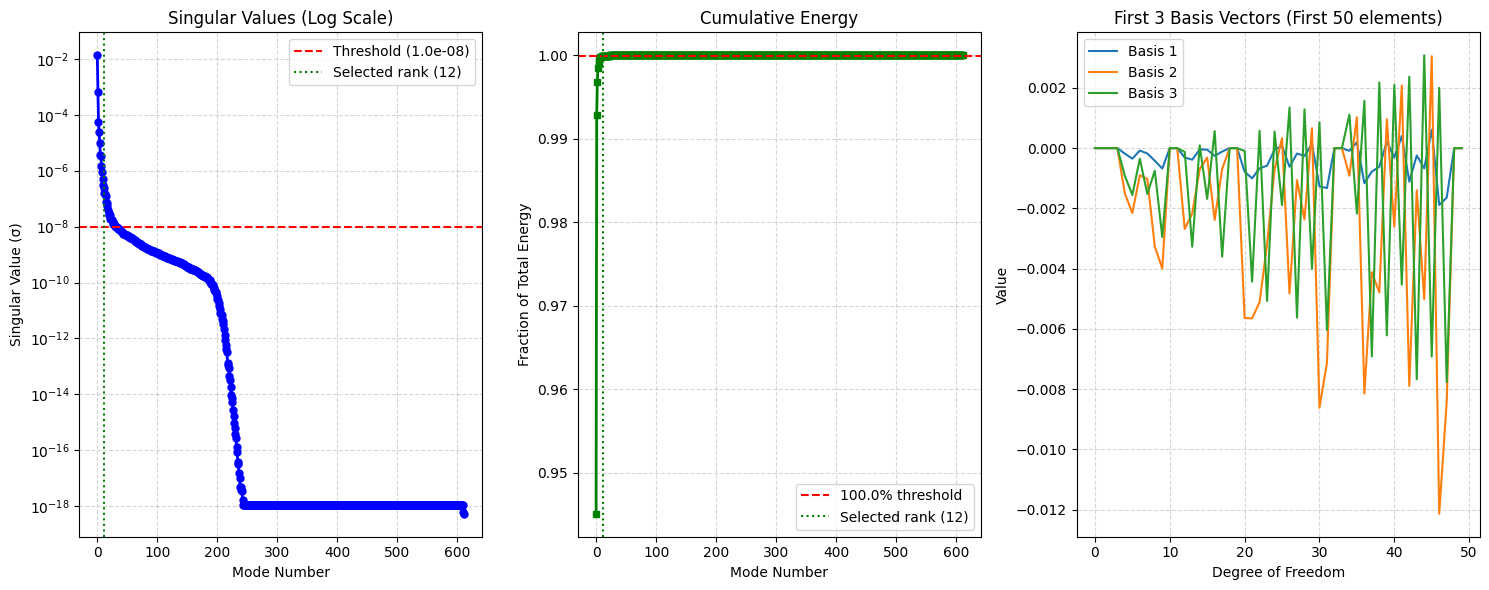


------------------------------ MATRIX PROPERTIES -------------------------------
Shape:                    (612, 10010) (DOFs × snapshots)
Numerical rank:           222
Condition number:         2.48e+16
Effective rank (1e-10):   213

--------------------------- REDUCED BASIS SELECTION ----------------------------
Energy threshold:         1.000 (100.0%)
SV threshold:             1.0e-08
Rank by energy:           12 (captures 99.99% energy)
Rank by SV threshold:     31
Final selected rank:      12
Dimensionality reduction: 98.0% (612 → 12)

-------------------------------- MODE ANALYSIS ---------------------------------
+--------+------------------+---------------------+
| Mode   | Singular Value   | Cumulative Energy   |
+========+==================+=====================+
| 1      | 1.338e-02        | 94.51%              |
+--------+------------------+---------------------+
| 2      | 6.770e-04        | 99.29%              |
+--------+------------------+---------------------+
| 3    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def perform_complete_svd_analysis(displacement_matrix, energy_threshold=0.999, sv_threshold=1e-19):
    print("\n" + "="*80)
    print(" COMPLETE SVD AND REDUCED BASIS ANALYSIS ".center(80))
    print("="*80)

    # Perform SVD
    U, S, VT = np.linalg.svd(displacement_matrix, full_matrices=False)
    num_modes = len(S)
    cum_energy = np.cumsum(S) / np.sum(S)

    # Reduced basis computation
    r_energy = np.argmax(cum_energy >= energy_threshold) + 1 if any(cum_energy >= energy_threshold) else num_modes
    r_threshold = np.sum(S >= sv_threshold)
    final_rank = min(r_energy, r_threshold)
    V_r = U[:, :final_rank]

    results = {
        'U': U,
        'S': S,
        'VT': VT,
        'cumulative_energy': cum_energy,
        'matrix_shape': displacement_matrix.shape,
        'rank': np.linalg.matrix_rank(displacement_matrix),
        'condition_number': np.max(S)/np.min(S) if np.min(S) > 0 else np.inf,
        'effective_rank': np.sum(S > 1e-10 * S[0]),
        'num_modes': num_modes,
        'energy_threshold': energy_threshold,
        'sv_threshold': sv_threshold,
        'r_energy': r_energy,
        'r_threshold': r_threshold,
        'final_rank': final_rank,
        'V_r': V_r,
        'dimensionality_reduction': 100*(1 - final_rank/displacement_matrix.shape[0])
    }

    # Visualization
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)
    plt.semilogy(S, 'b-', linewidth=2, marker='o', markersize=5)
    plt.title("Singular Values (Log Scale)", fontsize=12)
    plt.xlabel("Mode Number")
    plt.ylabel("Singular Value (\u03c3)")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.axhline(y=sv_threshold, color='r', linestyle='--', label=f'Threshold ({sv_threshold:.1e})')
    plt.axvline(x=final_rank, color='g', linestyle=':', label=f'Selected rank ({final_rank})')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(cum_energy, 'g-', linewidth=2, marker='s', markersize=5)
    plt.title("Cumulative Energy", fontsize=12)
    plt.xlabel("Mode Number")
    plt.ylabel("Fraction of Total Energy")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axhline(y=energy_threshold, color='r', linestyle='--', label=f'{energy_threshold*100:.1f}% threshold')
    plt.axvline(x=final_rank, color='g', linestyle=':', label=f'Selected rank ({final_rank})')
    plt.legend()

    plt.subplot(1, 3, 3)
    for i in range(min(3, final_rank)):
        plt.plot(V_r[:50, i], label=f'Basis {i+1}')
    plt.title("First 3 Basis Vectors (First 50 elements)", fontsize=12)
    plt.xlabel("Degree of Freedom")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Text output
    print(f"\n{' MATRIX PROPERTIES ':-^80}")
    print(f"{'Shape:':<25} {displacement_matrix.shape} (DOFs × snapshots)")
    print(f"{'Numerical rank:':<25} {results['rank']}")
    print(f"{'Condition number:':<25} {results['condition_number']:.2e}")
    print(f"{'Effective rank (1e-10):':<25} {results['effective_rank']}")

    print(f"\n{' REDUCED BASIS SELECTION ':-^80}")
    print(f"{'Energy threshold:':<25} {energy_threshold:.3f} ({(energy_threshold*100):.1f}%)")
    print(f"{'SV threshold:':<25} {sv_threshold:.1e}")
    print(f"{'Rank by energy:':<25} {r_energy} (captures {cum_energy[r_energy-1]*100:.2f}% energy)")
    print(f"{'Rank by SV threshold:':<25} {r_threshold}")
    print(f"{'Final selected rank:':<25} {final_rank}")
    print(f"{'Dimensionality reduction:':<25} {results['dimensionality_reduction']:.1f}% ({displacement_matrix.shape[0]} → {final_rank})")

    print(f"\n{' MODE ANALYSIS ':-^80}")
    print(tabulate([
        ["1", f"{S[0]:.3e}", f"{cum_energy[0]*100:.2f}%"],
        ["2", f"{S[1]:.3e}", f"{cum_energy[1]*100:.2f}%"],
        ["3", f"{S[2]:.3e}", f"{cum_energy[2]*100:.2f}%"],
        ["...", "...", "..."],
        [str(final_rank), f"{S[final_rank-1]:.3e}", f"{cum_energy[final_rank-1]*100:.2f}%"],
        ["Full", f"{S[-1]:.3e}", "100.00%"]
    ], headers=["Mode", "Singular Value", "Cumulative Energy"], tablefmt="grid"))

    print(f"\n{' REDUCED BASIS PROPERTIES ':-^80}")
    print(f"{'Shape:':<25} {V_r.shape} (DOFs × modes)")
    print(f"{'Orthogonality check:':<25} Max off-diagonal: {np.max(np.abs(V_r.T @ V_r - np.eye(final_rank))):.2e}")
    print("\nFirst 5 elements of first 3 basis vectors:")
    for i in range(min(3, final_rank)):
        print(f"Basis {i+1}: {np.array2string(V_r[:5, i], precision=3, separator=', ')}")

    return results

if 'organized_displacement_data' in globals() and organized_displacement_data.size > 0:
    analysis_results = perform_complete_svd_analysis(
        displacement_matrix=organized_displacement_data,
        energy_threshold=0.9999,
        sv_threshold=1e-8
    )
else:
    print("\nNo displacement data found for SVD analysis.")


In [ ]:
V_r = analysis_results['V_r']
print(f"\n{' V_r (Reduced Basis) ':-^80}")
print(f"Shape: {V_r.shape} (DOFs × modes)")
# print(V_r)


----------------------------- V_r (Reduced Basis) ------------------------------
Shape: (612, 12) (DOFs × modes)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Ensure organized data and V_r from previous SVD are available
assert 'organized_displacement_data' in globals()
assert 'organized_velocity_data' in globals()
assert 'organized_acceleration_data' in globals()
assert 'organized_force_data' in globals()
assert 'V_r' in globals()

print(f"\n{' V_r (Reduced Basis) ':-^80}")
print(f"Shape: {V_r.shape} (DOFs × modes)")

# Function to project and reconstruct a matrix
def project_and_reconstruct(matrix, V_r, label=""):
    original_shape = matrix.shape
    projected = V_r.T @ matrix
    reconstructed = V_r @ projected
    error = np.linalg.norm(matrix - reconstructed) / np.linalg.norm(matrix)
    error_percent = error * 100

    print(f"\n{' ' + label + ' RECONSTRUCTION DETAILS ':=^80}")
    print(f"Original shape      : {original_shape}")
    print(f"Reduced shape       : {projected.shape}")
    print(f"Reconstructed shape : {reconstructed.shape}")
    print(f"Reconstruction error: {error:.3e}")
    print(f"Percentage error    : {error_percent:.3f}%")

    return projected, reconstructed, error

# Apply to each variable
projected_displacement, reconstructed_displacement, err_disp = project_and_reconstruct(
    organized_displacement_data, V_r, label="Displacement"
)

projected_velocity, reconstructed_velocity, err_vel = project_and_reconstruct(
    organized_velocity_data, V_r, label="Velocity"
)

projected_acceleration, reconstructed_acceleration, err_acc = project_and_reconstruct(
    organized_acceleration_data, V_r, label="Acceleration"
)

projected_force, reconstructed_force, err_force = project_and_reconstruct(
    organized_force_data, V_r, label="Force"
)

# Collect all errors into a dictionary for summary
reconstruction_errors = {
    "Displacement": err_disp,
    "Velocity": err_vel,
    "Acceleration": err_acc,
    "Force": err_force
}

# Print summary
print("\n" + "="*80)
print(" RECONSTRUCTION ERROR SUMMARY ".center(80))
print("="*80)
for var, err in reconstruction_errors.items():
    print(f"{var:<20}: {err:.3e} ({err * 100:.3f}%)")



----------------------------- V_r (Reduced Basis) ------------------------------
Shape: (612, 12) (DOFs × modes)

===================== Displacement RECONSTRUCTION DETAILS ======================
Original shape      : (612, 10010)
Reduced shape       : (12, 10010)
Reconstructed shape : (612, 10010)
Reconstruction error: 2.172e-05
Percentage error    : 0.002%

======================= Velocity RECONSTRUCTION DETAILS ========================
Original shape      : (612, 10010)
Reduced shape       : (12, 10010)
Reconstructed shape : (612, 10010)
Reconstruction error: 3.663e-03
Percentage error    : 0.366%

===================== Acceleration RECONSTRUCTION DETAILS ======================
Original shape      : (612, 10010)
Reduced shape       : (12, 10010)
Reconstructed shape : (612, 10010)
Reconstruction error: 3.113e-01
Percentage error    : 31.132%

========================= Force RECONSTRUCTION DETAILS =========================
Original shape      : (612, 10010)
Reduced shape       : (12, 

In [ ]:
x_reduced_list = []
f_reduced_list = []

n_cases = x.shape[1]

for i in range(n_cases):
    x_case = x[:, i]                      # Full-order displacement for case i
    f_case = f_constrained[:, i]         # Full-order force for case i

    x_r = V_r.T @ x_case                 # Reduced displacement (r,)
    f_r = V_r.T @ f_case                 # Reduced force (r,)

    x_reduced_list.append(x_r)
    f_reduced_list.append(f_r)

# Stack to shape (r, n_cases)
x_reduced = np.column_stack(x_reduced_list)
f_reduced = np.column_stack(f_reduced_list)

print(f"\n{' REDUCED INITIAL VALUES (Per Case Projection) ':-^80}")
print(f"x_reduced shape: {x_reduced.shape}")
print(f"f_reduced shape: {f_reduced.shape}")



----------------- REDUCED INITIAL VALUES (Per Case Projection) -----------------
x_reduced shape: (12, 10)
f_reduced shape: (12, 10)


In [ ]:
X = np.hstack([projected_acceleration.T, projected_displacement.T])   # Shape: (m × 2r)
print(X.shape)  # Shape: (m × 2r)


(10010, 24)


In [ ]:
def analyze_regression_matrix(X):
    # Print header
    print("\n" + "="*60)
    print("REGRESSION MATRIX ANALYSIS (X = [Üᵗ | Uᵗ])".center(60))
    print("="*60)
    
    # Compute matrix properties
    rank = np.linalg.matrix_rank(X)
    condition_number = np.linalg.cond(X)
    svals = np.linalg.svd(X, compute_uv=False)  # Singular values only
    
    # Print results
    print(f"{'Shape:':<25} {X.shape}")
    print(f"{'Rank:':<25} {rank}")
    print(f"{'Full rank:':<25} {rank == X.shape[1]}")
    print(f"{'Condition number:':<25} {condition_number:.2e}")
    print(f"{'Min singular value:':<25} {svals.min():.3e}")
    print(f"{'Max singular value:':<25} {svals.max():.3e}")

analyze_regression_matrix(X)  # Assumes X is predefined


        REGRESSION MATRIX ANALYSIS (X = [Üᵗ | Uᵗ])         
Shape:                    (10010, 24)
Rank:                     24
Full rank:                True
Condition number:         4.19e+09
Min singular value:       1.304e-08
Max singular value:       5.456e+01


# ============================================================
# ROM Mass (Mr) and Stiffness (Kr) Matrix Construction
# ============================================================
#
# This section implements the construction of the reduced-order
# mass and stiffness matrices using the Least Squares method.
#
# The procedure includes:
# - Assemble full-order force snapshots (mass and stiffness forces)
# - Project forces onto the reduced basis
# - Formulate an overdetermined system for best fit
# - Solve for Mr and Kr using least squares minimization
#
# The goal is to accurately approximate the dynamics of the
# full-order system within the reduced-order subspace.
#
# ============================================================
# The following code cells perform the matrix identification steps.
# ============================================================

In [ ]:
def construct_A_matrix_general(projected_acceleration, projected_displacement):
    r, m = projected_acceleration.shape
    
    # Generate M and K variable indices (upper triangle)
    M_vars = [(i, j) for i in range(r) for j in range(i, r)]
    K_vars = [(i, j) for i in range(r) for j in range(i, r)]
    
    # Create dictionaries for quick index lookup
    M_var_dict = {(p, q): idx for idx, (p, q) in enumerate(M_vars)}
    K_var_dict = {(p, q): idx for idx, (p, q) in enumerate(K_vars)}
    
    num_vars = len(M_vars) + len(K_vars)
    A_rows = []
    
    # Generalized loop for any number of time steps
    for j in range(m):        # loop over time step
        for i in range(r):    # loop over mode
            row = np.zeros(num_vars)
            for k in range(r):
                # M[i,k] contribution
                mp, mq = (i, k) if i <= k else (k, i)
                row[M_var_dict[(mp, mq)]] += projected_acceleration[k, j]

                # K[i,k] contribution
                kp, kq = (i, k) if i <= k else (k, i)
                row[len(M_vars) + K_var_dict[(kp, kq)]] += projected_displacement[k, j]
            A_rows.append(row)
    
    return np.vstack(A_rows)

# Example usage
A_fixed = construct_A_matrix_general(projected_acceleration, projected_displacement)

print(A_fixed.shape)



(120120, 156)


In [ ]:
# Flatten the force matrix column-wise (consistent with row ordering in A)
fr_flattened = projected_force.T.flatten()

# b_flattened
print(fr_flattened.shape)  


(120120,)


In [ ]:
# Recompute least squares using A_single_fixed and b_flattened
x_single_solution, _, _, _ = np.linalg.lstsq(A_fixed, fr_flattened, rcond=None)

# Dynamically determine the number of modes from the shape of A
num_total_vars_single = A_fixed.shape[1]
r_single = int((-1 + np.sqrt(1 + 8 * (num_total_vars_single // 2))) // 2)
n_sym_single = r_single * (r_single + 1) // 2

# Extract vec_M and vec_K
vec_M_single = x_single_solution[:n_sym_single]
vec_K_single = x_single_solution[n_sym_single:]

r_single, n_sym_single, vec_M_single, vec_K_single


(12,
 78,
 array([ 2.50754895e+02,  9.88934245e+00,  2.04563751e+00, -1.02859311e+01,
         5.78256516e+00, -2.71430260e+00, -7.06259473e+00, -2.84171104e-01,
        -2.80100560e-01,  8.28444165e+00,  8.56769576e+00, -2.36743010e+01,
         2.51536170e+02, -2.05098247e+00,  1.00269274e+01, -8.20448193e+00,
        -9.36338514e-01,  2.66542292e+00,  1.02328871e+01,  3.29046646e+00,
        -4.14203110e+01, -9.81512215e+00,  8.22530761e+01,  2.54786915e+02,
         9.36103440e-01, -1.50947877e+00,  4.37664850e+00, -1.06190314e+00,
         3.20541168e-01, -6.33385541e-01, -4.91138912e+00,  5.10705471e+00,
         7.74498005e+00,  2.50615048e+02,  5.37471074e+00, -3.61189229e+00,
        -1.02158823e+01,  4.37833907e+00,  7.60818181e-01,  1.04252303e+00,
         5.25134838e+00, -8.12319869e-01,  2.61472229e+02,  5.45794418e+00,
         9.70429107e+00, -1.13874622e+01, -3.83531364e+00,  2.59015495e+01,
         1.66144615e+00, -4.69999157e+01,  2.62211519e+02,  2.97970359e+00,
  

In [ ]:
# Use the previously defined function to convert vec (upper triangle) to full symmetric matrices
def vech_to_symmetric(vec, size):
    mat = np.zeros((size, size))
    triu_indices = np.triu_indices(size)
    mat[triu_indices] = vec
    mat[(triu_indices[1], triu_indices[0])] = vec  # fill lower triangle
    return mat

# Reconstruct M_tilde and K_tilde from the vectors
M_tilde = vech_to_symmetric(vec_M_single, r_single)
K_tilde = vech_to_symmetric(vec_K_single, r_single)

# M_tilde_single, K_tilde_single
print(M_tilde.shape, K_tilde.shape)  # Should be (r, r) for both


(12, 12) (12, 12)


In [ ]:
import numpy as np
from tabulate import tabulate

def check_matrix_properties(matrix, name):
    """
    Check and return properties of a matrix.
    
    Parameters:
    - matrix: The matrix to check.
    - name: Name of the matrix (for display purposes).
    
    Returns:
    - dict: A dictionary containing the properties of the matrix.
    """
    properties = {}
    properties["Matrix"] = name
    properties["Shape"] = matrix.shape
    properties["Symmetric"] = np.allclose(matrix, matrix.T, atol=1e-8)
    properties["Real Values"] = np.isreal(matrix).all()
    properties["Positive Values"] = (matrix > 0).all()
    eigenvalues = np.linalg.eigvals(matrix)
    properties["Real Eigenvalues"] = np.isreal(eigenvalues).all()
    properties["Positive Eigenvalues"] = (eigenvalues > 0).all()
    properties["Min Eigenvalue"] = np.min(eigenvalues).real if np.isreal(eigenvalues).all() else "Complex"
    properties["Max Eigenvalue"] = np.max(eigenvalues).real if np.isreal(eigenvalues).all() else "Complex"
    properties["Condition Number"] = np.linalg.cond(matrix)
    return properties

# Check properties of M_tilde and K_tilde
M_tilde_properties = check_matrix_properties(M_tilde, "M_tilde")
K_tilde_properties = check_matrix_properties(K_tilde, "K_tilde")

# Tabulate the results
table = [M_tilde_properties, K_tilde_properties]
headers = ["Property", "M_tilde", "K_tilde"]
rows = [
    ["Shape", M_tilde_properties["Shape"], K_tilde_properties["Shape"]],
    ["Symmetric", M_tilde_properties["Symmetric"], K_tilde_properties["Symmetric"]],
    ["Real Values", M_tilde_properties["Real Values"], K_tilde_properties["Real Values"]],
    ["Positive Values", M_tilde_properties["Positive Values"], K_tilde_properties["Positive Values"]],
    ["Real Eigenvalues", M_tilde_properties["Real Eigenvalues"], K_tilde_properties["Real Eigenvalues"]],
    ["Positive Eigenvalues", M_tilde_properties["Positive Eigenvalues"], K_tilde_properties["Positive Eigenvalues"]],
    ["Min Eigenvalue", M_tilde_properties["Min Eigenvalue"], K_tilde_properties["Min Eigenvalue"]],
    ["Max Eigenvalue", M_tilde_properties["Max Eigenvalue"], K_tilde_properties["Max Eigenvalue"]],
    ["Condition Number", f"{M_tilde_properties['Condition Number']:.2e}", f"{K_tilde_properties['Condition Number']:.2e}"],
]

print("\nMatrix Properties:")
print(tabulate(rows, headers=headers, tablefmt="grid"))


Matrix Properties:
+----------------------+-------------------+-------------------+
| Property             | M_tilde           | K_tilde           |
+======================+===================+===================+
| Shape                | (12, 12)          | (12, 12)          |
+----------------------+-------------------+-------------------+
| Symmetric            | True              | True              |
+----------------------+-------------------+-------------------+
| Real Values          | True              | True              |
+----------------------+-------------------+-------------------+
| Positive Values      | False             | False             |
+----------------------+-------------------+-------------------+
| Real Eigenvalues     | True              | True              |
+----------------------+-------------------+-------------------+
| Positive Eigenvalues | True              | True              |
+----------------------+-------------------+-------------------+
| Min

In [ ]:
output_dir, case_results, case_times = solve_newmark_dynamic_multi_case(
    M=M_tilde,
    K=K_tilde,
    f=f_reduced,
    magnitudes=magnitudes,
    x=x_reduced,
    total_time=1.0,
    dt=1e-3,
    beta=0.25,
    gamma=0.5,
    tol=1e-8,
    max_iter=50,
    subfolder_name="ROM_Solution"
)


Function called with:
M: (12, 12), K: (12, 12), f: (12, 10), magnitudes: [(-137.59, -63.13, 362.93), (-198.79, 228.5, -134.8), (104.64, -25.63, 160.89), (17.45, -13.32, 69.69), (186.02, 35.84, -213.65), (229.73, -34.4, -232.19), (34.88, -235.52, 250.55), (379.97, -275.91, -44.58), (391.22, -286.75, 386.86), (75.24, 90.42, 11.42)], x: (12, 10)

Continuing without resetting the folder.

Starting multi-case dynamic analysis...
Number of DOFs: 12
Number of cases: 10


Processing cases:  20%|██        | 2/10 [00:00<00:00, 18.89it/s]


Solving case 1/10
Magnitude: (-137.59, -63.13, 362.93)
✅ All time steps converged successfully.

Solving case 2/10
Magnitude: (-198.79, 228.5, -134.8)
✅ All time steps converged successfully.

Solving case 3/10
Magnitude: (104.64, -25.63, 160.89)
✅ All time steps converged successfully.

Solving case 4/10
Magnitude: (17.45, -13.32, 69.69)
✅ All time steps converged successfully.


Processing cases:  60%|██████    | 6/10 [00:00<00:00, 18.56it/s]


Solving case 5/10
Magnitude: (186.02, 35.84, -213.65)
✅ All time steps converged successfully.

Solving case 6/10
Magnitude: (229.73, -34.4, -232.19)
✅ All time steps converged successfully.

Solving case 7/10
Magnitude: (34.88, -235.52, 250.55)
✅ All time steps converged successfully.

Solving case 8/10
Magnitude: (379.97, -275.91, -44.58)
✅ All time steps converged successfully.

Processing cases: 100%|██████████| 10/10 [00:00<00:00, 18.13it/s]



Solving case 9/10
Magnitude: (391.22, -286.75, 386.86)
✅ All time steps converged successfully.

Solving case 10/10
Magnitude: (75.24, 90.42, 11.42)
✅ All time steps converged successfully.

Results Summary:
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude                 |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+===========================+====================+================+====================+==================+
|      1 | (-137.59, -63.13, 362.93) |           7.81e-05 |       0.00276  |              1.09  |             0.05 |
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|      2 | (-198.79, 228.5, -134.8)  |           0.000303 |       0.00957  |              0.877 |             0.04 |
+--------+---------------------------+--------------------+----------------+------------

In [ ]:
import os
from pathlib import Path
from tabulate import tabulate

# Get the current working directory
cwd = Path.cwd()

# Navigate to the "Dynamic_solution" directory
dynamic_solution_dir = cwd / "Dynamic_solution"

# Initialize a list to store the tabulated data
tabulated_data = []

# Iterate through all case folders and collect data
for case_folder in sorted(dynamic_solution_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_dir = case_folder / "ROM_Solution" / "solution"
    # Check if the directory exists
    if rom_dir.exists() and rom_dir.is_dir():
        case_data = [case_folder.name]  # Initialize row with case folder name
        # Iterate through all files in the directory
        for file in sorted(rom_dir.iterdir()):
            if file.is_file():
                # Get the size of the file in bytes
                file_size = os.path.getsize(file)
                # Load the file content if it's a numpy file
                if file.suffix == '.npy':
                    data = np.load(file)
                    case_data.append(f"{file.name}: {data.shape}")
                else:
                    case_data.append(f"{file.name}: N/A")
        tabulated_data.append(case_data)
    else:
        tabulated_data.append([case_folder.name, "Directory does not exist"])

# Print the tabulated data
headers = ["Case Folder"] + [f"File {i+1}" for i in range(len(tabulated_data[0]) - 1)]
print(tabulate(tabulated_data, headers=headers, tablefmt="grid"))

+--------------------------------------------+------------------------------+------------------------------+-----------------------+-------------------+--------------------------+
| Case Folder                                | File 1                       | File 2                       | File 3                | File 4            | File 5                   |
+============================================+==============================+==============================+=======================+===================+==========================+
| case_1_magnitude_(-137.59, -63.13, 362.93) | acceleration.npy: (1001, 12) | displacement.npy: (1001, 12) | force.npy: (1001, 12) | time.npy: (1001,) | velocity.npy: (1001, 12) |
+--------------------------------------------+------------------------------+------------------------------+-----------------------+-------------------+--------------------------+
| case_2_magnitude_(-198.79, 228.5, -134.8)  | acceleration.npy: (1001, 12) | displacement.npy: (100

In [ ]:
import os
import numpy as np
from pathlib import Path
from tabulate import tabulate

# Define base path and target variables
base_dir = Path.cwd() / "Dynamic_solution"
variables = ["displacement", "velocity", "acceleration", "force"]

# Display V_r shape once
print(f"\n{'='*100}")
print(f"{'FULL-ORDER RECONSTRUCTION USING REDUCED BASIS':^100}")
print(f"{'='*100}")
print(f"Using V_r of shape: {V_r.shape} (DOFs × Modes)")

# Table to store case summary
tabulated_data = []

# Process each case
for case_folder in sorted(base_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_input_dir = case_folder / "ROM_Solution" / "solution"
    rom_output_dir = case_folder / "ROM_constructed"
    rom_output_dir.mkdir(parents=True, exist_ok=True)

    case_data = [case_folder.name]

    if rom_input_dir.exists():
        for var in variables:
            input_file = rom_input_dir / f"{var}.npy"
            output_file = rom_output_dir / f"{var}.npy"

            if input_file.exists():
                reduced_data = np.load(input_file)

                # Validate shape
                if reduced_data.shape[1] != V_r.shape[1]:
                    case_data.append(f"{var}: shape mismatch")
                    continue

                # Reconstruct and save
                full_data = reduced_data @ V_r.T  # Shape: (time_steps, dofs)
                np.save(output_file, full_data)
                case_data.append(f"{var}.npy: {full_data.shape}")
            else:
                case_data.append(f"{var}: missing")
    else:
        case_data.append("ROM_Solution missing")

    tabulated_data.append(case_data)

# Build and display table
headers = ["Case Folder"] + [var.capitalize() for var in variables]
max_len = max(len(row) for row in tabulated_data)
for row in tabulated_data:
    while len(row) < max_len:
        row.append("")

print("\n" + "=" * 100)
print(" RECONSTRUCTED FULL-ORDER MATRICES FROM REDUCED VARIABLES ".center(100))
print("=" * 100)
print(tabulate(tabulated_data, headers=headers, tablefmt="grid"))



                           FULL-ORDER RECONSTRUCTION USING REDUCED BASIS                            
Using V_r of shape: (612, 12) (DOFs × Modes)

                      RECONSTRUCTED FULL-ORDER MATRICES FROM REDUCED VARIABLES                      
+--------------------------------------------+-------------------------------+---------------------------+-------------------------------+------------------------+
| Case Folder                                | Displacement                  | Velocity                  | Acceleration                  | Force                  |
+============================================+===============================+===========================+===============================+========================+
| case_1_magnitude_(-137.59, -63.13, 362.93) | displacement.npy: (1001, 612) | velocity.npy: (1001, 612) | acceleration.npy: (1001, 612) | force.npy: (1001, 612) |
+--------------------------------------------+-------------------------------+-----------------

In [ ]:
import os
import numpy as np
from pathlib import Path
from tabulate import tabulate

# Define the base directory
base_dir = Path("Dynamic_solution")

# Initialize a list to store the tabulated data
table_data = []

# Iterate through all case folders
for case_folder in sorted(base_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_constructed_dir = case_folder / "ROM_constructed"
    if rom_constructed_dir.exists() and rom_constructed_dir.is_dir():
        case_name = case_folder.name
        displacement_file = rom_constructed_dir / "displacement.npy"
        velocity_file = rom_constructed_dir / "velocity.npy"
        acceleration_file = rom_constructed_dir / "acceleration.npy"

        # Initialize variables to store max values, shapes, and file paths
        max_displacement = max_velocity = max_acceleration = "N/A"
        displacement_shape = velocity_shape = acceleration_shape = "N/A"
        displacement_path = velocity_path = acceleration_path = "N/A"

        # Read displacement
        if displacement_file.exists():
            displacement_data = np.load(displacement_file)
            max_displacement = np.max(np.abs(displacement_data))
            displacement_shape = displacement_data.shape
            displacement_path = str(displacement_file)

        # Read velocity
        if velocity_file.exists():
            velocity_data = np.load(velocity_file)
            max_velocity = np.max(np.abs(velocity_data))
            velocity_shape = velocity_data.shape
            velocity_path = str(velocity_file)

        # Read acceleration
        if acceleration_file.exists():
            acceleration_data = np.load(acceleration_file)
            max_acceleration = np.max(np.abs(acceleration_data))
            acceleration_shape = acceleration_data.shape
            acceleration_path = str(acceleration_file)

        # Append the data to the table
        table_data.append([
            case_name,
            displacement_shape, max_displacement, displacement_path,
            velocity_shape, max_velocity, velocity_path,
            acceleration_shape, max_acceleration, acceleration_path
        ])

# Define the headers
headers = [
    "Case Name",
    "Displacement Shape", "Max Displacement", "Displacement Path",
    "Velocity Shape", "Max Velocity", "Velocity Path",
    "Acceleration Shape", "Max Acceleration", "Acceleration Path"
]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+--------------------------------------------+----------------------+--------------------+----------------------------------------------------------------------------------------------+------------------+----------------+------------------------------------------------------------------------------------------+----------------------+--------------------+----------------------------------------------------------------------------------------------+
| Case Name                                  | Displacement Shape   |   Max Displacement | Displacement Path                                                                            | Velocity Shape   |   Max Velocity | Velocity Path                                                                            | Acceleration Shape   |   Max Acceleration | Acceleration Path                                                                            |
+============================================+======================+====================+======

In [ ]:
import numpy as np
from pathlib import Path
from tabulate import tabulate
from scipy.interpolate import interp1d

# Define the base directory for the cases
base_dir = Path.cwd() / "Dynamic_solution"
variables = ["displacement", "velocity", "acceleration", "force"]

# Initialize a list to store the tabulated data
comparison_results = []

# Define the `results` variable based on the `magnitudes` list
results = [{"case": i + 1, "magnitude": magnitude} for i, magnitude in enumerate(magnitudes)]

# Iterate through all cases
for case in results:
    case_folder_name = f"case_{case['case']}_magnitude_({', '.join(map(str, case['magnitude']))})"
    case_folder = base_dir / case_folder_name
    fom_dir = case_folder / "FOM_Solution" / "solution"
    rom_dir = case_folder / "ROM_constructed"

    case_errors = {"Case": case_folder_name}

    if fom_dir.exists() and rom_dir.exists():
        for variable in variables:
            fom_file = fom_dir / f"{variable}.npy"
            rom_file = rom_dir / f"{variable}.npy"

            if fom_file.exists() and rom_file.exists():
                fom_data = np.load(fom_file)  # (time_steps, dofs)
                rom_data = np.load(rom_file)  # (time_steps, dofs)

                # Interpolate ROM if needed
                if fom_data.shape[0] != rom_data.shape[0]:
                    rom_steps = rom_data.shape[0]
                    interpolator = interp1d(
                        np.linspace(0, 1, rom_steps),
                        rom_data, axis=0, kind='linear', fill_value="extrapolate"
                    )
                    rom_data = interpolator(np.linspace(0, 1, fom_data.shape[0]))

                # Final shape check
                if fom_data.shape != rom_data.shape:
                    case_errors[variable.capitalize()] = f"Shape mismatch: FOM {fom_data.shape}, ROM {rom_data.shape}"
                    continue

                # Compute error and accuracy
                error = np.linalg.norm(fom_data - rom_data) / np.linalg.norm(fom_data)
                accuracy = max(0.0, (1.0 - error)) * 100
                case_errors[variable.capitalize()] = f"{error:.2e} (Accuracy: {accuracy:.2f}%)"
            else:
                case_errors[variable.capitalize()] = "Missing Data"
    else:
        for variable in variables:
            case_errors[variable.capitalize()] = "Missing FOM or ROM"

    comparison_results.append(case_errors)

# Build and display table
headers = ["Case"] + [var.capitalize() for var in variables]

print("\n" + "=" * 100)
print(" COMPARISON OF FOM AND ROM VARIABLES ".center(100))
print("=" * 100)
print(tabulate(comparison_results, headers="keys", tablefmt="grid"))


KeyboardInterrupt: 

In [ ]:
from pathlib import Path
import numpy as np
import shutil

# Define the base directory containing all cases
base_dir = Path("Dynamic_solution")

# Iterate through all case folders
for case_folder in sorted(base_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_solution_path = case_folder / "ROM_Solution" / "solution"
    rom_constructed_path = case_folder / "ROM_constructed"

    # Ensure the ROM_Constructed directory exists
    rom_constructed_path.mkdir(parents=True, exist_ok=True)

    # Copy the time.npy file from ROM_Solution/solution to ROM_Constructed
    time_file = rom_solution_path / "time.npy"
    if time_file.exists():
        shutil.copy(time_file, rom_constructed_path)
        print(f"Copied {time_file.name} to {rom_constructed_path.resolve()}")
    else:
        print(f"{time_file.name} does not exist in {rom_solution_path.resolve()}")

    # Print the shape of all .npy files in the ROM_Constructed folder
    if rom_constructed_path.exists() and rom_constructed_path.is_dir():
        print(f"\nReading .npy files from: {rom_constructed_path.resolve()}\n")
        for npy_file in rom_constructed_path.glob("*.npy"):
            data = np.load(npy_file)
            print(f"{npy_file.name}: shape={data.shape}")
    else:
        print(f"Directory does not exist: {rom_constructed_path.resolve()}")


Copied time.npy to D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\ROM_constructed

Reading .npy files from: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\ROM_constructed

acceleration.npy: shape=(1001, 612)
displacement.npy: shape=(1001, 612)
force.npy: shape=(1001, 612)
time.npy: shape=(1001,)
velocity.npy: shape=(1001, 612)
Copied time.npy to D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_2_magnitude_(-198.79, 228.5, -134.8)\ROM_constructed

Reading .npy files from: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_2_magnitude_(-198.79, 228.5, -134.8)\ROM_constructed

acceleration.npy: shape=(1001, 612)
displacement.npy: shape=(1001, 612)
force.npy: shape=(1001, 612)
time.npy: shape=(1001,)
velocity.npy: shape=(1001, 612)
Copied time.npy to D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_3_magnitude_(104.64, -25.63, 16

Accessing FOM folder: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_9_magnitude_(391.22, -286.75, 386.86)\FOM_Solution\solution
Accessing ROM folder: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_9_magnitude_(391.22, -286.75, 386.86)\ROM_constructed
Files present in the FOM folder:
acceleration.npy
displacement.npy
force.npy
time.npy
velocity.npy
Files present in the ROM folder:
acceleration.npy
displacement.npy
force.npy
time.npy
velocity.npy


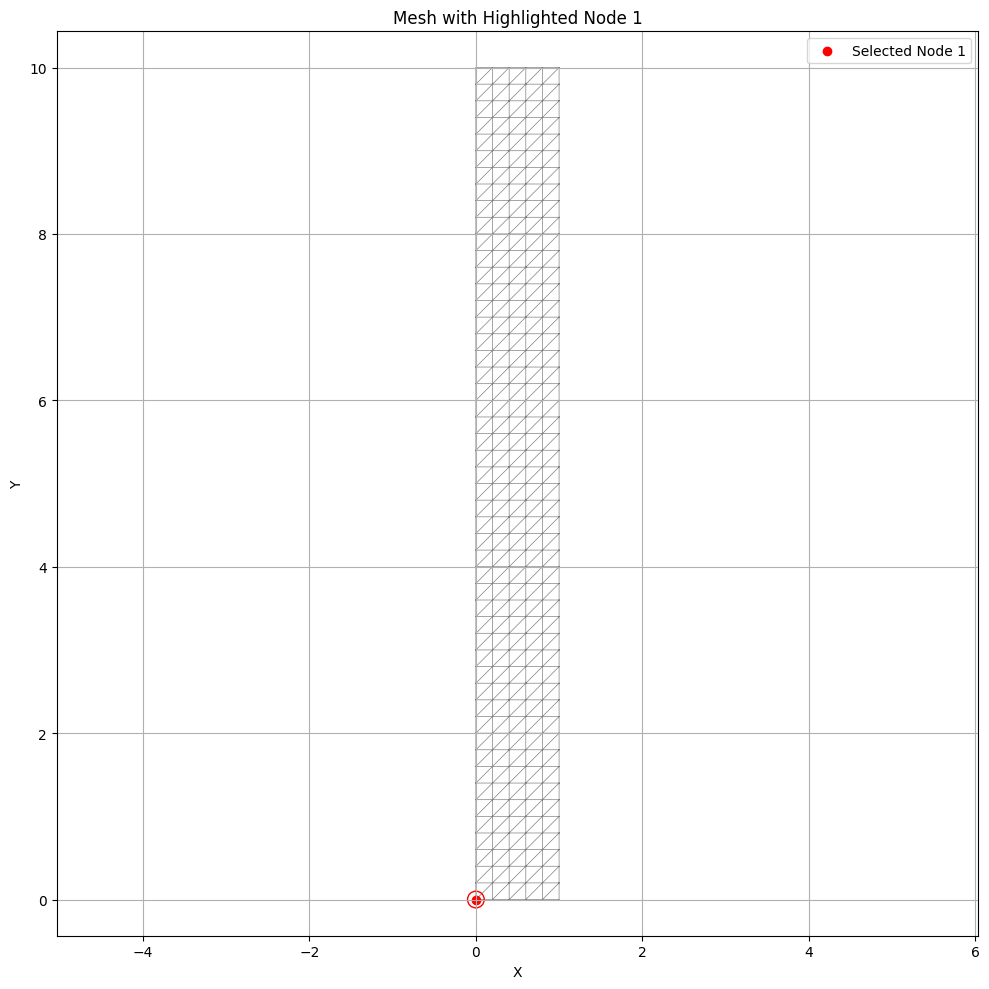

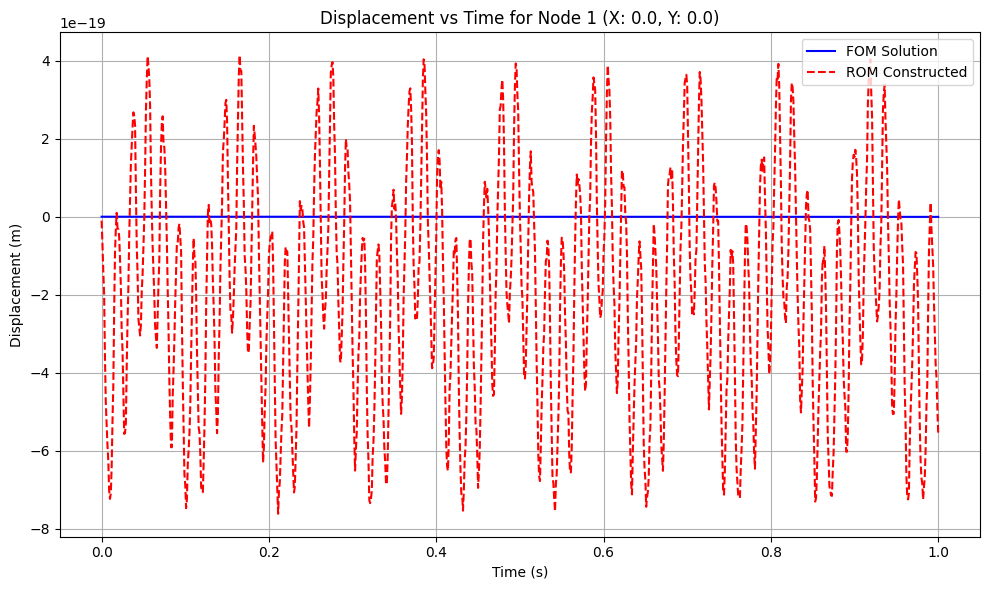

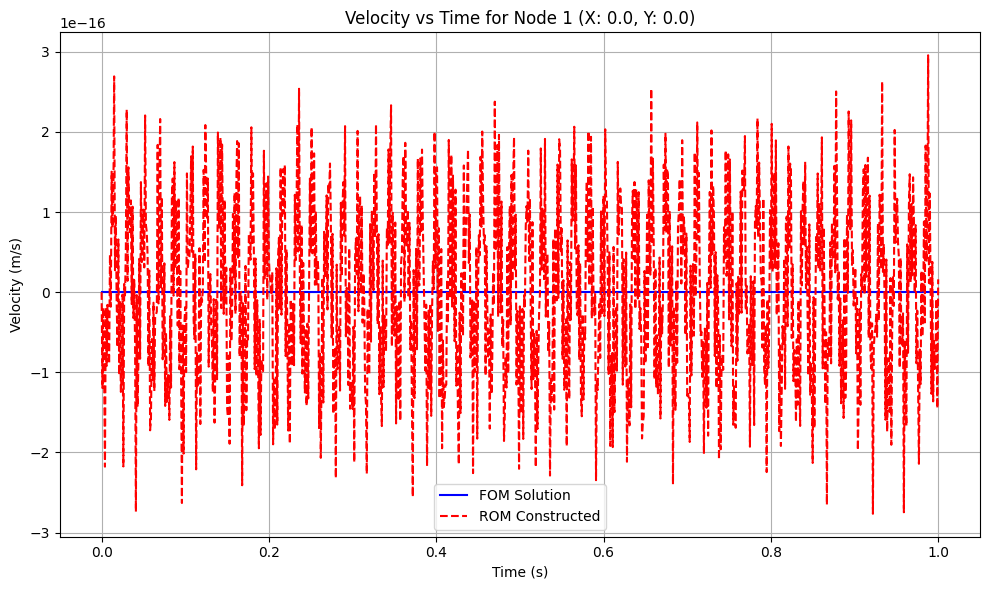

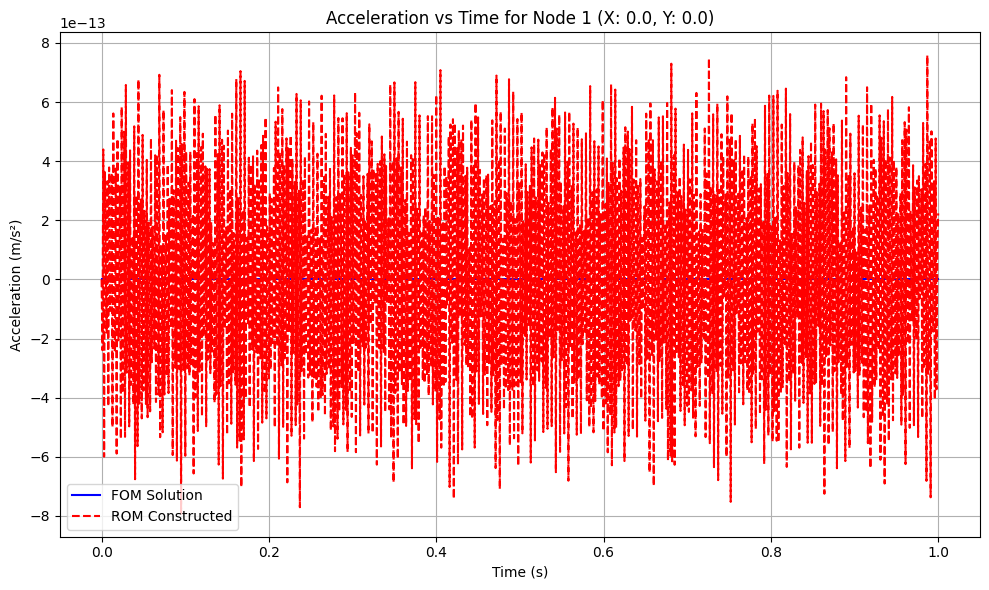

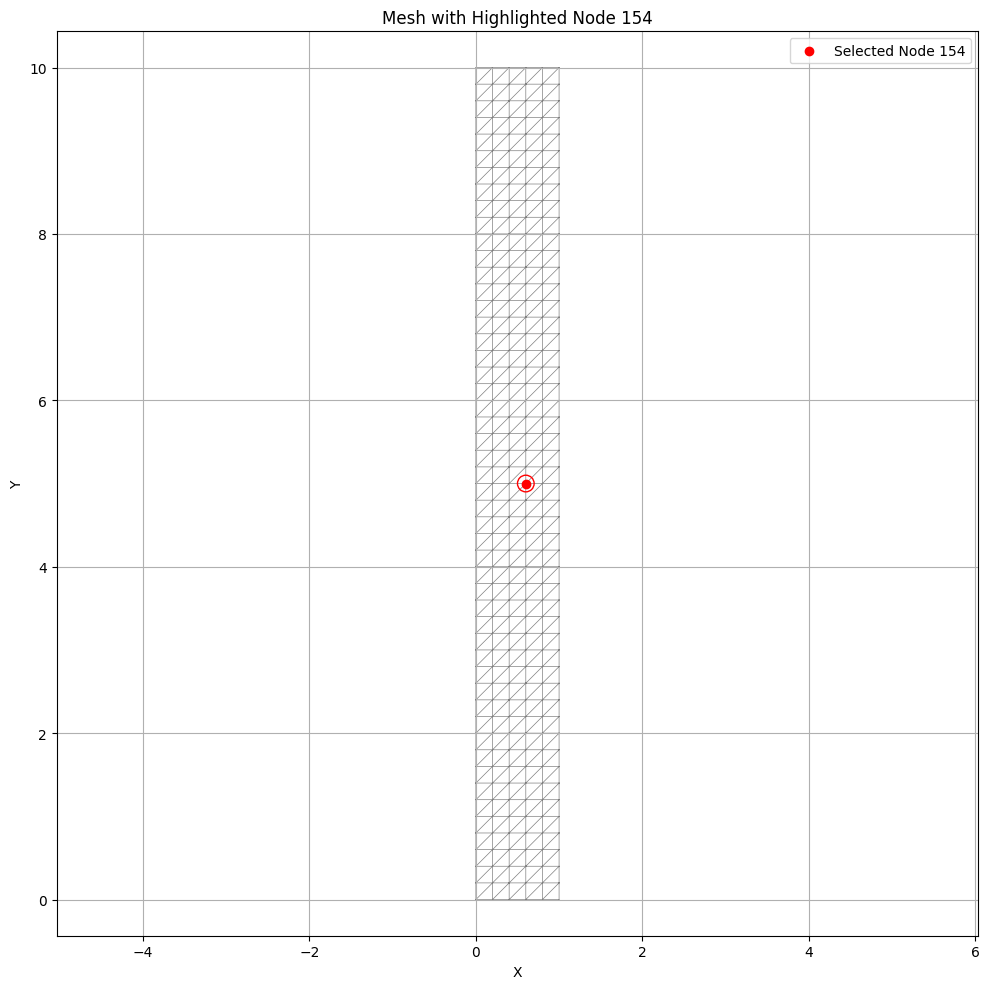

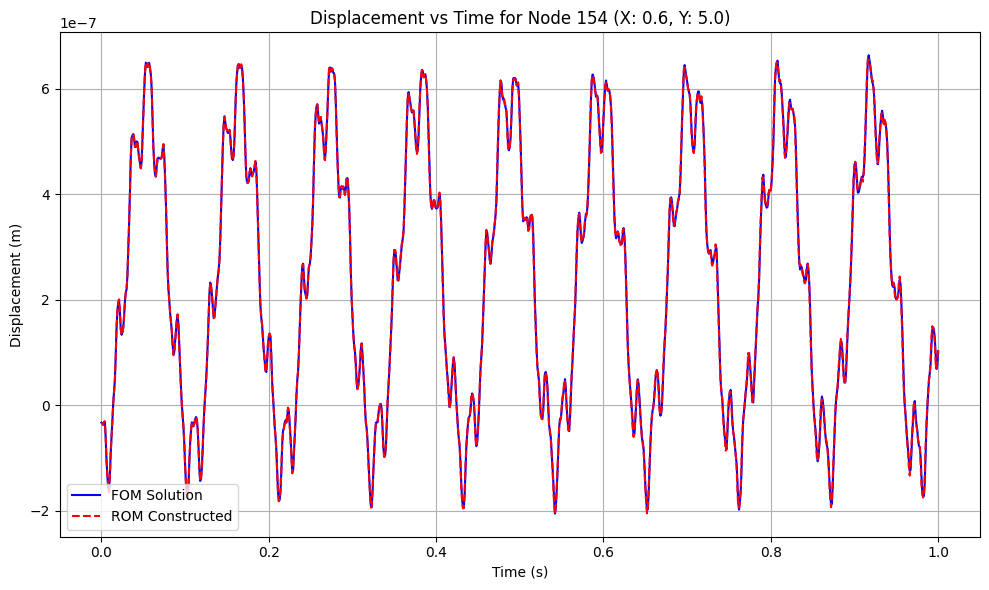

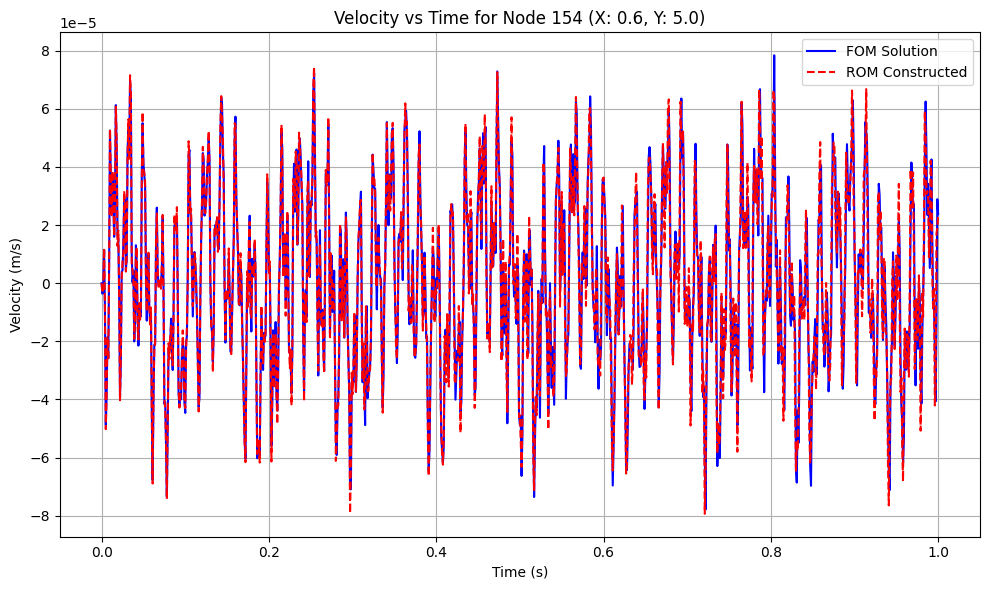

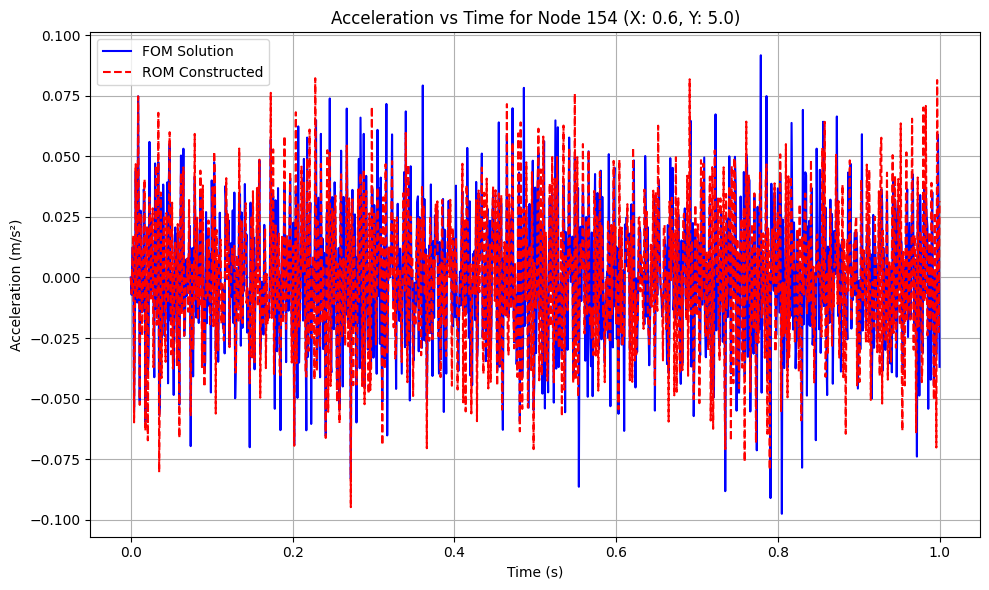

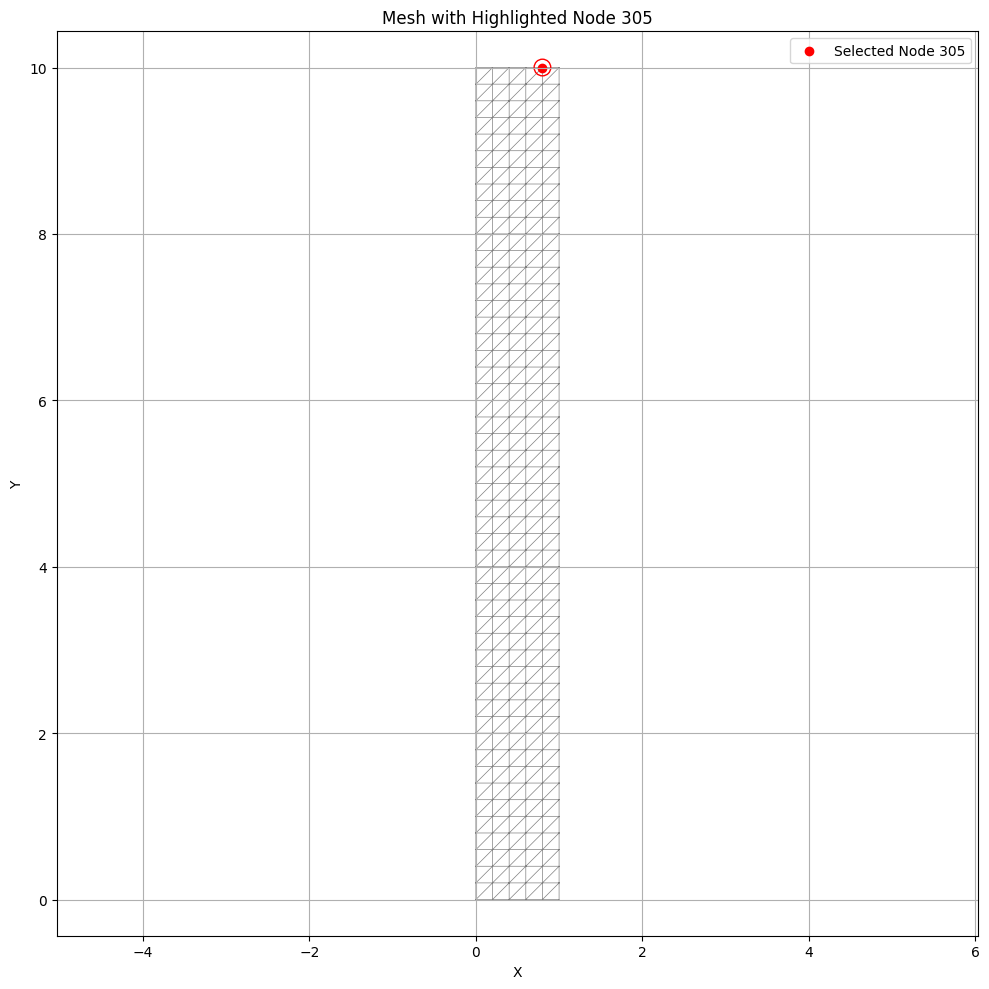

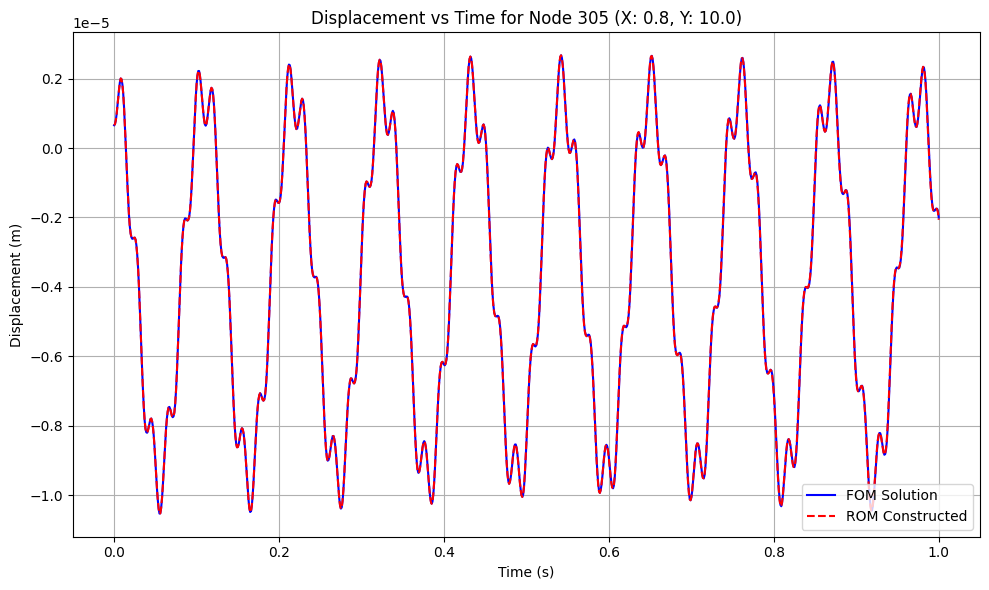

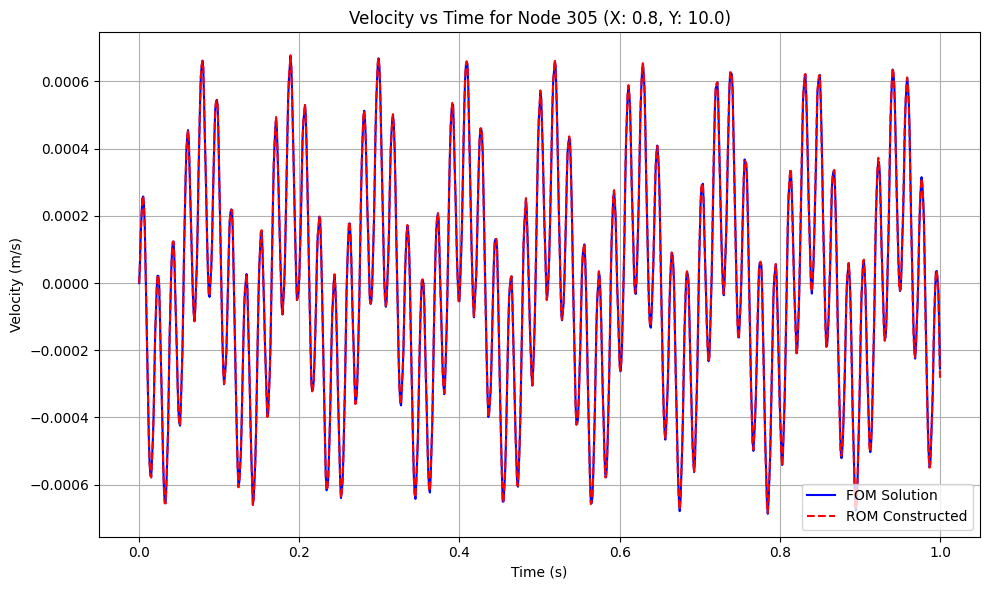

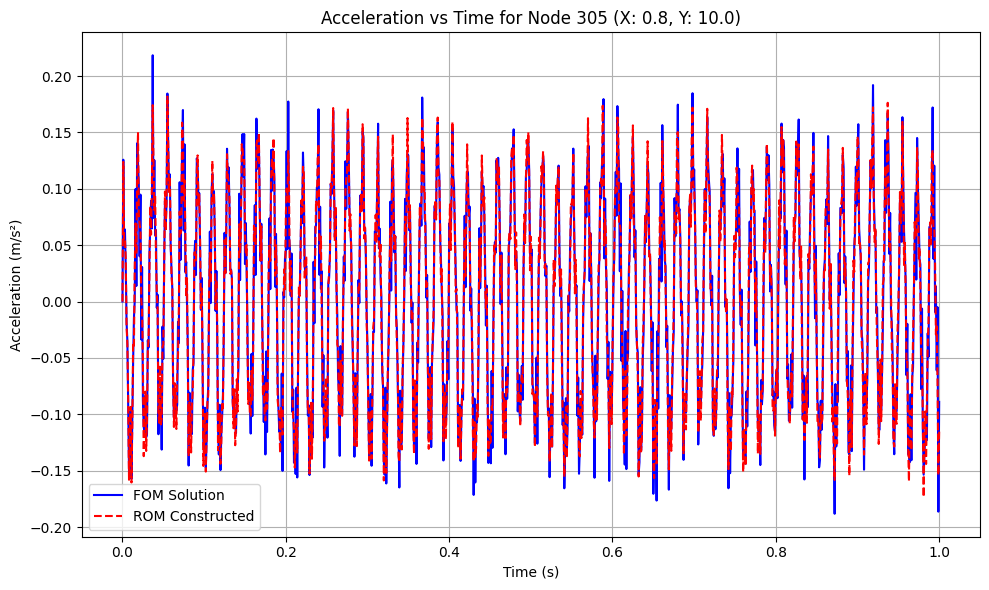

In [ ]:
from pathlib import Path

def plot_node_comparison(mdpa_file, node_ids, fom_folder, rom_folder, scale_factor=1e6):
    """
    Plot displacement, velocity, and acceleration vs. time for specified nodes.
    Compare FOM and ROM solutions.

    Parameters:
    -----------
    mdpa_file: str, path to the .mdpa file containing mesh information.
    node_ids: list of int, node IDs to analyze.
    fom_folder: Path, folder containing FOM solution data.
    rom_folder: Path, folder containing ROM solution data.
    scale_factor: float, scaling factor for displacements.
    """
    # Read mesh information from the .mdpa file
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    node_coords.append([int(parts[0]), float(parts[1]), float(parts[2])])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Load FOM solution data
    try:
        time_fom = np.load(fom_folder / 'time.npy')
        displacement_fom = np.load(fom_folder / 'displacement.npy')
        velocity_fom = np.load(fom_folder / 'velocity.npy')
        acceleration_fom = np.load(fom_folder / 'acceleration.npy')
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the FOM solution files exist in the specified folder.")
        return

    # Load ROM solution data
    try:
        time_rom = np.load(rom_folder / 'time.npy')
        displacement_rom = np.load(rom_folder / 'displacement.npy')
        velocity_rom = np.load(rom_folder / 'velocity.npy')
        acceleration_rom = np.load(rom_folder / 'acceleration.npy')
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the ROM solution files exist in the specified folder.")
        return

    # Highlight nodes and plot graphs
    for node_id in node_ids:
        # Find the node in the mesh
        selected_node = node_coords[node_coords[:, 0] == node_id][0]
        node_x, node_y = selected_node[1], selected_node[2]
        idx_array = np.where(node_coords[:, 0] == node_id)[0]
        if len(idx_array) == 0:
            print(f"Warning: Node ID {node_id} not found in the mesh. Skipping this node.")
            continue
        idx = idx_array[0]

        # Highlight the node on the mesh
        triangulation = tri.Triangulation(node_coords[:, 1], node_coords[:, 2], elements)
        plt.figure(figsize=(10, 10))
        plt.triplot(triangulation, 'k-', lw=0.5, alpha=0.5)
        plt.scatter(node_x, node_y, color='red', label=f'Selected Node {node_id}')
        plt.gca().add_artist(plt.Circle((node_x, node_y), radius=0.1, color='red', fill=False))
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Mesh with Highlighted Node {node_id}')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

        # Plot displacement vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_fom, displacement_fom[:, idx], label='FOM Solution', color='blue')
        plt.plot(time_rom, displacement_rom[:, idx], label='ROM Constructed', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Displacement (m)')
        plt.title(f'Displacement vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot velocity vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_fom, velocity_fom[:, idx], label='FOM Solution', color='blue')
        plt.plot(time_rom, velocity_rom[:, idx], label='ROM Constructed', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.title(f'Velocity vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot acceleration vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_fom, acceleration_fom[:, idx], label='FOM Solution', color='blue')
        plt.plot(time_rom, acceleration_rom[:, idx], label='ROM Constructed', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.title(f'Acceleration vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage
node_ids_to_analyze = [1, 154, 305]  # Replace with desired node IDs
# Print the path of the folder being accessed
cwd = Path.cwd()
folder_path = cwd / "Dynamic_solution" / "case_9_magnitude_(391.22, -286.75, 386.86)" / "FOM_Solution" / "solution"
rom_folder_path = cwd / "Dynamic_solution" / "case_9_magnitude_(391.22, -286.75, 386.86)" / "ROM_constructed"
print(f"Accessing FOM folder: {folder_path.resolve()}")
print(f"Accessing ROM folder: {rom_folder_path.resolve()}")

# List and print all files in the FOM folder
if folder_path.exists() and folder_path.is_dir():
    files = list(folder_path.iterdir())
    print("Files present in the FOM folder:")
    for file in files:
        print(file.name)
else:
    print(f"The FOM folder does not exist or is not a directory: {folder_path.resolve()}")

# List and print all files in the ROM folder
if rom_folder_path.exists() and rom_folder_path.is_dir():
    rom_files = list(rom_folder_path.iterdir())
    print("Files present in the ROM folder:")
    for file in rom_files:
        print(file.name)
else:
    print(f"The ROM folder does not exist or is not a directory: {rom_folder_path.resolve()}")

# Call the function
plot_node_comparison(mdpa_file, node_ids_to_analyze, folder_path, rom_folder_path)


In [ ]:
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path
import os
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def create_displacement_gif(folder_path, mdpa_file, scale_factor=1e6, step_interval=100):
    """
    Create a displacement GIF for a specific case.
    """
    folder_path = Path(folder_path)
    output_file = folder_path / 'displacement_animation.gif'

    print("=" * 80)
    print(f"🎯 Processing folder: {folder_path.resolve()}")

    # Load solution data
    time_file = folder_path / 'time.npy'
    displacement_file = folder_path / 'displacement.npy'
    print(f"📥 Reading displacement data from:")
    print(f"   ⏱️  Time data       : {time_file.resolve()}")
    print(f"   📌 Displacement data: {displacement_file.resolve()}")

    time = np.load(time_file)
    displacement = np.load(displacement_file)

    # Read node coordinates and elements from the .mdpa file
    print(f"📄 Reading mesh connectivity from: {mdpa_file.resolve()}")
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 15))

    # Base triangulation
    x = node_coords[:, 0]
    y = node_coords[:, 1]
    triangulation_orig = tri.Triangulation(x, y, elements)

    # Global displacement limits
    disp_magnitudes = []
    for step in range(len(time)):
        disp = displacement[step].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        disp_magnitudes.append(disp_mag)

    global_min = min(np.min(mag) for mag in disp_magnitudes)
    global_max = max(np.max(mag) for mag in disp_magnitudes)
    print(f"📊 Global displacement range: [{global_min:.2e}, {global_max:.2e}]")

    def update(frame):
        ax.clear()
        disp = displacement[frame].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        deformed_coords = node_coords + disp

        # Undeformed
        ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')

        # Deformed mesh
        triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
        tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                           vmin=global_min, vmax=global_max)
        ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
        ax.grid(True)
        ax.axis('equal')
        ax.legend()

        if frame == 0:
            plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
        plt.tight_layout()

    print("🛠️  Creating animation frames...")
    anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)

    # Save animation
    print(f"💾 Saving animation to: {output_file.resolve()}")
    writer = PillowWriter(fps=1000 / step_interval)
    anim.save(output_file, writer=writer)
    plt.close()
    print("✅ Animation complete!\n")
    return True

def process_cases(base_dir="Dynamic_solution", num_files=None):
    """
    Process cases in the Dynamic_solution directory.
    
    Args:
        base_dir: Base directory containing case folders
        num_files: Number of case files to process (None for all)
    """
    try:
        base_path = Path(base_dir)
        
        # Find all case folders
        case_folders = []
        for folder in base_path.glob("case_*_magnitude_*"):
            if (folder / "ROM_constructed").exists():
                case_folders.append(folder / "ROM_constructed")
        
        # Sort case folders by case number
        def extract_case_number(folder_path):
            # Extract the case number from the folder name
            folder_name = folder_path.parent.name
            return int(folder_name.split("_")[1])
        
        case_folders.sort(key=extract_case_number)
        
        total_cases = len(case_folders)
        print(f"Found {total_cases} case folders with 'ROM_constructed' subdirectory.")
        
        if total_cases == 0:
            print("No valid case folders found. Exiting.")
            return
            
        # Find mdpa file in the current directory
        mdpa_files = list(Path(os.getcwd()).glob("*.mdpa"))
        if not mdpa_files:
            print("Error: No .mdpa file found in the current directory.")
            return
        mdpa_file = mdpa_files[0]
        print(f"Using mesh file: {mdpa_file}")
        
        # Get number of files to process
        if num_files is None:
            try:
                user_input = input(f"How many case files would you like to process? (Enter 'all' for all {total_cases} folders): ")
                if user_input.lower() == 'all':
                    num_files = total_cases
                else:
                    num_files = int(user_input)
                    if num_files <= 0 or num_files > total_cases:
                        print(f"Invalid number. Using all {total_cases} files.")
                        num_files = total_cases
            except ValueError:
                print(f"Invalid input. Processing all {total_cases} files.")
                num_files = total_cases
        else:
            # Ensure num_files is valid
            num_files = min(max(1, num_files), total_cases)
        
        # Limit to the specified number of files
        case_folders = case_folders[:num_files]
        
        print(f"\nWill process {len(case_folders)} of {total_cases} cases:")
        for folder in case_folders:
            print(f"  {folder.parent.name}")
        
        # Process each case
        successful = 0
        failed = 0
        
        for folder in case_folders:
            try:
                print("\n" + "=" * 50)
                print(f"Processing case: {folder.parent.name}")
                if create_displacement_gif(folder, mdpa_file, scale_factor=1e6):
                    successful += 1
                else:
                    failed += 1
            except Exception as e:
                print(f"Error processing {folder.parent.name}: {str(e)}")
                failed += 1
                
        print("\n" + "=" * 50)
        print("Processing Complete!")
        print(f"Successfully processed: {successful} cases")
        print(f"Failed to process: {failed} cases")
        print(f"Skipped: {total_cases - num_files} cases")
        print("=" * 50)
        
    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()

# For Jupyter notebooks
def run_gif_processing(base_dir="Dynamic_solution", num_files=None):
    """Function to call from Jupyter notebook cells"""
    process_cases(base_dir=base_dir, num_files=num_files)

# Run directly if not in a Jupyter environment
if __name__ == "__main__":
    run_gif_processing()

Found 10 case folders with 'ROM_constructed' subdirectory.
Using mesh file: d:\Submission_Documents\2D_beam_udl_loading\2D_beam_udl_loading.mdpa

Will process 1 of 10 cases:
  case_1_magnitude_(-137.59, -63.13, 362.93)

Processing case: case_1_magnitude_(-137.59, -63.13, 362.93)
🎯 Processing folder: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\ROM_constructed
📥 Reading displacement data from:
   ⏱️  Time data       : D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\ROM_constructed\time.npy
   📌 Displacement data: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\ROM_constructed\displacement.npy
📄 Reading mesh connectivity from: D:\Submission_Documents\2D_beam_udl_loading\2D_beam_udl_loading.mdpa
📊 Global displacement range: [1.43e-17, 8.95e+00]
🛠️  Creating animation frames...
💾 Saving animation to: D:\Submission_Documen

In [ ]:
# ROM Direct Method Implementation
#
# The code below implements the Reduced Order Model (ROM) direct method solution, including:
# - SVD Analysis: Compute reduced basis and determine optimal modes
# - Data Projection: Project full order data onto reduced basis
# - System Identification: Identify reduced mass and stiffness matrices
# - ROM Solution: Solve the reduced order system and reconstruct full solution
# - Error Analysis: Compare ROM results with full order model
#
# The following sections contain the implementation details for each step.


In [ ]:
# Calculate reduced system matrices
M_tilde_std = V_r.T @ M_constrained @ V_r
K_tilde_std = V_r.T @ K_constrained @ V_r

# Print shapes and comparison with previously calculated matrices
print("\nReduced System Matrices (Standard Projection):")
print(f"M_tilde_std shape: {M_tilde_std.shape}")
print(f"K_tilde_std shape: {K_tilde_std.shape}")

# Compare with previously calculated matrices
print("\nComparison with least squares solution:")
print(f"M_tilde_std max difference: {np.max(np.abs(M_tilde_std - M_tilde))}")
print(f"K_tilde_std max difference: {np.max(np.abs(K_tilde_std - K_tilde))}")


Reduced System Matrices (Standard Projection):
M_tilde_std shape: (12, 12)
K_tilde_std shape: (12, 12)

Comparison with least squares solution:
M_tilde_std max difference: 88.81340481351083
K_tilde_std max difference: 7688202652.143929


In [ ]:
import numpy as np
from tabulate import tabulate

def check_matrix_properties(matrix, name):
    """
    Check and return properties of a matrix.
    
    Parameters:
    - matrix: The matrix to check.
    - name: Name of the matrix (for display purposes).
    
    Returns:
    - dict: A dictionary containing the properties of the matrix.
    """
    properties = {}
    properties["Matrix"] = name
    properties["Shape"] = matrix.shape
    properties["Symmetric"] = np.allclose(matrix, matrix.T, atol=1e-8)
    properties["Real Values"] = np.isreal(matrix).all()
    properties["Positive Values"] = (matrix > 0).all()
    eigenvalues = np.linalg.eigvals(matrix)
    properties["Real Eigenvalues"] = np.isreal(eigenvalues).all()
    properties["Positive Eigenvalues"] = (eigenvalues > 0).all()
    properties["Min Eigenvalue"] = np.min(eigenvalues).real if np.isreal(eigenvalues).all() else "Complex"
    properties["Max Eigenvalue"] = np.max(eigenvalues).real if np.isreal(eigenvalues).all() else "Complex"
    properties["Condition Number"] = np.linalg.cond(matrix)
    return properties

# Check properties of M_tilde and K_tilde
M_tilde_properties = check_matrix_properties(M_tilde_std, "M_tilde Standard")
K_tilde_properties = check_matrix_properties(K_tilde_std, "K_tilde Standard")

# Tabulate the results
table = [M_tilde_properties, K_tilde_properties]
headers = ["Property", "M_tilde Standard", "K_tilde Standard"]
rows = [
    ["Shape", M_tilde_properties["Shape"], K_tilde_properties["Shape"]],
    ["Symmetric", M_tilde_properties["Symmetric"], K_tilde_properties["Symmetric"]],
    ["Real Values", M_tilde_properties["Real Values"], K_tilde_properties["Real Values"]],
    ["Positive Values", M_tilde_properties["Positive Values"], K_tilde_properties["Positive Values"]],
    ["Real Eigenvalues", M_tilde_properties["Real Eigenvalues"], K_tilde_properties["Real Eigenvalues"]],
    ["Positive Eigenvalues", M_tilde_properties["Positive Eigenvalues"], K_tilde_properties["Positive Eigenvalues"]],
    ["Min Eigenvalue", M_tilde_properties["Min Eigenvalue"], K_tilde_properties["Min Eigenvalue"]],
    ["Max Eigenvalue", M_tilde_properties["Max Eigenvalue"], K_tilde_properties["Max Eigenvalue"]],
    ["Condition Number", f"{M_tilde_properties['Condition Number']:.2e}", f"{K_tilde_properties['Condition Number']:.2e}"],
]

print("\nMatrix Properties:")
print(tabulate(rows, headers=headers, tablefmt="grid"))


Matrix Properties:
+----------------------+--------------------+--------------------+
| Property             | M_tilde Standard   | K_tilde Standard   |
+======================+====================+====================+
| Shape                | (12, 12)           | (12, 12)           |
+----------------------+--------------------+--------------------+
| Symmetric            | True               | True               |
+----------------------+--------------------+--------------------+
| Real Values          | True               | True               |
+----------------------+--------------------+--------------------+
| Positive Values      | False              | False              |
+----------------------+--------------------+--------------------+
| Real Eigenvalues     | True               | True               |
+----------------------+--------------------+--------------------+
| Positive Eigenvalues | True               | True               |
+----------------------+------------------

In [ ]:
output_dir, case_results, case_times = solve_newmark_dynamic_multi_case(
    M=M_tilde_std,
    K=K_tilde_std,
    f=f_reduced,
    magnitudes=magnitudes,
    x=x_reduced,
    total_time=1.0,
    dt=1e-3,
    beta=0.25,
    gamma=0.5,
    tol=1e-8,
    max_iter=50,
    subfolder_name="ROM_Solution_standard"
)


Function called with:
M: (12, 12), K: (12, 12), f: (12, 10), magnitudes: [(-137.59, -63.13, 362.93), (-198.79, 228.5, -134.8), (104.64, -25.63, 160.89), (17.45, -13.32, 69.69), (186.02, 35.84, -213.65), (229.73, -34.4, -232.19), (34.88, -235.52, 250.55), (379.97, -275.91, -44.58), (391.22, -286.75, 386.86), (75.24, 90.42, 11.42)], x: (12, 10)

Continuing without resetting the folder.

Starting multi-case dynamic analysis...
Number of DOFs: 12
Number of cases: 10


Processing cases:  10%|█         | 1/10 [00:00<00:01,  8.90it/s]


Solving case 1/10
Magnitude: (-137.59, -63.13, 362.93)
✅ All time steps converged successfully.

Solving case 2/10
Magnitude: (-198.79, 228.5, -134.8)
✅ All time steps converged successfully.

Solving case 3/10
Magnitude: (104.64, -25.63, 160.89)


Processing cases:  50%|█████     | 5/10 [00:00<00:00, 16.04it/s]

✅ All time steps converged successfully.

Solving case 4/10
Magnitude: (17.45, -13.32, 69.69)
✅ All time steps converged successfully.

Solving case 5/10
Magnitude: (186.02, 35.84, -213.65)
✅ All time steps converged successfully.

Solving case 6/10
Magnitude: (229.73, -34.4, -232.19)
✅ All time steps converged successfully.

Solving case 7/10
Magnitude: (34.88, -235.52, 250.55)


Processing cases: 100%|██████████| 10/10 [00:00<00:00, 16.80it/s]

✅ All time steps converged successfully.

Solving case 8/10
Magnitude: (379.97, -275.91, -44.58)
✅ All time steps converged successfully.

Solving case 9/10
Magnitude: (391.22, -286.75, 386.86)
✅ All time steps converged successfully.

Solving case 10/10
Magnitude: (75.24, 90.42, 11.42)
✅ All time steps converged successfully.

Results Summary:
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude                 |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+===========================+====================+================+====================+==================+
|      1 | (-137.59, -63.13, 362.93) |           7.81e-05 |       0.00274  |              0.969 |             0.09 |
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|      2 | (-198.79, 228.5, -134.8)  |           0.000303 |       0.

In [ ]:
import os
from pathlib import Path
from tabulate import tabulate

# Get the current working directory
cwd = Path.cwd()

# Navigate to the "Dynamic_solution" directory
dynamic_solution_dir = cwd / "Dynamic_solution"

# Initialize a list to store the tabulated data
tabulated_data = []

# Iterate through all case folders and collect data
for case_folder in sorted(dynamic_solution_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_dir = case_folder / "ROM_Solution_standard" / "solution"
    # Check if the directory exists
    if rom_dir.exists() and rom_dir.is_dir():
        case_data = [case_folder.name]  # Initialize row with case folder name
        # Iterate through all files in the directory
        for file in sorted(rom_dir.iterdir()):
            if file.is_file():
                # Get the size of the file in bytes
                file_size = os.path.getsize(file)
                # Load the file content if it's a numpy file
                if file.suffix == '.npy':
                    data = np.load(file)
                    case_data.append(f"{file.name}: {data.shape}")
                else:
                    case_data.append(f"{file.name}: N/A")
        tabulated_data.append(case_data)
    else:
        tabulated_data.append([case_folder.name, "Directory does not exist"])

# Print the tabulated data
headers = ["Case Folder"] + [f"File {i+1}" for i in range(len(tabulated_data[0]) - 1)]
print(tabulate(tabulated_data, headers=headers, tablefmt="grid"))

+--------------------------------------------+------------------------------+------------------------------+-----------------------+-------------------+--------------------------+
| Case Folder                                | File 1                       | File 2                       | File 3                | File 4            | File 5                   |
+============================================+==============================+==============================+=======================+===================+==========================+
| case_1_magnitude_(-137.59, -63.13, 362.93) | acceleration.npy: (1001, 12) | displacement.npy: (1001, 12) | force.npy: (1001, 12) | time.npy: (1001,) | velocity.npy: (1001, 12) |
+--------------------------------------------+------------------------------+------------------------------+-----------------------+-------------------+--------------------------+
| case_2_magnitude_(-198.79, 228.5, -134.8)  | acceleration.npy: (1001, 12) | displacement.npy: (100

In [ ]:
import os
import numpy as np
from pathlib import Path
from tabulate import tabulate

# Define base path and target variables
base_dir = Path.cwd() / "Dynamic_solution"
variables = ["displacement", "velocity", "acceleration", "force"]

# Display V_r shape once
print(f"\n{'='*100}")
print(f"{'FULL-ORDER RECONSTRUCTION USING REDUCED BASIS':^100}")
print(f"{'='*100}")
print(f"Using V_r of shape: {V_r.shape} (DOFs × Modes)")

# Table to store case summary
tabulated_data = []

# Process each case
for case_folder in sorted(base_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_input_dir = case_folder / "ROM_Solution_standard" / "solution"
    rom_output_dir = case_folder / "ROM_standard_constructed"
    rom_output_dir.mkdir(parents=True, exist_ok=True)

    case_data = [case_folder.name]

    if rom_input_dir.exists():
        for var in variables:
            input_file = rom_input_dir / f"{var}.npy"
            output_file = rom_output_dir / f"{var}.npy"

            if input_file.exists():
                reduced_data = np.load(input_file)

                # Validate shape
                if reduced_data.shape[1] != V_r.shape[1]:
                    case_data.append(f"{var}: shape mismatch")
                    continue

                # Reconstruct and save
                full_data = reduced_data @ V_r.T  # Shape: (time_steps, dofs)
                np.save(output_file, full_data)
                case_data.append(f"{var}.npy: {full_data.shape}")
            else:
                case_data.append(f"{var}: missing")
    else:
        case_data.append("ROM_Solution missing")

    tabulated_data.append(case_data)

# Build and display table
headers = ["Case Folder"] + [var.capitalize() for var in variables]
max_len = max(len(row) for row in tabulated_data)
for row in tabulated_data:
    while len(row) < max_len:
        row.append("")

print("\n" + "=" * 100)
print(" RECONSTRUCTED FULL-ORDER MATRICES FROM REDUCED VARIABLES ".center(100))
print("=" * 100)
print(tabulate(tabulated_data, headers=headers, tablefmt="grid"))



                           FULL-ORDER RECONSTRUCTION USING REDUCED BASIS                            
Using V_r of shape: (612, 12) (DOFs × Modes)

                      RECONSTRUCTED FULL-ORDER MATRICES FROM REDUCED VARIABLES                      
+--------------------------------------------+-------------------------------+---------------------------+-------------------------------+------------------------+
| Case Folder                                | Displacement                  | Velocity                  | Acceleration                  | Force                  |
+============================================+===============================+===========================+===============================+========================+
| case_1_magnitude_(-137.59, -63.13, 362.93) | displacement.npy: (1001, 612) | velocity.npy: (1001, 612) | acceleration.npy: (1001, 612) | force.npy: (1001, 612) |
+--------------------------------------------+-------------------------------+-----------------

In [ ]:
import os
import numpy as np
from pathlib import Path
from tabulate import tabulate

# Define the base directory
base_dir = Path("Dynamic_solution")

# Initialize a list to store the tabulated data
table_data = []

# Iterate through all case folders
for case_folder in sorted(base_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_constructed_dir = case_folder / "ROM_standard_constructed"
    if rom_constructed_dir.exists() and rom_constructed_dir.is_dir():
        case_name = case_folder.name
        displacement_file = rom_constructed_dir / "displacement.npy"
        velocity_file = rom_constructed_dir / "velocity.npy"
        acceleration_file = rom_constructed_dir / "acceleration.npy"

        # Initialize variables to store max values, shapes, and file paths
        max_displacement = max_velocity = max_acceleration = "N/A"
        displacement_shape = velocity_shape = acceleration_shape = "N/A"
        displacement_path = velocity_path = acceleration_path = "N/A"

        # Read displacement
        if displacement_file.exists():
            displacement_data = np.load(displacement_file)
            max_displacement = np.max(np.abs(displacement_data))
            displacement_shape = displacement_data.shape
            displacement_path = str(displacement_file)

        # Read velocity
        if velocity_file.exists():
            velocity_data = np.load(velocity_file)
            max_velocity = np.max(np.abs(velocity_data))
            velocity_shape = velocity_data.shape
            velocity_path = str(velocity_file)

        # Read acceleration
        if acceleration_file.exists():
            acceleration_data = np.load(acceleration_file)
            max_acceleration = np.max(np.abs(acceleration_data))
            acceleration_shape = acceleration_data.shape
            acceleration_path = str(acceleration_file)

        # Append the data to the table
        table_data.append([
            case_name,
            displacement_shape, max_displacement, displacement_path,
            velocity_shape, max_velocity, velocity_path,
            acceleration_shape, max_acceleration, acceleration_path
        ])

# Define the headers
headers = [
    "Case Name",
    "Displacement Shape", "Max Displacement", "Displacement Path",
    "Velocity Shape", "Max Velocity", "Velocity Path",
    "Acceleration Shape", "Max Acceleration", "Acceleration Path"
]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+--------------------------------------------+----------------------+--------------------+-------------------------------------------------------------------------------------------------------+------------------+----------------+---------------------------------------------------------------------------------------------------+----------------------+--------------------+-------------------------------------------------------------------------------------------------------+
| Case Name                                  | Displacement Shape   |   Max Displacement | Displacement Path                                                                                     | Velocity Shape   |   Max Velocity | Velocity Path                                                                                     | Acceleration Shape   |   Max Acceleration | Acceleration Path                                                                                     |
+=========================================

In [ ]:
import numpy as np
from pathlib import Path
from tabulate import tabulate
from scipy.interpolate import interp1d

# Define the base directory for the cases
base_dir = Path.cwd() / "Dynamic_solution"
variables = ["displacement", "velocity", "acceleration", "force"]

# Initialize a list to store the tabulated data
comparison_results = []

# Define the `results` variable based on the `magnitudes` list
results = [{"case": i + 1, "magnitude": magnitude} for i, magnitude in enumerate(magnitudes)]

# Iterate through all cases
for case in results:
    case_folder_name = f"case_{case['case']}_magnitude_({', '.join(map(str, case['magnitude']))})"
    case_folder = base_dir / case_folder_name
    fom_dir = case_folder / "FOM_Solution" / "solution"
    rom_dir = case_folder / "ROM_standard_constructed"

    case_errors = {"Case": case_folder_name}

    if fom_dir.exists() and rom_dir.exists():
        for variable in variables:
            fom_file = fom_dir / f"{variable}.npy"
            rom_file = rom_dir / f"{variable}.npy"

            if fom_file.exists() and rom_file.exists():
                fom_data = np.load(fom_file)  # (time_steps, dofs)
                rom_data = np.load(rom_file)  # (time_steps, dofs)

                # Interpolate ROM if needed
                if fom_data.shape[0] != rom_data.shape[0]:
                    rom_steps = rom_data.shape[0]
                    interpolator = interp1d(
                        np.linspace(0, 1, rom_steps),
                        rom_data, axis=0, kind='linear', fill_value="extrapolate"
                    )
                    rom_data = interpolator(np.linspace(0, 1, fom_data.shape[0]))

                # Final shape check
                if fom_data.shape != rom_data.shape:
                    case_errors[variable.capitalize()] = f"Shape mismatch: FOM {fom_data.shape}, ROM {rom_data.shape}"
                    continue

                # Compute error and accuracy
                error = np.linalg.norm(fom_data - rom_data) / np.linalg.norm(fom_data)
                accuracy = max(0.0, (1.0 - error)) * 100
                case_errors[variable.capitalize()] = f"{error:.2e} (Accuracy: {accuracy:.2f}%)"
            else:
                case_errors[variable.capitalize()] = "Missing Data"
    else:
        for variable in variables:
            case_errors[variable.capitalize()] = "Missing FOM or ROM"

    comparison_results.append(case_errors)

# Build and display table
headers = ["Case"] + [var.capitalize() for var in variables]

print("\n" + "=" * 100)
print(" COMPARISON OF FOM AND ROM VARIABLES ".center(100))
print("=" * 100)
print(tabulate(comparison_results, headers="keys", tablefmt="grid"))



                                COMPARISON OF FOM AND ROM VARIABLES                                 
+--------------------------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| Case                                       | Displacement                | Velocity                    | Acceleration                | Force                       |
+============================================+=============================+=============================+=============================+=============================+
| case_1_magnitude_(-137.59, -63.13, 362.93) | 2.85e-03 (Accuracy: 99.71%) | 9.01e-02 (Accuracy: 90.99%) | 7.83e-01 (Accuracy: 21.73%) | 8.43e-01 (Accuracy: 15.67%) |
+--------------------------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| case_2_magnitude_(-198.79, 228.5, -134.8)  | 7.62e-04 (Accura

In [ ]:
from pathlib import Path
import numpy as np
import shutil

# Define the base directory containing all cases
base_dir = Path("Dynamic_solution")

# Iterate through all case folders
for case_folder in sorted(base_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_solution_path = case_folder / "ROM_Solution_standard" / "solution"
    rom_constructed_path = case_folder / "ROM_standard_constructed"

    # Ensure the ROM_Constructed directory exists
    rom_constructed_path.mkdir(parents=True, exist_ok=True)

    # Copy the time.npy file from ROM_Solution/solution to ROM_Constructed
    time_file = rom_solution_path / "time.npy"
    if time_file.exists():
        shutil.copy(time_file, rom_constructed_path)
        print(f"Copied {time_file.name} to {rom_constructed_path.resolve()}")
    else:
        print(f"{time_file.name} does not exist in {rom_solution_path.resolve()}")

    # Print the shape of all .npy files in the ROM_Constructed folder
    if rom_constructed_path.exists() and rom_constructed_path.is_dir():
        print(f"\nReading .npy files from: {rom_constructed_path.resolve()}\n")
        for npy_file in rom_constructed_path.glob("*.npy"):
            data = np.load(npy_file)
            print(f"{npy_file.name}: shape={data.shape}")
    else:
        print(f"Directory does not exist: {rom_constructed_path.resolve()}")


Copied time.npy to D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\ROM_standard_constructed

Reading .npy files from: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\ROM_standard_constructed

acceleration.npy: shape=(1001, 612)
displacement.npy: shape=(1001, 612)
force.npy: shape=(1001, 612)
time.npy: shape=(1001,)
velocity.npy: shape=(1001, 612)
Copied time.npy to D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_2_magnitude_(-198.79, 228.5, -134.8)\ROM_standard_constructed

Reading .npy files from: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_2_magnitude_(-198.79, 228.5, -134.8)\ROM_standard_constructed

acceleration.npy: shape=(1001, 612)
displacement.npy: shape=(1001, 612)
force.npy: shape=(1001, 612)
time.npy: shape=(1001,)
velocity.npy: shape=(1001, 612)
Copied time.npy to D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\

Accessing FOM folder: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_9_magnitude_(391.22, -286.75, 386.86)\FOM_Solution\solution
Accessing ROM folder: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_9_magnitude_(391.22, -286.75, 386.86)\ROM_standard_constructed
Files present in the FOM folder:
acceleration.npy
displacement.npy
force.npy
time.npy
velocity.npy
Files present in the ROM folder:
acceleration.npy
displacement.npy
force.npy
time.npy
velocity.npy


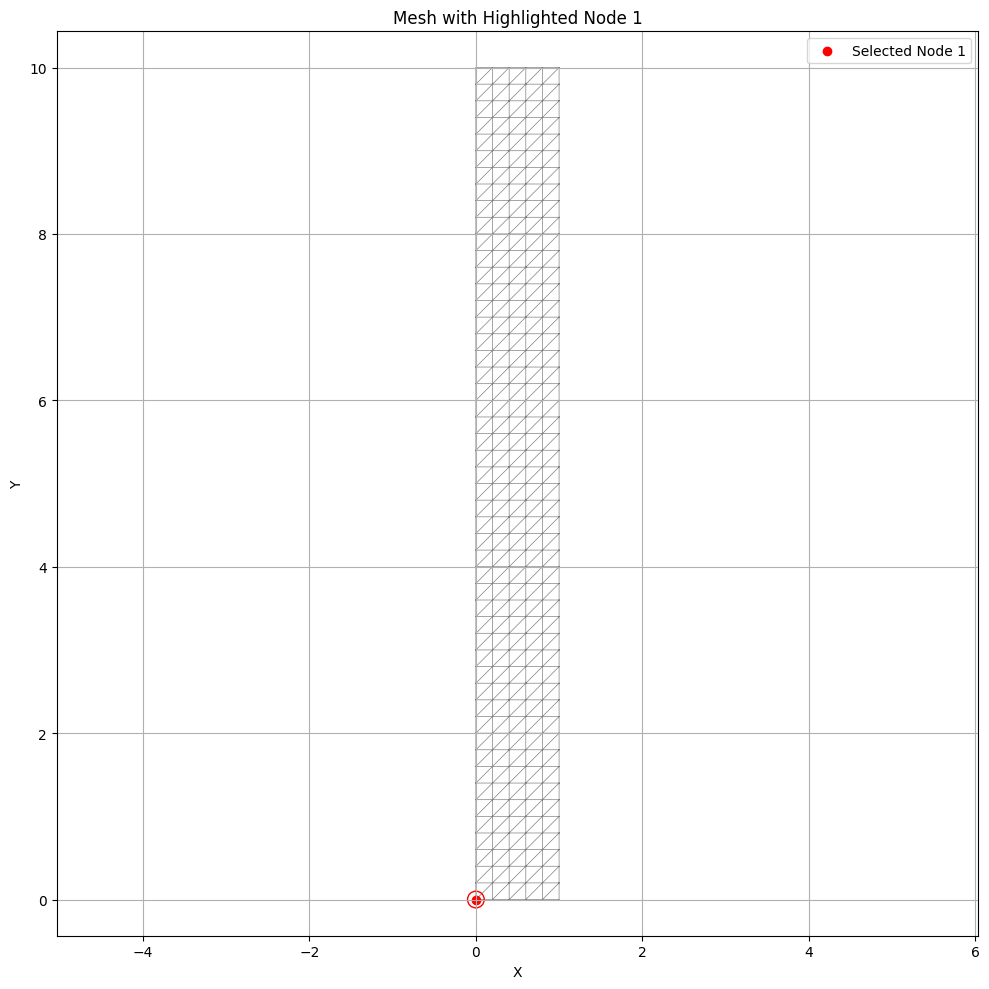

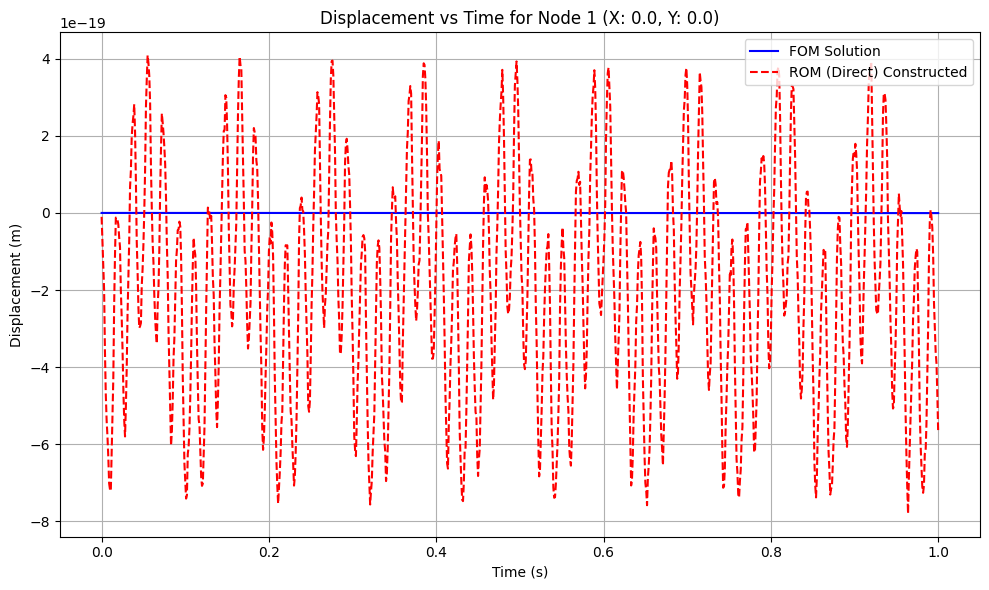

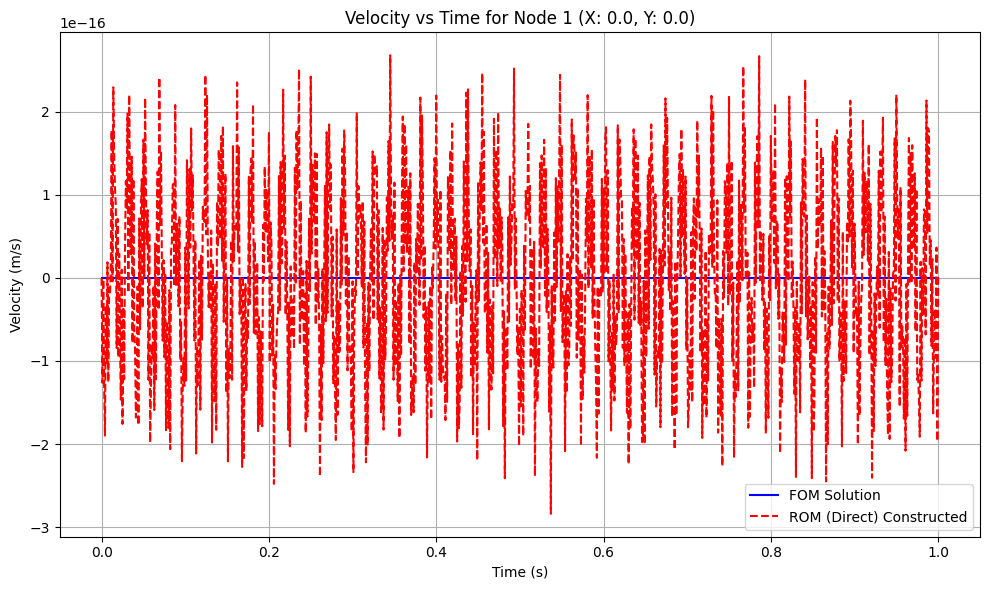

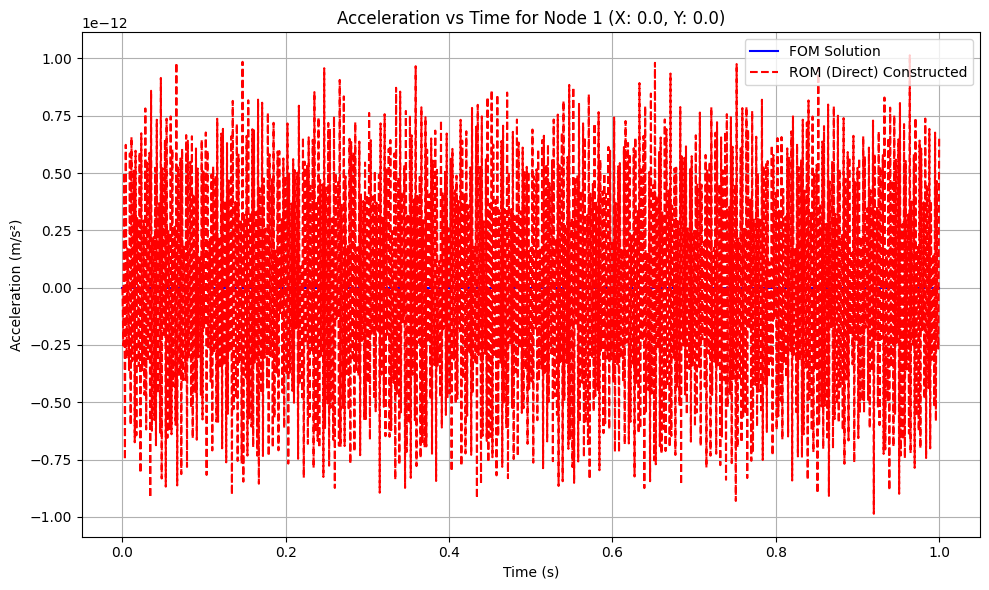

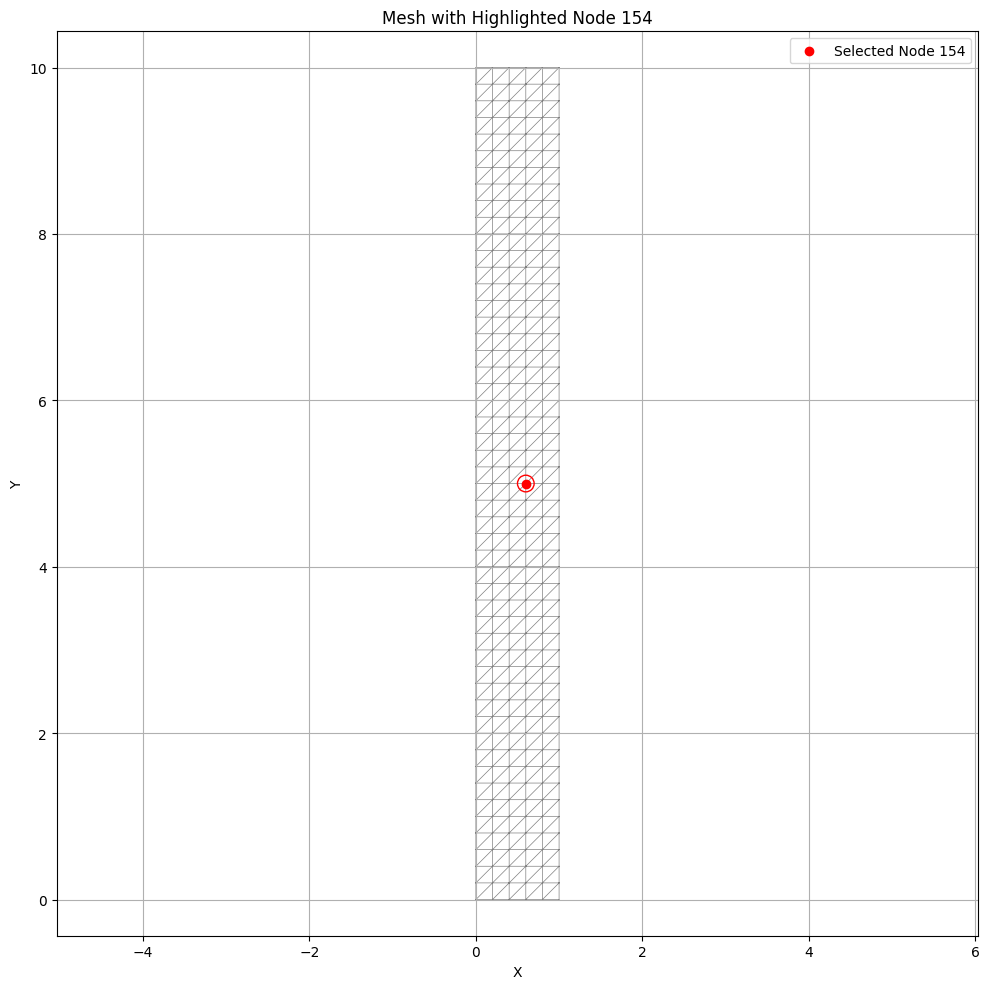

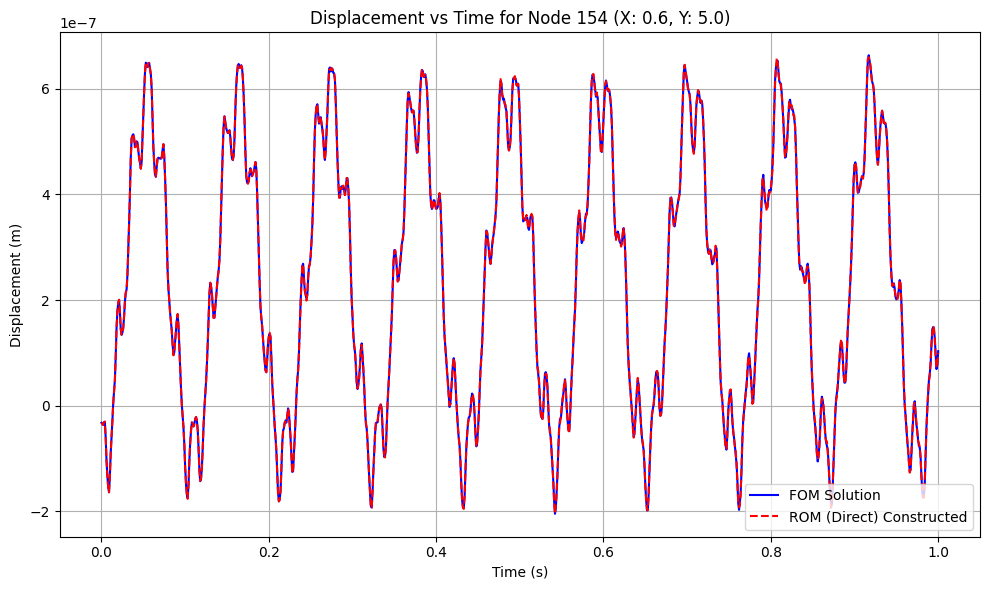

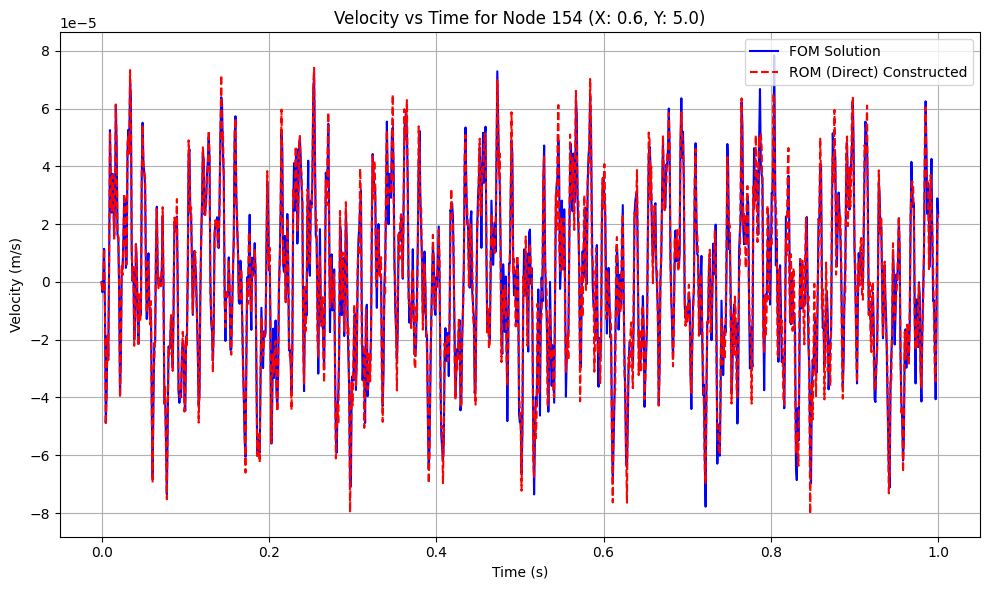

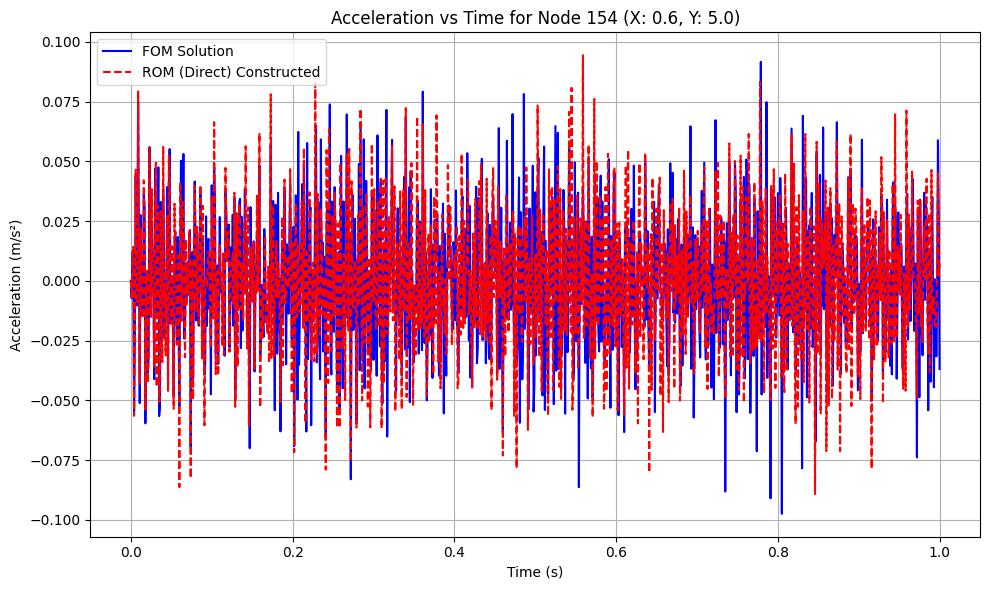

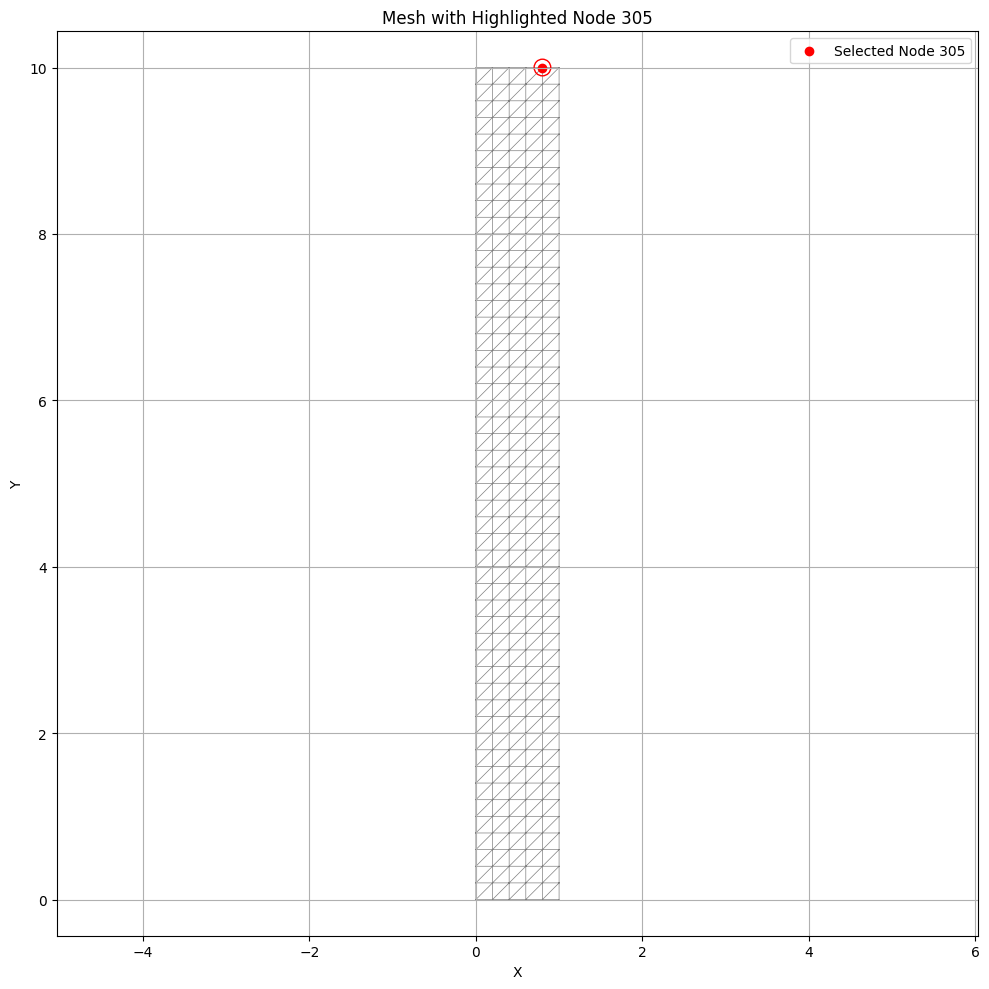

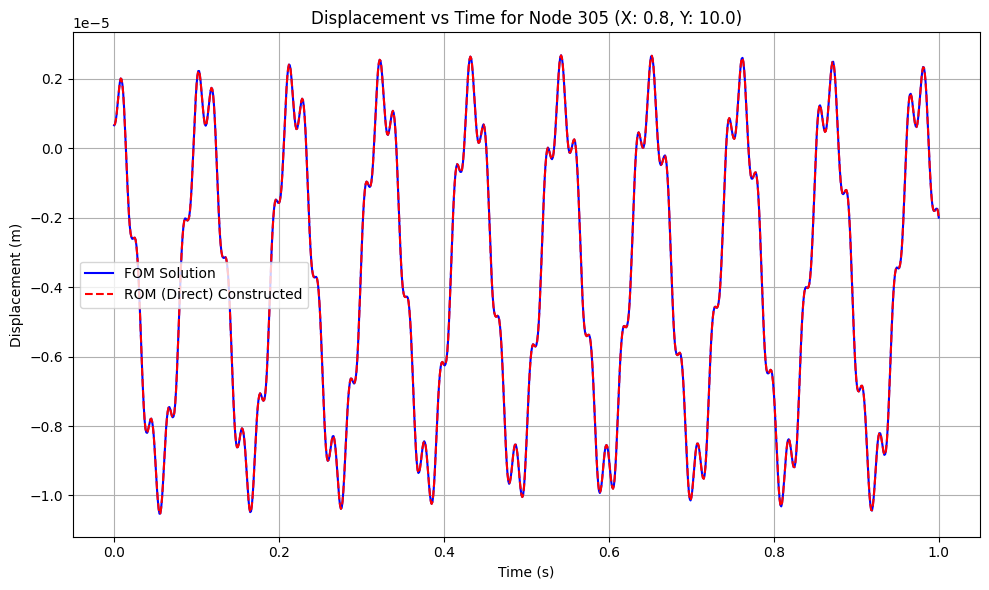

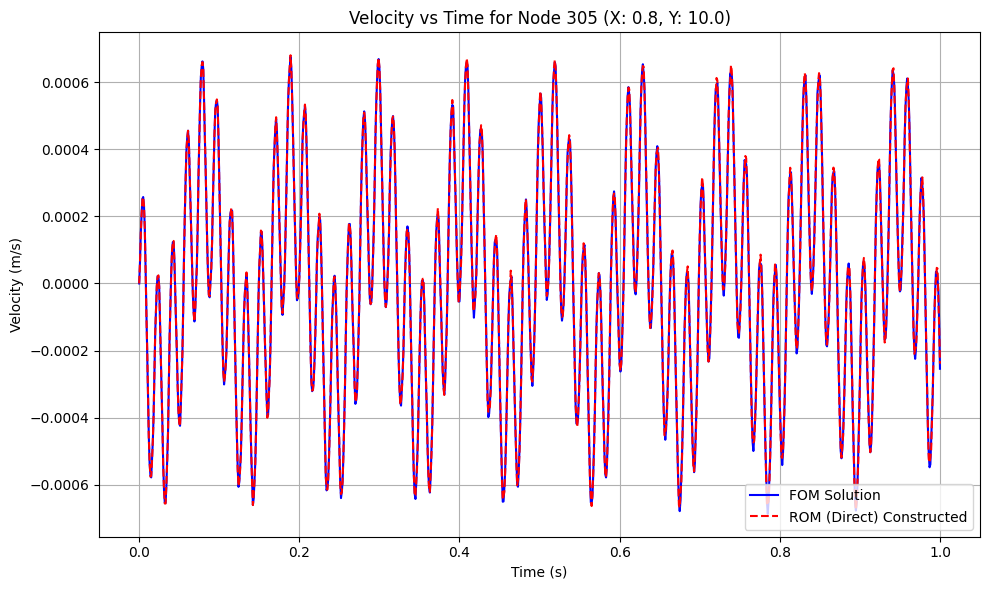

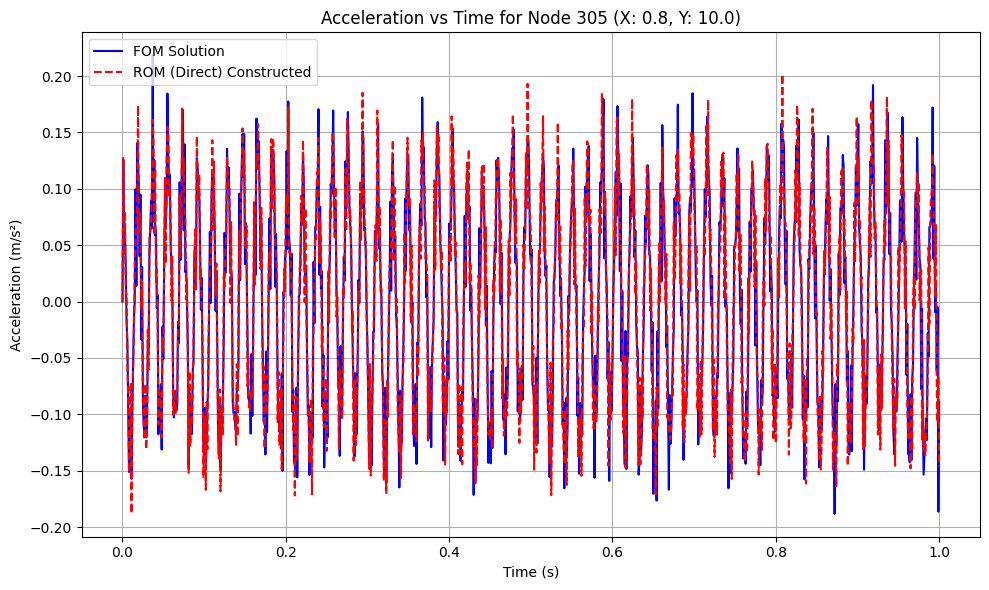

In [ ]:
from pathlib import Path

def plot_node_comparison(mdpa_file, node_ids, fom_folder, rom_folder, scale_factor=1e6):
    """
    Plot displacement, velocity, and acceleration vs. time for specified nodes.
    Compare FOM and ROM solutions.

    Parameters:
    -----------
    mdpa_file: str, path to the .mdpa file containing mesh information.
    node_ids: list of int, node IDs to analyze.
    fom_folder: Path, folder containing FOM solution data.
    rom_folder: Path, folder containing ROM solution data.
    scale_factor: float, scaling factor for displacements.
    """
    # Read mesh information from the .mdpa file
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    node_coords.append([int(parts[0]), float(parts[1]), float(parts[2])])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Load FOM solution data
    try:
        time_fom = np.load(fom_folder / 'time.npy')
        displacement_fom = np.load(fom_folder / 'displacement.npy')
        velocity_fom = np.load(fom_folder / 'velocity.npy')
        acceleration_fom = np.load(fom_folder / 'acceleration.npy')
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the FOM solution files exist in the specified folder.")
        return

    # Load ROM solution data
    try:
        time_rom = np.load(rom_folder / 'time.npy')
        displacement_rom = np.load(rom_folder / 'displacement.npy')
        velocity_rom = np.load(rom_folder / 'velocity.npy')
        acceleration_rom = np.load(rom_folder / 'acceleration.npy')
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the ROM solution files exist in the specified folder.")
        return

    # Highlight nodes and plot graphs
    for node_id in node_ids:
        # Find the node in the mesh
        selected_node = node_coords[node_coords[:, 0] == node_id][0]
        node_x, node_y = selected_node[1], selected_node[2]
        idx_array = np.where(node_coords[:, 0] == node_id)[0]
        if len(idx_array) == 0:
            print(f"Warning: Node ID {node_id} not found in the mesh. Skipping this node.")
            continue
        idx = idx_array[0]

        # Highlight the node on the mesh
        triangulation = tri.Triangulation(node_coords[:, 1], node_coords[:, 2], elements)
        plt.figure(figsize=(10, 10))
        plt.triplot(triangulation, 'k-', lw=0.5, alpha=0.5)
        plt.scatter(node_x, node_y, color='red', label=f'Selected Node {node_id}')
        plt.gca().add_artist(plt.Circle((node_x, node_y), radius=0.1, color='red', fill=False))
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Mesh with Highlighted Node {node_id}')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

        # Plot displacement vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_fom, displacement_fom[:, idx], label='FOM Solution', color='blue')
        plt.plot(time_rom, displacement_rom[:, idx], label='ROM (Direct) Constructed', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Displacement (m)')
        plt.title(f'Displacement vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot velocity vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_fom, velocity_fom[:, idx], label='FOM Solution', color='blue')
        plt.plot(time_rom, velocity_rom[:, idx], label='ROM (Direct) Constructed', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.title(f'Velocity vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot acceleration vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_fom, acceleration_fom[:, idx], label='FOM Solution', color='blue')
        plt.plot(time_rom, acceleration_rom[:, idx], label='ROM (Direct) Constructed', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.title(f'Acceleration vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage
node_ids_to_analyze = [1, 154, 305]  # Replace with desired node IDs
# Print the path of the folder being accessed
cwd = Path.cwd()
folder_path = cwd / "Dynamic_solution" / "case_9_magnitude_(391.22, -286.75, 386.86)" / "FOM_Solution" / "solution"
rom_folder_path = cwd / "Dynamic_solution" / "case_9_magnitude_(391.22, -286.75, 386.86)" / "ROM_standard_constructed"
print(f"Accessing FOM folder: {folder_path.resolve()}")
print(f"Accessing ROM folder: {rom_folder_path.resolve()}")

# List and print all files in the FOM folder
if folder_path.exists() and folder_path.is_dir():
    files = list(folder_path.iterdir())
    print("Files present in the FOM folder:")
    for file in files:
        print(file.name)
else:
    print(f"The FOM folder does not exist or is not a directory: {folder_path.resolve()}")

# List and print all files in the ROM folder
if rom_folder_path.exists() and rom_folder_path.is_dir():
    rom_files = list(rom_folder_path.iterdir())
    print("Files present in the ROM folder:")
    for file in rom_files:
        print(file.name)
else:
    print(f"The ROM folder does not exist or is not a directory: {rom_folder_path.resolve()}")

# Call the function
# plot_node_comparison(mdpa_file, node_ids_to_analyze, folder_path, Path("ROM_constructed"))
plot_node_comparison(mdpa_file, node_ids_to_analyze, folder_path, rom_folder_path)


In [ ]:
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path
import os
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def create_displacement_gif(folder_path, mdpa_file, scale_factor=1e6, step_interval=100):
    """
    Create a displacement GIF for a specific case.
    """
    folder_path = Path(folder_path)
    output_file = folder_path / 'displacement_animation.gif'

    print("=" * 80)
    print(f"🎯 Processing folder: {folder_path.resolve()}")

    # Load solution data
    time_file = folder_path / 'time.npy'
    displacement_file = folder_path / 'displacement.npy'
    print(f"📥 Reading displacement data from:")
    print(f"   ⏱️  Time data       : {time_file.resolve()}")
    print(f"   📌 Displacement data: {displacement_file.resolve()}")

    time = np.load(time_file)
    displacement = np.load(displacement_file)

    # Read node coordinates and elements from the .mdpa file
    print(f"📄 Reading mesh connectivity from: {mdpa_file.resolve()}")
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 15))

    # Base triangulation
    x = node_coords[:, 0]
    y = node_coords[:, 1]
    triangulation_orig = tri.Triangulation(x, y, elements)

    # Global displacement limits
    disp_magnitudes = []
    for step in range(len(time)):
        disp = displacement[step].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        disp_magnitudes.append(disp_mag)

    global_min = min(np.min(mag) for mag in disp_magnitudes)
    global_max = max(np.max(mag) for mag in disp_magnitudes)
    print(f"📊 Global displacement range: [{global_min:.2e}, {global_max:.2e}]")

    def update(frame):
        ax.clear()
        disp = displacement[frame].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        deformed_coords = node_coords + disp

        # Undeformed
        ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')

        # Deformed mesh
        triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
        tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                           vmin=global_min, vmax=global_max)
        ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
        ax.grid(True)
        ax.axis('equal')
        ax.legend()

        if frame == 0:
            plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
        plt.tight_layout()

    print("🛠️  Creating animation frames...")
    anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)

    # Save animation
    print(f"💾 Saving animation to: {output_file.resolve()}")
    writer = PillowWriter(fps=1000 / step_interval)
    anim.save(output_file, writer=writer)
    plt.close()
    print("✅ Animation complete!\n")
    return True

def process_cases(base_dir="Dynamic_solution", num_files=None):
    """
    Process cases in the Dynamic_solution directory.
    
    Args:
        base_dir: Base directory containing case folders
        num_files: Number of case files to process (None for all)
    """
    try:
        base_path = Path(base_dir)
        
        # Find all case folders
        case_folders = []
        for folder in base_path.glob("case_*_magnitude_*"):
            if (folder / "ROM_standard_constructed").exists():
                case_folders.append(folder / "ROM_standard_constructed")
        
        # Sort case folders by case number
        def extract_case_number(folder_path):
            # Extract the case number from the folder name
            folder_name = folder_path.parent.name
            return int(folder_name.split("_")[1])
        
        case_folders.sort(key=extract_case_number)
        
        total_cases = len(case_folders)
        print(f"Found {total_cases} case folders with 'ROM_standard_constructed' subdirectory.")
        
        if total_cases == 0:
            print("No valid case folders found. Exiting.")
            return
            
        # Find mdpa file in the current directory
        mdpa_files = list(Path(os.getcwd()).glob("*.mdpa"))
        if not mdpa_files:
            print("Error: No .mdpa file found in the current directory.")
            return
        mdpa_file = mdpa_files[0]
        print(f"Using mesh file: {mdpa_file}")
        
        # Get number of files to process
        if num_files is None:
            try:
                user_input = input(f"How many case files would you like to process? (Enter 'all' for all {total_cases} folders): ")
                if user_input.lower() == 'all':
                    num_files = total_cases
                else:
                    num_files = int(user_input)
                    if num_files <= 0 or num_files > total_cases:
                        print(f"Invalid number. Using all {total_cases} files.")
                        num_files = total_cases
            except ValueError:
                print(f"Invalid input. Processing all {total_cases} files.")
                num_files = total_cases
        else:
            # Ensure num_files is valid
            num_files = min(max(1, num_files), total_cases)
        
        # Limit to the specified number of files
        case_folders = case_folders[:num_files]
        
        print(f"\nWill process {len(case_folders)} of {total_cases} cases:")
        for folder in case_folders:
            print(f"  {folder.parent.name}")
        
        # Process each case
        successful = 0
        failed = 0
        
        for folder in case_folders:
            try:
                print("\n" + "=" * 50)
                print(f"Processing case: {folder.parent.name}")
                if create_displacement_gif(folder, mdpa_file, scale_factor=1e6):
                    successful += 1
                else:
                    failed += 1
            except Exception as e:
                print(f"Error processing {folder.parent.name}: {str(e)}")
                failed += 1
                
        print("\n" + "=" * 50)
        print("Processing Complete!")
        print(f"Successfully processed: {successful} cases")
        print(f"Failed to process: {failed} cases")
        print(f"Skipped: {total_cases - num_files} cases")
        print("=" * 50)
        
    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()


def run_gif_processing(base_dir="Dynamic_solution", num_files=None):
    """Function to call from Jupyter notebook cells"""
    process_cases(base_dir=base_dir, num_files=num_files)

if __name__ == "__main__":
    run_gif_processing()

Found 10 case folders with 'ROM_standard_constructed' subdirectory.
Using mesh file: d:\Submission_Documents\2D_beam_udl_loading\2D_beam_udl_loading.mdpa

Will process 1 of 10 cases:
  case_1_magnitude_(-137.59, -63.13, 362.93)

Processing case: case_1_magnitude_(-137.59, -63.13, 362.93)
🎯 Processing folder: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\ROM_standard_constructed
📥 Reading displacement data from:
   ⏱️  Time data       : D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\ROM_standard_constructed\time.npy
   📌 Displacement data: D:\Submission_Documents\2D_beam_udl_loading\Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\ROM_standard_constructed\displacement.npy
📄 Reading mesh connectivity from: D:\Submission_Documents\2D_beam_udl_loading\2D_beam_udl_loading.mdpa
📊 Global displacement range: [8.59e-18, 8.95e+00]
🛠️  Creating animation frames...
💾 Saving

In [ ]:
import numpy as np
from pathlib import Path
from tabulate import tabulate
from scipy.interpolate import interp1d

# Define directories and variables
base_dir = Path("Dynamic_solution")
variables = ["displacement", "velocity", "acceleration", "force"]

# Initialize results storage
comparison_results = []

# Process each case
for case_folder in sorted(base_dir.glob("case_*_magnitude_*")):
    case_name = case_folder.name
    fom_dir = case_folder / "FOM_Solution" / "solution"
    rom_dir = case_folder / "ROM_constructed"
    rom_std_dir = case_folder / "ROM_standard_constructed"
    
    case_data = {"Case": case_name}
    
    # Process each variable
    for variable in variables:
        fom_file = fom_dir / f"{variable}.npy"
        rom_file = rom_dir / f"{variable}.npy"
        rom_std_file = rom_std_dir / f"{variable}.npy"
        
        if all(f.exists() for f in [fom_file, rom_file, rom_std_file]):
            fom_data = np.load(fom_file)
            rom_data = np.load(rom_file)
            rom_std_data = np.load(rom_std_file)
            
            # Compute errors and accuracies
            error_rom = np.linalg.norm(fom_data - rom_data) / np.linalg.norm(fom_data)
            error_rom_std = np.linalg.norm(fom_data - rom_std_data) / np.linalg.norm(fom_data)
            
            accuracy_rom = (1 - error_rom) * 100
            accuracy_rom_std = (1 - error_rom_std) * 100
            
            # Store results
            case_data[f"{variable.capitalize()} ROM"] = f"{accuracy_rom:.2f}%"
            case_data[f"{variable.capitalize()} ROM_std"] = f"{accuracy_rom_std:.2f}%"
            case_data[f"{variable.capitalize()} Difference"] = f"{(accuracy_rom - accuracy_rom_std):.2f}%"
            
        else:
            case_data[f"{variable.capitalize()} ROM"] = "N/A"
            case_data[f"{variable.capitalize()} ROM_std"] = "N/A"
            case_data[f"{variable.capitalize()} Difference"] = "N/A"
    
    comparison_results.append(case_data)

# Create headers for the table
headers = ["Case"]
for var in variables:
    headers.extend([
        f"{var.capitalize()} ROM",
        f"{var.capitalize()} ROM_std",
        f"{var.capitalize()} Diff"
    ])

# Print comparative analysis
print("\n" + "=" * 120)
print(" COMPARATIVE ANALYSIS: ROM vs ROM_standard (Accuracy against FOM) ".center(120))
print("=" * 120)
print("Positive difference indicates ROM performs better than ROM_standard")
print("=" * 120)
print(tabulate(comparison_results, headers="keys", tablefmt="grid", numalign="right"))

# Calculate and display summary statistics
print("\n" + "=" * 120)
print(" SUMMARY STATISTICS ".center(120))
print("=" * 120)

summary_stats = []
for var in variables:
    rom_accuracies = [float(case[f"{var.capitalize()} ROM"].strip('%'))
                      for case in comparison_results 
                      if case[f"{var.capitalize()} ROM"] != "N/A"]
    
    rom_std_accuracies = [float(case[f"{var.capitalize()} ROM_std"].strip('%'))
                         for case in comparison_results 
                         if case[f"{var.capitalize()} ROM_std"] != "N/A"]
    
    if rom_accuracies and rom_std_accuracies:
        summary_stats.append({
            "Variable": var.capitalize(),
            "ROM Mean Accuracy": f"{np.mean(rom_accuracies):.2f}%",
            "ROM Std Accuracy": f"{np.mean(rom_std_accuracies):.2f}%",
            "Mean Difference": f"{np.mean(rom_accuracies) - np.mean(rom_std_accuracies):.2f}%",
            "Better Method": "ROM" if np.mean(rom_accuracies) > np.mean(rom_std_accuracies) else "ROM_standard"
        })

print(tabulate(summary_stats, headers="keys", tablefmt="grid", numalign="right"))


                            COMPARATIVE ANALYSIS: ROM vs ROM_standard (Accuracy against FOM)                            
Positive difference indicates ROM performs better than ROM_standard
+--------------------------------------------+--------------------+------------------------+---------------------------+----------------+--------------------+-----------------------+--------------------+------------------------+---------------------------+-------------+-----------------+--------------------+
| Case                                       | Displacement ROM   | Displacement ROM_std   | Displacement Difference   | Velocity ROM   | Velocity ROM_std   | Velocity Difference   | Acceleration ROM   | Acceleration ROM_std   | Acceleration Difference   | Force ROM   | Force ROM_std   | Force Difference   |
+============================================+====================+========================+===========================+================+====================+=======================+========

In [ ]:
# Calculate relative difference
rel_diff = (M_tilde - M_tilde_std) / M_tilde_std

# Print some statistics about the difference
print("\nRelative Difference Analysis [(M_tilde - M_tilde_std)/M_tilde_std]:")
print(f"Maximum absolute difference: {np.max(np.abs(rel_diff)):.2e}")
print(f"Mean absolute difference: {np.mean(np.abs(rel_diff)):.2e}")
print(f"Standard deviation of difference: {np.std(rel_diff):.2e}")


Relative Difference Analysis [(M_tilde - M_tilde_std)/M_tilde_std]:
Maximum absolute difference: 7.10e+01
Mean absolute difference: 5.96e+00
Standard deviation of difference: 1.24e+01


In [ ]:
import numpy as np
from tabulate import tabulate

def matrix_comparison_plot(M1, M2, name1="M_tilde", name2="M_tilde_std", precision=3):
    """
    Create a side-by-side visualization of two matrices in tabular format.
    
    Args:
        M1, M2: The matrices to compare
        name1, name2: Names of the matrices
        precision: Number of decimal places to display
    """
    # Format numbers to specified precision
    def format_matrix(M):
        return [[f"{x:.{precision}e}" for x in row] for row in M]
    
    M1_formatted = format_matrix(M1)
    M2_formatted = format_matrix(M2)
    
    # Create headers
    headers1 = [f"{name1}[{i}]" for i in range(M1.shape[1])]
    headers2 = [f"{name2}[{i}]" for i in range(M2.shape[1])]
    
    # Print matrices side by side
    print("\nMatrix Comparison:")
    print("=" * 80)
    print(f"\n{name1}:")
    print(tabulate(M1_formatted, headers=headers1, showindex=True, tablefmt="grid"))
    print(f"\n{name2}:")
    print(tabulate(M2_formatted, headers=headers2, showindex=True, tablefmt="grid"))

# Call the function with your matrices
matrix_comparison_plot(M_tilde, M_tilde_std)


Matrix Comparison:

M_tilde:
+----+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+
|    |   M_tilde[0] |   M_tilde[1] |   M_tilde[2] |   M_tilde[3] |   M_tilde[4] |   M_tilde[5] |   M_tilde[6] |   M_tilde[7] |   M_tilde[8] |   M_tilde[9] |   M_tilde[10] |   M_tilde[11] |
+====+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+===============+===============+
|  0 |     250.8    |       9.889  |       2.046  |     -10.29   |        5.783 |      -2.714  |       -7.063 |      -0.2842 |      -0.2801 |        8.284 |         8.568 |      -23.67   |
+----+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+
|  1 |       9.889  |    

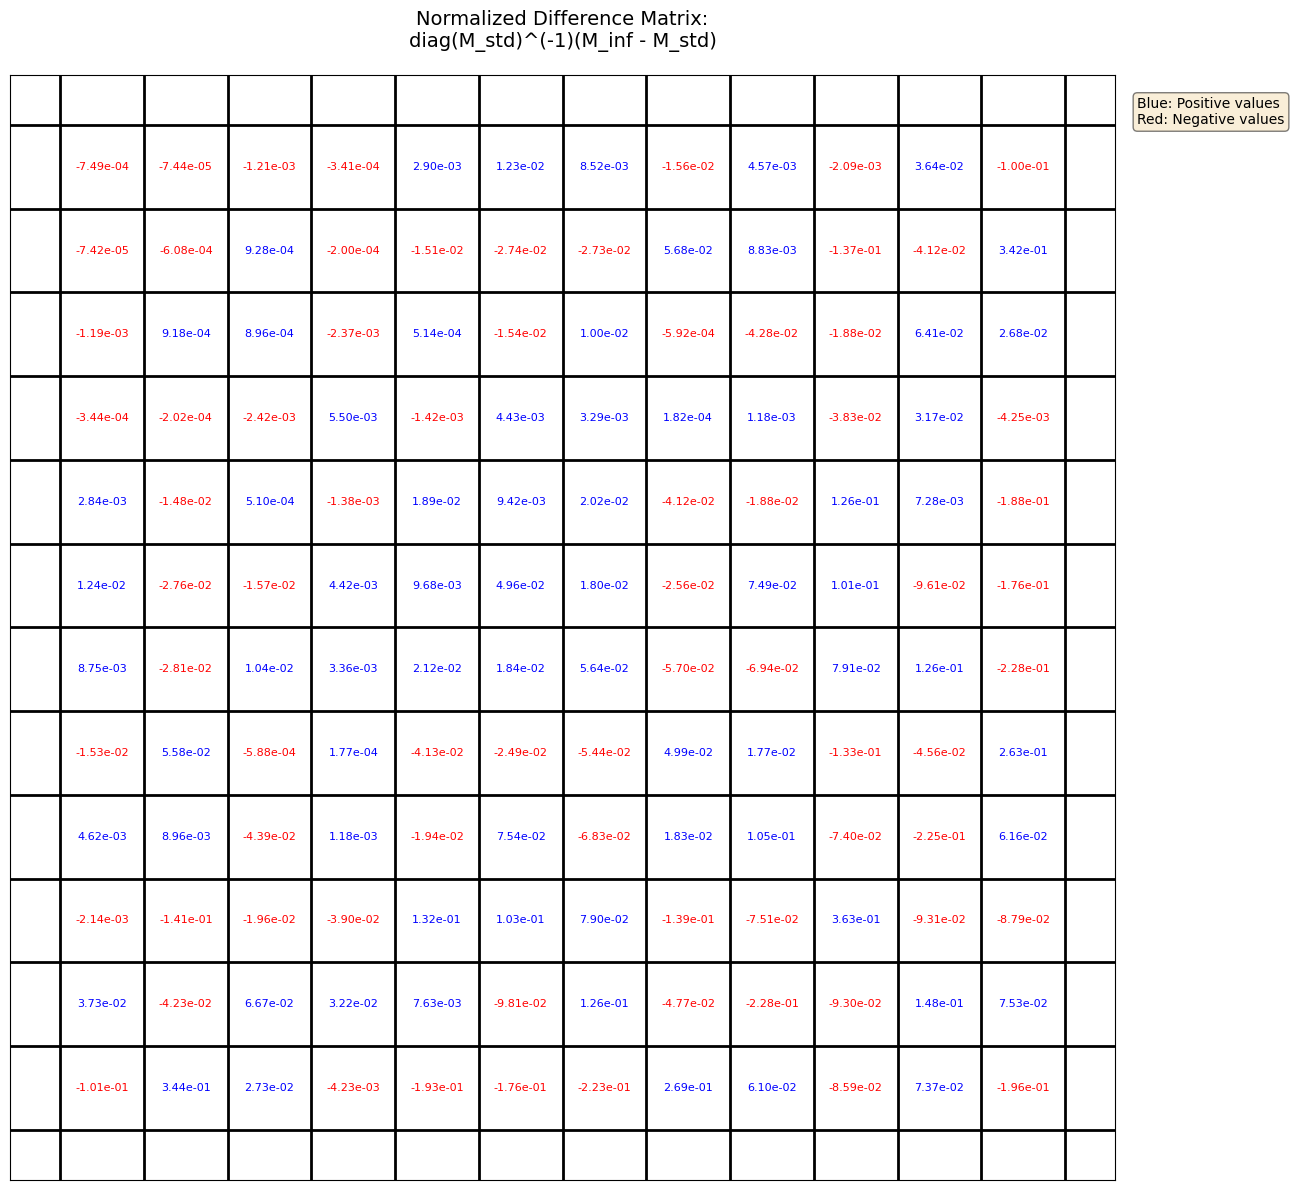


Normalized Difference Statistics:
--------------------------------------------------
Maximum absolute difference:     3.63e-01
Mean absolute difference:        5.78e-02
Standard deviation:              9.42e-02


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get diagonal terms of M_tilde_std
diag_std = np.diag(M_tilde_std)
diag_std_inv = np.diag(1/diag_std)

# Compute normalized difference
normalized_diff = diag_std_inv @ (M_tilde - M_tilde_std)

# Create figure with larger size
fig, ax = plt.subplots(figsize=(15, 12))

# Turn off axis lines and labels
ax.set_xticks([])
ax.set_yticks([])

# Get matrix dimensions
n_rows, n_cols = normalized_diff.shape

# Create grid
for i in range(n_rows + 1):
    ax.axhline(i, color='black', linewidth=2)
for j in range(n_cols + 1):
    ax.axvline(j, color='black', linewidth=2)

# Add values in each cell
for i in range(n_rows):
    for j in range(n_cols):
        value = normalized_diff[i, j]
        # Use different colors for positive and negative values
        color = 'red' if value < 0 else 'blue'
        # Format the number in scientific notation
        text = f'{value:.2e}'
        ax.text(j + 0.5, n_rows - i - 0.5, text, 
                ha='center', va='center', color=color,
                fontsize=8)

# Set aspect ratio to be equal
ax.set_aspect('equal')

# Add title and adjust layout
plt.title('Normalized Difference Matrix:\ndiag(M_std)^(-1)(M_inf - M_std)', 
          pad=20, fontsize=14)

# Add color legend
textstr = 'Blue: Positive values\nRed: Negative values'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(1.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Print statistics
print("\nNormalized Difference Statistics:")
print("-" * 50)
print(f"Maximum absolute difference:     {np.max(np.abs(normalized_diff)):.2e}")
print(f"Mean absolute difference:        {np.mean(np.abs(normalized_diff)):.2e}")
print(f"Standard deviation:              {np.std(normalized_diff):.2e}")

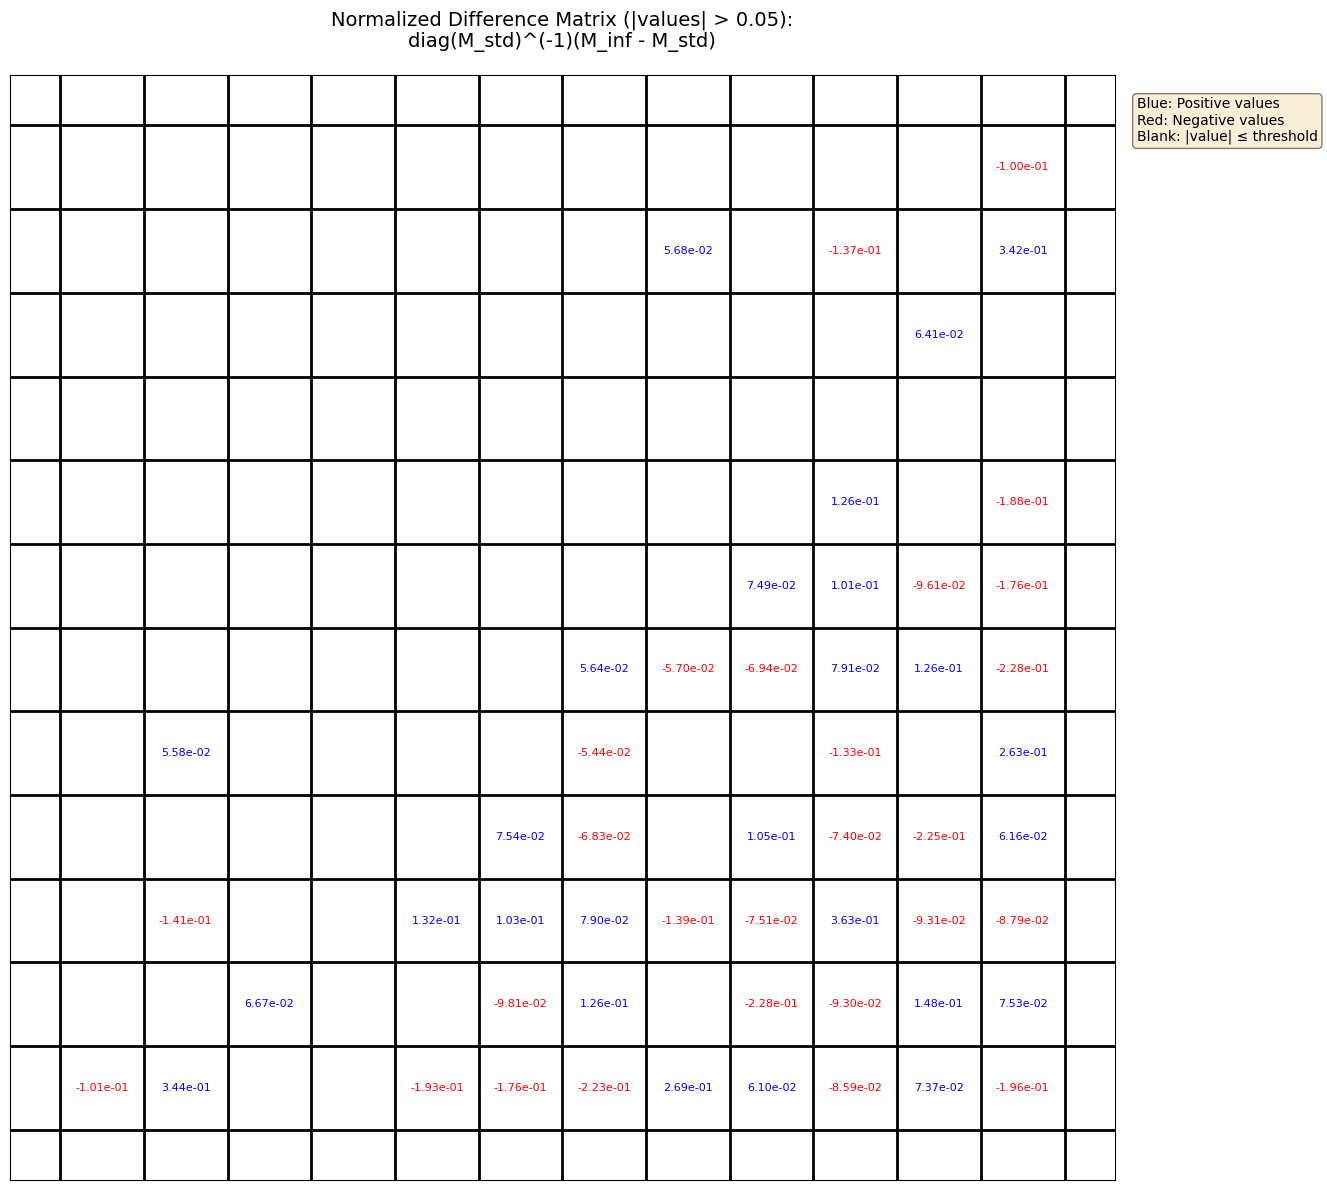


Non-zero Elements Statistics:
--------------------------------------------------
Number of elements above threshold: 53
Maximum absolute difference:        3.63e-01
Mean absolute difference:           1.31e-01
Standard deviation:                 1.53e-01


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Get diagonal terms of M_tilde_std
diag_std = np.diag(M_tilde_std)
diag_std_inv = np.diag(1/diag_std)

# Compute normalized difference
normalized_diff = diag_std_inv @ (M_tilde - M_tilde_std)

# Set threshold
threshold = 0.05
# Create masked array where small values become zero
masked_diff = np.where(np.abs(normalized_diff) > threshold, normalized_diff, 0)

# Create figure with larger size
fig, ax = plt.subplots(figsize=(15, 12))

# Turn off axis lines and labels
ax.set_xticks([])
ax.set_yticks([])

# Get matrix dimensions
n_rows, n_cols = masked_diff.shape

# Create grid
for i in range(n_rows + 1):
    ax.axhline(i, color='black', linewidth=2)
for j in range(n_cols + 1):
    ax.axvline(j, color='black', linewidth=2)

# Add values in each cell
for i in range(n_rows):
    for j in range(n_cols):
        value = masked_diff[i, j]
        if value != 0:  # Only show non-zero values
            # Use different colors for positive and negative values
            color = 'red' if value < 0 else 'blue'
            # Format the number in scientific notation
            text = f'{value:.2e}'
            ax.text(j + 0.5, n_rows - i - 0.5, text, 
                    ha='center', va='center', color=color,
                    fontsize=8)

# Set aspect ratio to be equal
ax.set_aspect('equal')

# Add title and adjust layout
plt.title(f'Normalized Difference Matrix (|values| > {threshold}):\ndiag(M_std)^(-1)(M_inf - M_std)', 
          pad=20, fontsize=14)

# Add color legend
textstr = 'Blue: Positive values\nRed: Negative values\nBlank: |value| ≤ threshold'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(1.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Print statistics of non-zero elements
non_zero_elements = normalized_diff[np.abs(normalized_diff) > threshold]
print("\nNon-zero Elements Statistics:")
print("-" * 50)
print(f"Number of elements above threshold: {len(non_zero_elements)}")
print(f"Maximum absolute difference:        {np.max(np.abs(non_zero_elements)):.2e}")
print(f"Mean absolute difference:           {np.mean(np.abs(non_zero_elements)):.2e}")
print(f"Standard deviation:                 {np.std(non_zero_elements):.2e}")